# **CAMIL** (Coordinates Alignment for Mapping Image Lines)
Get the points from the image of a curve

## Imports

In [ ]:
import os
from PIL import Image
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random



## Load images


### Load your images (e.g. from your drive)

In [ ]:
# Mount drive
drive.mount('/content/drive', force_remount=True)
# Go to your image directory
img_path = "/content/drive/MyDrive/Colab_Notebooks/curve_images"
os.chdir(img_path)
# Extract the images
image_files = os.listdir()
image_files = [file for file in image_files if file.endswith(('jpg', 'jpeg', 'png'))]
loaded_images = []
for file in image_files:
    image_path = os.path.join(img_path, file)
    image = Image.open(image_path)
    loaded_images.append(np.array(image))

images = loaded_images

Mounted at /content/drive


#### Process images
If you have images with a white/light backgorund and a coloured curve you can apply this function on your images to make them have black backgorund and white curve.

In [ ]:
def rgb_curve_to_binary(image):

    # Convert image to grayscale
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)

    # Threshold the inverted image to get a binary image (adjust threshold if needed)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV+ cv2.THRESH_OTSU)

    return binary

process = False

if process:
  bin_images = []
  for image in loaded_images:
      bin_image = rgb_curve_to_binary(image)
      bin_images.append(bin_image)
  images = bin_images

### You can even create some sample ones with this following code

In [ ]:
from scipy.interpolate import interp1d

def generate_random_curve_image(img_height, img_width, num_points):
    def draw_curve_on_image(curve_points, color):
        # Create a blank image with a dark background
        background_color = tuple(random.randint(0, 50) for _ in range(3))  # Dark background color
        img = np.full((img_height, img_width, 3), background_color, dtype=np.uint8)

        # Draw the curve on the image
        cv2.polylines(img, [np.array(curve_points, dtype=np.int32)], isClosed=False, color=color, thickness=2)

        return img

    def generate_random_curve(border=100, max_displacement=100):
        # Define area limits for random points
        min_x = border
        max_x = img_width - border
        min_y = border
        max_y = img_height - border

        # Generate the first random point
        curve_points = [(random.randint(min_x, max_x), random.randint(min_y, max_y))]


        # Generate random points near the previous point
        for _ in range(num_points - 1):
            prev_x, prev_y = curve_points[-1]
            new_x = random.randint(max(prev_x - max_displacement, min_x), min(prev_x + max_displacement, max_x))
            new_y = random.randint(max(prev_y - max_displacement, min_y), min(prev_y + max_displacement, max_y))
            curve_points.append((new_x, new_y))

        # Interpolate points to form a smooth curve
        interp_func = interp1d(np.arange(len(curve_points)), np.array(curve_points), axis=0, kind='quadratic')
        x_new = np.linspace(0, len(curve_points) - 1, 100)
        curve_points = interp_func(x_new)

        # Check for loops in the interpolated curve
        loop_detected = True
        while loop_detected:
            loop_detected = False
            for i in range(1, len(curve_points) - 3):
                seg1 = [curve_points[i-1], curve_points[i]]
                for j in range(i+2, len(curve_points) - 1):
                    seg2 = [curve_points[j-1], curve_points[j]]
                    if segments_intersect(seg1, seg2):
                        loop_detected = True
                        break
                if loop_detected:
                    break

            # If a loop is detected, generate a new random curve
            if loop_detected:
                curve_points = generate_random_curve(border, max_displacement)

        return curve_points.astype(int)

    def segments_intersect(seg1, seg2):
        # Check if two line segments intersect
        x1, y1 = seg1[0]
        x2, y2 = seg1[1]
        x3, y3 = seg2[0]
        x4, y4 = seg2[1]
        denom = (y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1)
        if denom == 0:
            return False  # Parallel or coincident
        ua = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / denom
        ub = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / denom
        return 0 <= ua <= 1 and 0 <= ub <= 1


    def generate_random_color():
        # Generate random light colors for better visibility
        return tuple(random.randint(150, 255) for _ in range(3))

    # Generate random curve points
    curve_points = generate_random_curve()

    # Generate a random color for the curve
    color = generate_random_color()

    # Draw the curve on the image with the random color
    img = draw_curve_on_image(curve_points, color)

    return img


In [ ]:
images = []
num_images = 20
height = 480
width = 640
num_points = 4
for i in range(0,num_images):
  img = generate_random_curve_image(height, width, num_points)
  images.append(img)


### Plotting functions

In [ ]:
# plotting functions
def plot_image(image, title='image'):
    plt.figure(figsize=(4, 4))  # Adjust figure size as needed
    plt.imshow(image, cmap='gray')
    plt.title(title)  # Add a title to identify each image
    plt.axis('off')  # Turn off axis
    plt.show()

def plot_coordinates(image, img_width, img_height, curves_coordinates):
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    print('curves:' , len(curves_coordinates))
    for curve, coordinates in enumerate(curves_coordinates):


        # Flip the y-axis to match image coordinates
        coordinates = [(x, img_height - y) for x, y in coordinates]

        # Extract x and y coordinates
        x_coords, y_coords = zip(*coordinates)

        # Define a custom colormap with darker shades
        colors = ['#000055', '#000077', '#000099', '#0000BB', '#0000DD',
                  '#0000FF', '#2222FF', '#4444FF', '#6666FF', '#8888FF',
                  '#AAAAFF']
        cmap = plt.cm.colors.ListedColormap(colors)

        # Plot the coordinates as a line with a gradient of colors on the left subplot
        for i in range(len(coordinates) - 1):
            x1, y1 = coordinates[i]
            x2, y2 = coordinates[i+1]
            color = cmap((i+1) / len(coordinates))  # Get color based on position along the line
            axs[0].plot([x1, x2], [y1, y2], color=color, label='Path' if i == 0 and curve == 0 else '_')

        # Plot arrows at the start and at the second to last end point
        for i in range(0, len(coordinates)):
            if i == 0 or i == len(coordinates) - 2:
                x, y = coordinates[i]
                dx, dy = coordinates[i+1] if i+1 < len(coordinates) else coordinates[i]
                axs[0].arrow(x, y, dx-x, dy-y, color='red', width=5, head_width=8, head_length=10, label='Direction' if i == 0 and curve == 0 else None)

        # Set the aspect ratio to match the image
        axs[0].set_aspect('equal', adjustable='box')

        # Set the limits of the plot axes to match the image dimensions
        axs[0].set_xlim(0, img_width)
        axs[0].set_ylim(0, img_height)

        axs[0].set_xlabel('X')
        axs[0].set_ylabel('Y')
        axs[0].set_title('Coordinates on Image')
        axs[0].grid(True)
        axs[0].legend()

        # Display the original image on the right subplot
        axs[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Original Curve Image')
        axs[1].axis('off')
        plt.tight_layout()
    plt.show()

### Plot the images

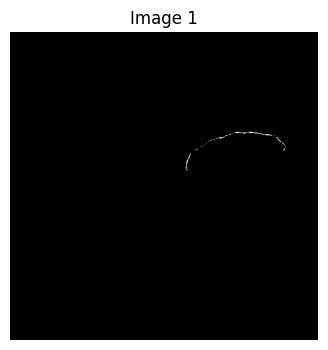

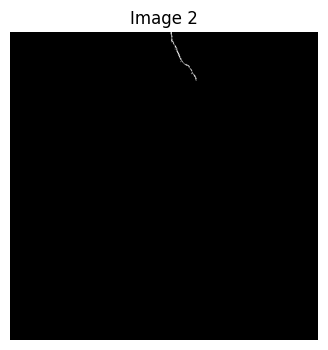

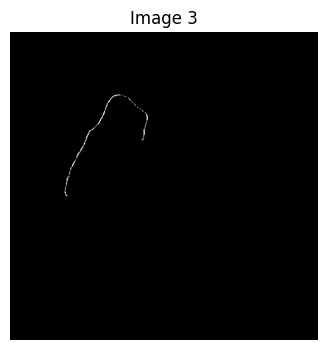

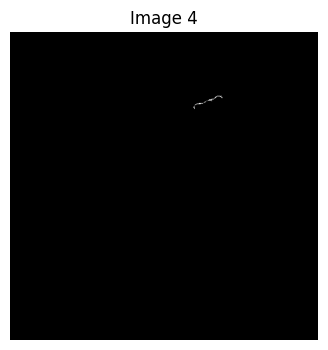

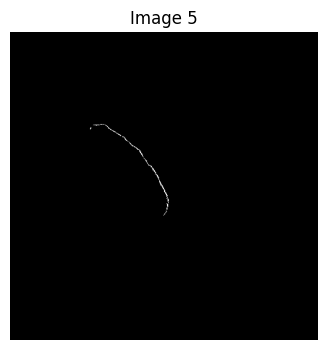

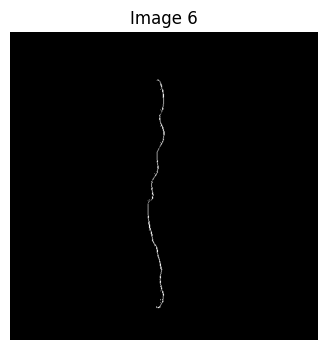

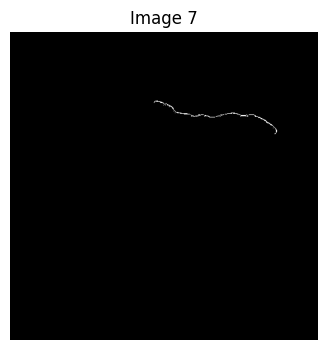

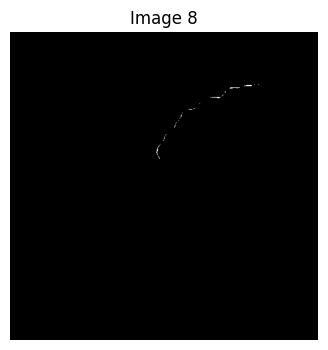

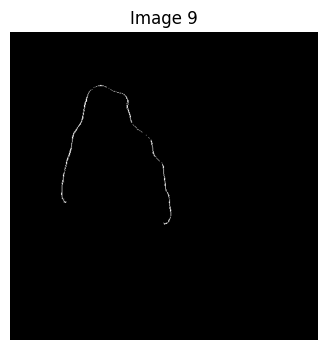

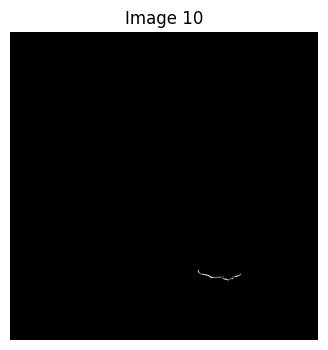

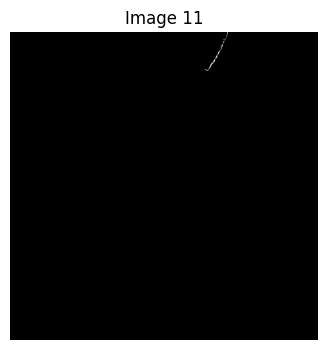

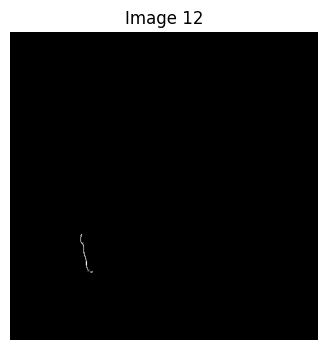

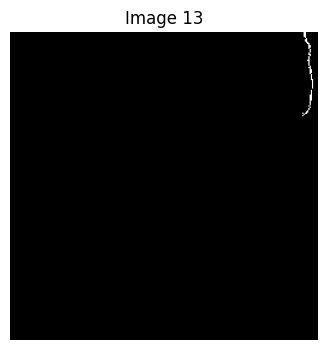

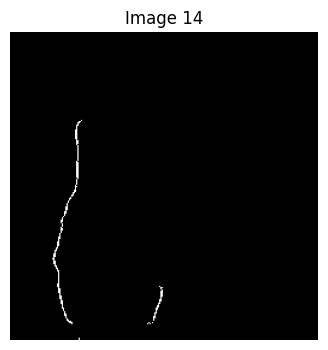

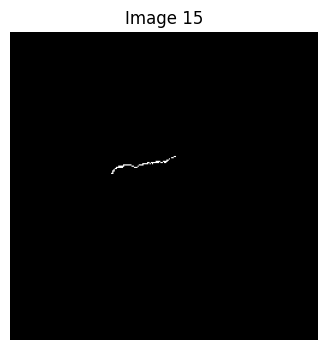

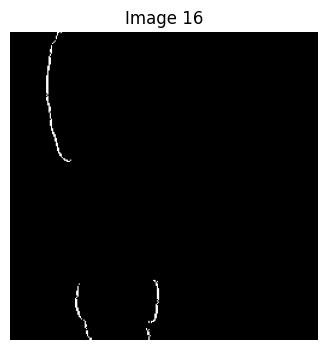

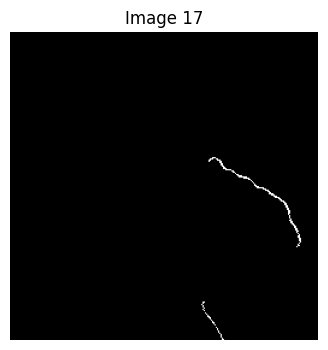

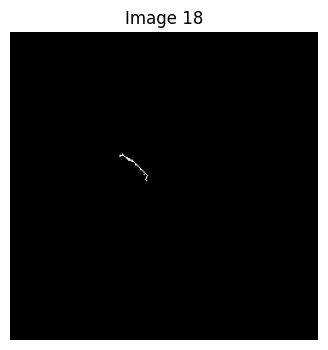

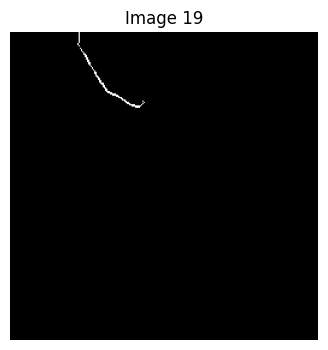

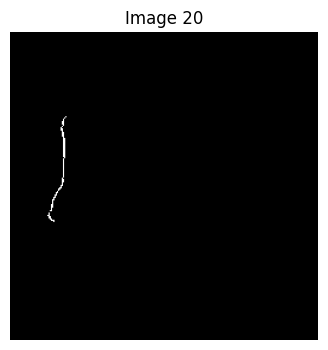

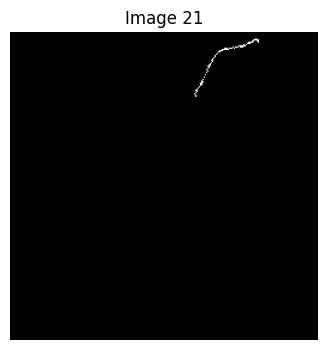

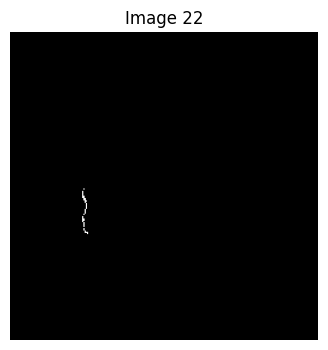

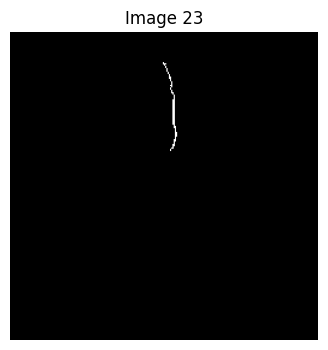

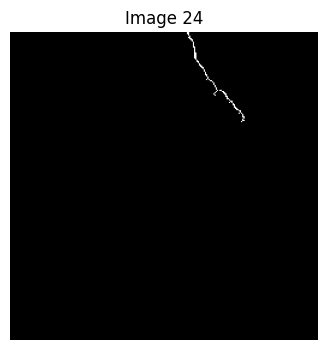

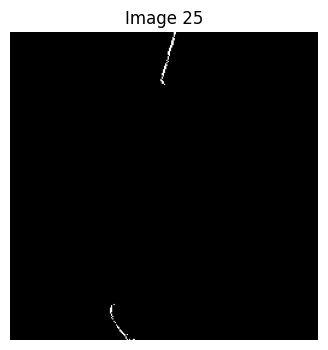

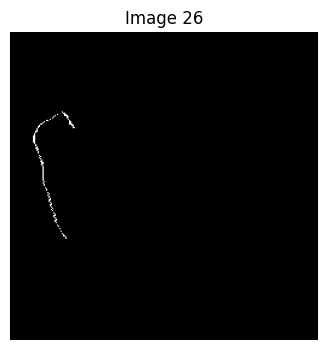

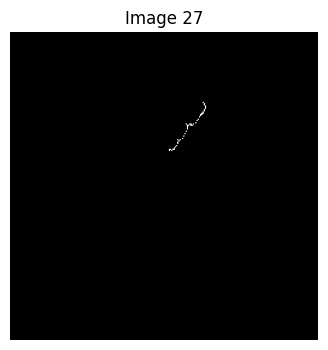

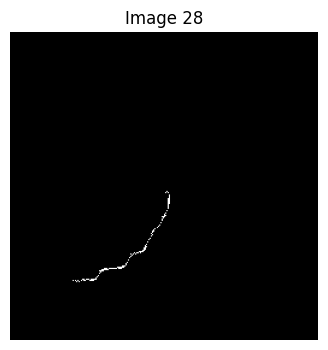

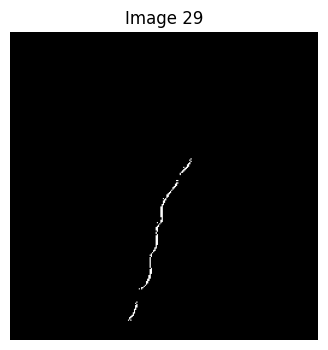

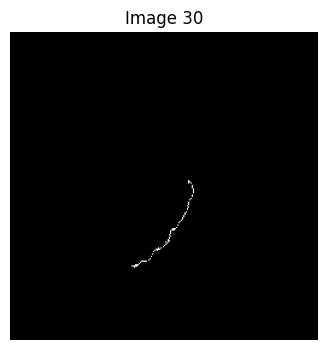

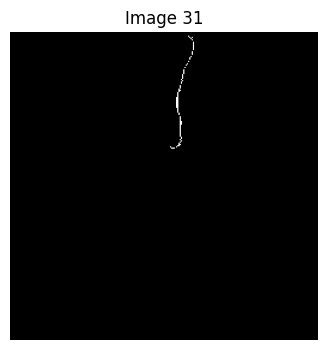

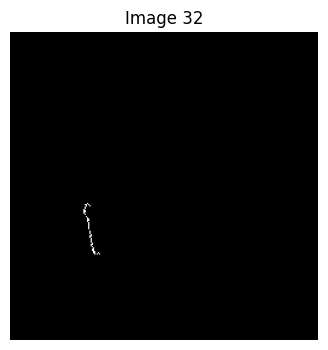

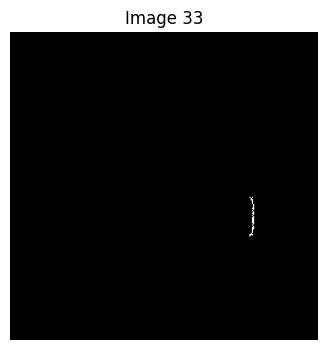

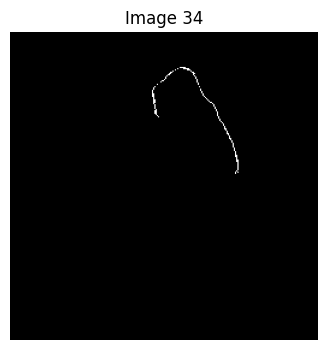

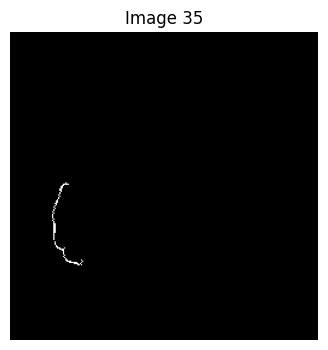

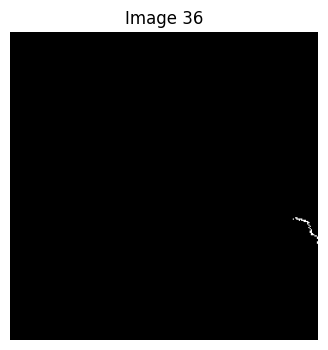

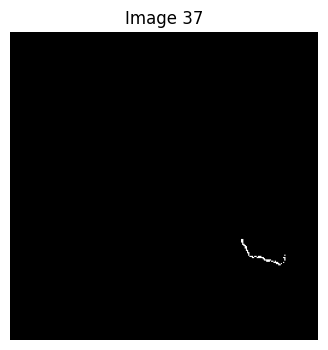

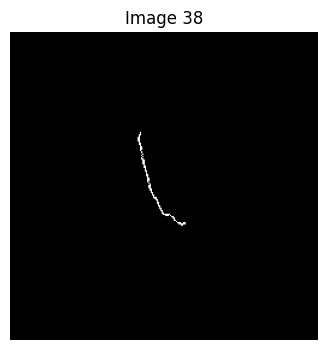

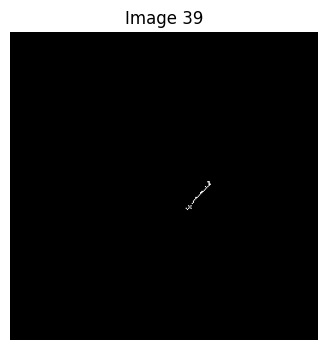

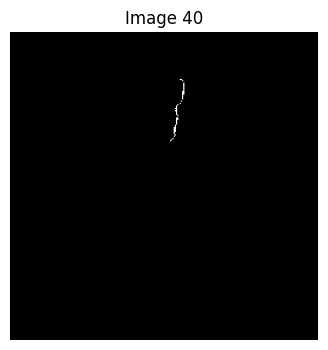

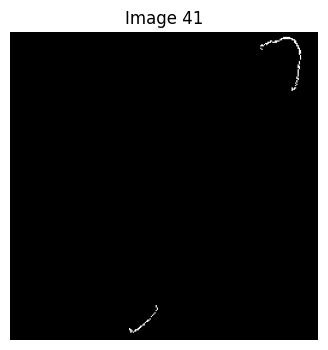

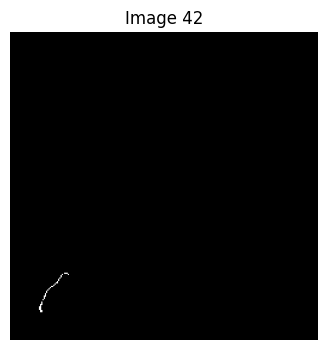

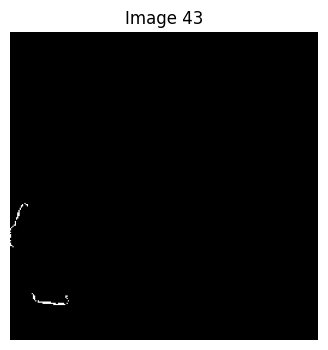

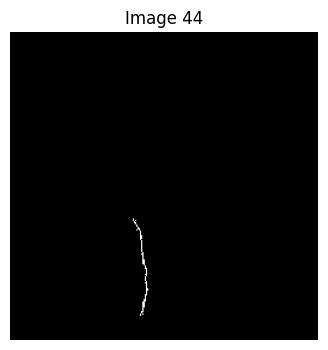

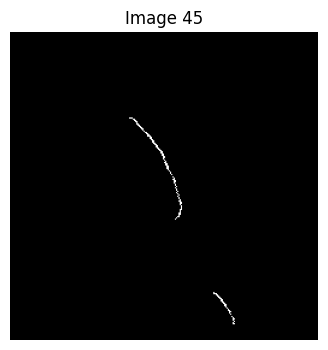

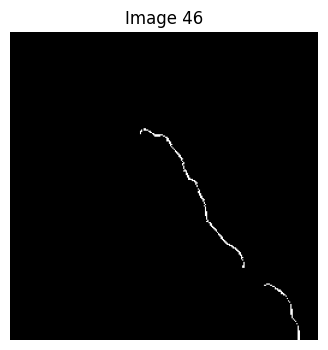

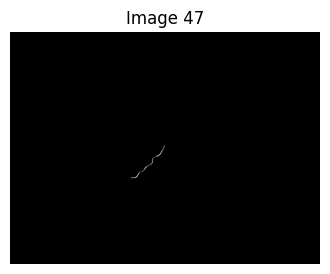

In [ ]:
# Iterate through the list of images and plot each one
for i, image in enumerate(images):
    plot_image(image, f'Image {i+1}')

### **Define the CAMIL class**

**PARAMETERS**

* ***residue*** : remaining number of pixels on an image for which it can be
considered black
* ***thresh*** : binary image conversion threshold
* ***max_distance*** : max distance bw points in the curve image (increase it if you have more sparse point) (decrease it for higher precision)
* ***min_dist_bw_curves*** : min distance bw two curves to be considered separate
* ***max_it*** : max number of time the ordering algorithms can be applied (increase it for higher precision) (decrease it for speed)
* ***thickness*** : Increase the curve thickness to fit a centered ellipse on it (increase it if you have a sparse curve)(slightly decrease it for higher precision)
* ***print_info*** : To print info messages

In [ ]:
class CAMIL:

    # PARAMETERS #
    residue = 10 # remaining number of pixels on an image for which it can be considered black
    thresh = 128 # binary image conversion threshold
    max_distance = 10 # max distance bw points in the curve image (increase it if you have more sparse point) (decrease it for higher precision)
    min_dist_bw_curves = 20 # min distance between to curves to be considered separate
    max_it = 15 # max number of time the ordering algorithms can be applied (increase it for higher precision) (decrease it for speed)
    thickness = 10 # Increase the curve thickness to fit a centered ellipse on it (increase it if you have a sparse curve)(slightly decrease it for higher precision)
    print_info = False # To print info messages

    @staticmethod
    def skeletonize(img):
        """ OpenCV function to return a skeletonized version of img, a Mat object"""

        #  hat tip to http://felix.abecassis.me/2011/09/opencv-morphological-skeleton/

        img = img.copy() # don't clobber original
        skel = img.copy()

        skel[:,:] = 0
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

        while True:
            eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
            temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
            temp  = cv2.subtract(img, temp)
            skel = cv2.bitwise_or(skel, temp)
            img[:,:] = eroded[:,:]
            if cv2.countNonZero(img) == 0:
                break

        return skel

    @staticmethod
    def thicken(img, thickness=thickness):
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_thick = cv2.drawContours(img.copy(), contours, -1, (255, 255, 255), thickness)
        return img_thick

    @staticmethod
    def convert_to_binary(image, thresh=thresh):
        if len(image.shape) != 2 and image.shape[2] != 1:  # Check if not grayscale
            # Convert image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            _, binary_image = cv2.threshold(gray_image, thresh, 255, cv2.THRESH_BINARY)
        else: # image already grascale
            if len(image.shape) == 2: # image already binary
                binary_image = image
            else:
                # Apply thresholding (adjust the threshold value as needed)
                _, binary_image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)

        return binary_image

    @staticmethod
    def find_cont_centroid(image):
        image = CAMIL.thicken(image.copy()) # obtain a thick shape profile of the curve
        # Find contours of the white shape
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:

            # Fit an ellipse to the contours
            ellipse = cv2.fitEllipse(contours[0])

            # Draw the fitted ellipse on a black background
            #fitted_ellipse_image = np.zeros_like(image)
            #fitted_ellipse_image = cv2.ellipse(fitted_ellipse_image, ellipse, (255, 255, 255), -1)

            # Extract the center coordinates of the ellipse
            center = (int(ellipse[0][0]), int(ellipse[0][1]))
            found = True
            return center, found
        else:
            found = False
            if CAMIL.print_info:
              print("No contours found in the image.")
            return None, found

    @staticmethod
    def extract_contour_pixels(image):
        # Find contours in the binary image
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours:
            if CAMIL.print_info:
              print("No contours found.")
            return []
        # Extract the contour pixels
        contour_pixels = []
        for contour in contours:
            for point in contour:
                contour_pixels.append((point[0][0], point[0][1]))

        return contour_pixels

    @staticmethod
    def extract_pixels(image):
        # get white pixels
        white_pixels = np.argwhere(image == 255).tolist()
        if not white_pixels:
            if CAMIL.print_info:
              print("No pixel found.")
            return []

        pixels = []
        for point in white_pixels:
                pixels.append((point[1], point[0])) # reversed (image order)

        return pixels


    @staticmethod
    def check_map_status(curve_img, mapped, thickness = 3):
        mapped = CAMIL.thicken(mapped, thickness) # thicken a bit the currently mapped curve img to avoid residual single pixels outliers
        residual_map = cv2.subtract(curve_img.copy(), mapped)

        # check if there are no residual pixels to order
        residual_sum = residual_map.sum()
        if residual_sum < CAMIL.residue * 255: # there are basically no more pixels to order
            exist = False
        else:
            exist = True # there are still pixel to order
        return exist, residual_map

    @staticmethod
    def check_contours(img): # to check if there are 2 curves in an image
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # To check if one of the two images without the extreme points has more than one contour it means it took as points some that are in the middle of the curve
        background = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        separate = False
        seg1= None
        seg2= None
        if len(contours)==2 and len(contours[0]) > CAMIL.max_distance and len(contours[1]) > CAMIL.max_distance:
            separate = True
            seg1 = CAMIL.skeletonize(cv2.drawContours(background.copy(), contours, 0, (255, 255, 255), -1))
            seg2 = CAMIL.skeletonize(cv2.drawContours(background.copy(), contours, 1, (255, 255, 255), -1))
        return contours, separate, seg1, seg2

    @staticmethod
    def check_contour_status(mapped, start_point, end_point): # to check if the founded extreme points are actually at the extremes of the curve
        mapped = CAMIL.thicken(mapped, thickness=2) # thicken a bit the currently mapped curve img to avoid residual single pixels outliers
        map_s = cv2.circle(mapped.copy(), start_point, radius=2, color=(0, 0, 0), thickness=3) # draw black circle for start point
        map_e = cv2.circle(mapped.copy(), end_point, radius=2, color=(0, 0, 0), thickness=3) # draw black circle for end point
        cont_s, sep_s, seg1s, seg2s = CAMIL.check_contours(map_s.copy())
        cont_e, sep_e, seg1e, seg2e = CAMIL.check_contours(map_e.copy())
        separate = False
        seg1= None
        seg2= None
        if len(cont_s)==2 and len(cont_s[0]) > CAMIL.max_distance and len(cont_s[1]) > CAMIL.max_distance:
            separate = sep_s
            seg1 = seg1s
            seg2 = seg2s
        elif len(cont_e)==2 and len(cont_e[0]) > CAMIL.max_distance and len(cont_e[1]) > CAMIL.max_distance:
            separate = sep_e
            seg1 = seg1e
            seg2 = seg2e
        return separate, seg1, seg2

    @staticmethod
    def check_extremes(curve_img, curve_points, start_point, end_point): # to check if the founded extreme points are non near eachother (otherwise the curve has looped on itself, like a conotur)
        distance = math.dist(start_point, end_point)
        height, width = curve_img.shape[:2]
        result = True
        if distance < CAMIL.max_distance:

            curr_points = curve_points[0][:len(curve_points[0])//2]
            curr_map = CAMIL.draw(height, width, curr_points) # draw the curve ordered following contour logic
            curve_exist, residual = CAMIL.check_map_status(curve_img.copy(), curr_map.copy()) # check if the curve ordered following the contour is good (bigger thickness cause contours might create very tight loops (not single pix. lines) that must be properly deleted)
            curr_map = cv2.subtract(curve_img.copy(), residual.copy())  # curve map was based on contours , so might have tight loops instead of single lines
            if curve_exist: # there's residue
                curve_connected, connected = CAMIL.connect_segments(curr_map.copy(),residual.copy()) # connect the residual and curr map pts
                if connected:
                    curve_points = curve_connected
                    curve_points = CAMIL.concatenate_list(curve_points)
                else:
                    result = False # bad ending
            else: # no residue, mapped image is good
                curve_points = [curr_points]

        return curve_points, result


    @staticmethod
    def order_path_pixels(points, start_point_coord, centroid, max_distance=max_distance):
        ordered_pixels = [start_point_coord]  # Initialize list with starting point

        # Convert points to a set for efficient removal
        if len(points)==0:
          return points
        points_set = set(point for point in points)

        # Remove starting point from points set
        points_set.remove(start_point_coord)

        # While there are still points left
        while points_set:
            # Find the nearest point to the last point in the ordered list
            nearest_point = min(points_set, key=lambda point: math.dist(point, ordered_pixels[-1]))

            # Calculate distance between nearest point and last ordered point
            distance = math.dist(nearest_point, ordered_pixels[-1])

            # If distance is greater than max_distance, stop adding points
            if distance > max_distance:
                break

            # Add the nearest point to the ordered list
            ordered_pixels.append(nearest_point)

            # Remove the nearest point from the set
            points_set.remove(nearest_point)

        return ordered_pixels

    @staticmethod
    def draw(height, width, pixels):
        image = np.zeros((height, width), dtype=np.uint8)
        for coord in pixels:
            x, y = coord
            image[y, x] = 255  # Set pixel to white
        return image

    @staticmethod
    def draw_lines(height, width, coordinates):
        img = np.zeros((height, width), dtype=np.uint8)
        # Convert coordinates to integer
        coordinates = np.array(coordinates, dtype=np.int32)
        # Draw lines between consecutive points
        for i in range(len(coordinates) - 1):
            cv2.line(img, tuple(coordinates[i]), tuple(coordinates[i+1]), (255, 255, 255), thickness=1)

        return img

    @staticmethod
    def concatenate_list(l):
        concatenated_list = []
        for arr in l:
            concatenated_list.extend(arr)
        l = [concatenated_list] # (1, len, 2)
        return l

    @staticmethod
    def direction_criterium(img_width, img_height, points):
        # Bottom-left corner coordinates
        bottom_left = (0, img_height)

        # Calculate distance from each point to the bottom-left corner
        distances = [math.dist(bottom_left, point) for point in points]

        # Find index of the point with the smallest distance
        nearest_index = min(range(len(points)), key=lambda i: distances[i])
        # Return the index of the nearest point
        return nearest_index

    @staticmethod
    def closest_points(points):
        closest_distance = float('inf')
        closest_indices = None
        closest_start_end = None


        n = len(points)

        for i in range(n):
            start1, end1 = points[i]
            for j in range(i + 1, n):  # Compare with subsequent points only
                start2, end2 = points[j]

                dist_start_start = math.dist(start1, start2)
                dist_end_end = math.dist(end1, end2)
                dist_start_end = math.dist(start1, end2)
                dist_end_start = math.dist(end1, start2)


                # Update closest distance and indices if the current pair is closer
                if dist_start_start < closest_distance:
                    closest_distance = dist_start_start
                    closest_indices = (i, j)
                    closest_start_end = (0, 0)  # Indicating start and start
                if dist_end_end < closest_distance:
                    closest_distance = dist_end_end
                    closest_indices = (i, j)
                    closest_start_end = (1, 1)  # Indicating end and end
                if dist_start_end < closest_distance:
                    closest_distance = dist_start_end
                    closest_indices = (i, j)
                    closest_start_end = (0, 1)  # Indicating start and end
                if dist_end_start < closest_distance:
                    closest_distance = dist_end_start
                    closest_indices = (i, j)
                    closest_start_end = (1, 0)  # Indicating end and start

        return closest_distance, closest_indices, closest_start_end

    @staticmethod
    def connect_close_curves(curves_coords, max_distance = max_distance):
        extreme_points = []
        curve_points = None
        connected = False
        for coords in curves_coords:
            if coords:
                extreme_points.append((coords[0], coords[-1]))
        # Find the closest pair between these points
        distance, indices, start_end = CAMIL.closest_points(extreme_points)

        if indices and start_end:
            curve_points1 = [curves_coords[indices[0]]]
            curve_points2 = [curves_coords[indices[1]]]
            if distance < max_distance:

                if start_end[0]==0 and start_end[1]==0: # (start1,start2)

                    curve_points1 = np.array(curve_points1)[:, ::-1, :].tolist() #reverse it
                    curve_points1.extend(curve_points2)
                    curve_points = curve_points1
                    connected = True
                elif start_end[0]==0 and start_end[1]==1: # (start1,end2)
                    curve_points2.extend(curve_points1)
                    curve_points = curve_points2
                    connected = True
                elif start_end[0]==1 and start_end[1]==0: # (end1,start2)
                    curve_points = curve_points1.extend(curve_points2)
                    curve_points = curve_points1
                    connected = True
                elif start_end[0]==1 and start_end[1]==1: # (end1,end2)
                    curve_points2 = np.array(curve_points2)[:, ::-1, :].tolist() #reverse it
                    curve_points = curve_points1.extend(curve_points2)
                    curve_points = curve_points1
                    connected = True
                else:
                    if CAMIL.print_info:
                      print("Warning the resulting interpolated curve might not be correct/accurate as one of its extreme points is inside the curve!")

        return curve_points, connected, indices


    @staticmethod
    def connect_segments(seg1_img, seg2_img):
        curve_points1 = CAMIL.map_curve(seg1_img)
        curve_points2 = CAMIL.map_curve(seg2_img)
        curves_coords = [curve_points1[0], curve_points2[0]]
        curve_points, connected, indices = CAMIL.connect_close_curves(curves_coords)
        if indices!=(0,1): # just check to be sure it compare jsut 2 segments
            curve_points = None
            connected = False

        return curve_points, connected


    @staticmethod
    def connect_3segments(seg1_img, seg2_img, seg3_img):
        height, width = seg1_img.shape[:2]

        seg_connected, connected = CAMIL.connect_segments(seg1_img.copy(), seg2_img.copy())
        if connected: # 1 2 -3
            seg12_img = CAMIL.draw(height, width, seg_connected[0])
            curve_connected, connected = CAMIL.connect_segments(seg12_img.copy(), seg3_img.copy())
        else:
            seg_connected, connected = CAMIL.connect_segments(seg1_img.copy(), seg3_img.copy())
            if connected: #1 3 -2
                seg13_img = CAMIL.draw(height, width, seg_connected[0])
                curve_connected, connected = CAMIL.connect_segments(seg13_img.copy(), seg2_img.copy())
            else:
                seg_connected, connected = CAMIL.connect_segments(seg2_img.copy(), seg3_img.copy())
                if connected: # 2 3 -1
                    seg23_img = CAMIL.draw(height, width, seg_connected[0])
                    curve_connected, connected = CAMIL.connect_segments(seg23_img.copy(), seg1_img.copy())
                else:
                    curve_connected = None
        return curve_connected, connected

    @staticmethod
    def map_pixels(curve_img): # last-resort method that uses pixel-order if godd (e.g. if not residual)
        height, width = curve_img.shape[:2]
        curve_pix = CAMIL.extract_pixels(curve_img.copy()) # find the pixels in the image
        curr_map = CAMIL.draw_lines(height, width, curve_pix) # draw the curve ordered following image order
        curve_exist1, residual1 = CAMIL.check_map_status(curve_img.copy(), curr_map.copy()) # check if the curve ordered following the image direction s good
        curve_exist2, residual2 = CAMIL.check_map_status(curr_map.copy(), curve_img.copy()) # check also in the other direction as curr_map may be the curve looping upon it self for multiple times aking it bigger but covering the all curve area

        curve_exist = curve_exist1 or curve_exist2
        if curve_exist: # there's residue
            curve_points = None
            if CAMIL.print_info:
                print("Warning the resulting interpolated curve might not be correct/accurate (one of its extreme points may be inside the curve or the interpolated curve is discontinous)!")
        else:
            curve_points = [curve_pix]
        return curve_points, not(curve_exist)


    @staticmethod
    def map_contour(curve_img):
        height, width = curve_img.shape[:2]
        curve_pix = CAMIL.extract_contour_pixels(curve_img.copy()) # find the pixels forming the curve contour (not-ordered based on curve shape, but order from top-most to half-length conotur point)
        curve_pix = curve_pix[:len(curve_pix)//2]
        curr_map = CAMIL.draw(height, width, curve_pix) # draw the curve ordered following contour logic
        curve_exist, residual = CAMIL.check_map_status(curve_img.copy(), curr_map.copy(), thickness=5) # check if the curve ordered following the contour is good (bigger thickness cause contours might create very tight loops (not single pix. lines) that must be properly deleted)
        curr_map = cv2.subtract(curve_img.copy(), residual.copy())  # curve map was based on contours , so might have tight loops instead of single lines
        it = 0
        curve_points = None
        map_result = False
        while curve_exist and it < CAMIL.max_it:

            # We pass also the curr_map (not just the residual) to be sure, because its contour order order can be wrong
            _, map_sep, curr_map1, curr_map2 = CAMIL.check_contours(curr_map.copy()) # check if the curr_map or residual have more than one segmen lines (it can happen since contors take as starting point the topmost)
            _, res_sep, res1, res2 = CAMIL.check_contours(residual.copy()) # check if the curr_map or residual have more than one segment lines (it can happen since contors take as starting point the topmost)
            if map_sep and it == 0: # at max the curve can be subdived in 3 (2 segments + 1)
                curve_connected, connected = CAMIL.connect_3segments(curr_map1, curr_map2,residual.copy()) # connect the residual and curr map pts
            elif res_sep and it == 0:
                curve_connected, connected = CAMIL.connect_3segments(curr_map.copy(), res1, res2) # connect the residual and curr map pts
            else:
                curve_connected, connected = CAMIL.connect_segments(curr_map.copy(),residual.copy()) # connect the residual and curr map pts
            if connected:
                curve_points = curve_connected
                curve_points = CAMIL.concatenate_list(curve_points)

            else:
                if CAMIL.print_info:
                    print("Warning the resulting interpolated curve might not be correct/accurate (one of its extreme points may be inside the curve or the interpolated curve is discontinous)!")
                break
            curr_map = CAMIL.draw(height, width, curve_points[0]) # draw the curve ordered following contour logic
            curve_exist, residual = CAMIL.check_map_status(curve_img.copy(), curr_map.copy(), thickness=5) # check if the curve ordered following the contour is good
            it += 1
        if it >= CAMIL.max_it:
            if CAMIL.print_info:
                print("Warning the resulting interpolated curve might not be correct/accurate as the max number of iterations has been reached. Increase the number of iterations to possibly solve the issue")

        # Finally check again if the curve s correctly order and there are no extreme inside of it
        if curve_points:
            final_map = CAMIL.draw(height, width, curve_points[0])
            start_found = curve_points[0][0]
            end_found = curve_points[0][-1]
            separate, seg1_img, seg2_img = CAMIL.check_contour_status(final_map, start_found, end_found)

            if separate: # if the mapping process return a non continous curve (i.e. start or end point are in the middle of the mapped curve)
                  if CAMIL.print_info:
                        print('There has been an issue with the mapping, one of the extreme points is in the middle of the curve. I will try to solve it...')
                  curve_connected, connected = CAMIL.connect_segments(seg1_img,seg2_img)
                  map_result = connected # (if they are connected it means we can consider that the mapping has been carried out, otherwise it did nt succeded)
                  if connected:
                      curve_points = curve_connected
                      curve_points = CAMIL.concatenate_list(curve_points)

            else:
                map_result = True # the mapping has succeceded
            # Last check the extermes (as contours easily end up in loops)
            curve_points, result = CAMIL.check_extremes(curve_img.copy(), curve_points, curve_points[0][0], curve_points[0][-1]) # to check if the curve it's not looping like a contour
            map_result = map_result and result


        return curve_points, map_result



    @staticmethod
    def map_curve(curve_img):
        height, width = curve_img.shape[:2]
        centroid, found_centr = CAMIL.find_cont_centroid(curve_img.copy()) # find the centroid of the curve img
        if not found_centr:
            if CAMIL.print_info:
              print('centroid not found')
        curve_pix = CAMIL.extract_pixels(curve_img.copy()) # find the pixels forming the curve (not-ordered based on curve shape)
        curve_exist = True
        curve_points = []
        iterations = 0

        while curve_exist and found_centr:

            # At the beginning
            if not curve_points: # if the list is empty (we're applying the algorithm for the first time)
                start_point = max(curve_pix, key=lambda point: math.dist(point, centroid)) # Select as starting point the furthest from the centroid
                curve_path = CAMIL.order_path_pixels(curve_pix, start_point, centroid) # order the pixels staring from the found starting point
                curve_points.append(curve_path)
            # If iterations are needed
            else:
                if CAMIL.print_info:
                    print('.', end='', flush=True)
                curve_points = CAMIL.concatenate_list(curve_points)
                # Choose as starting point the previous one but now order the rest of the curve
                x, y = curve_points[0][0]
                start_point = (x,y) # Select as starting point the furthest from the previous starting point
                curve_pix.append(start_point) # Add the starting point (as it may have been removed)
                curve_path = CAMIL.order_path_pixels(curve_pix, start_point, centroid) # order the pixels staring from the found starting point
                curve_points = np.array(curve_points)[:, ::-1, :].tolist() # invert the current curve order since the past start is the new beginning of the resisual curve, past start must now become the end of the fisrt curve segment

                curve_points.append(curve_path) # append the newly found path after the previous one
                # update curve_path
                curve_path = CAMIL.concatenate_list(curve_points)[0]

            curr_map = CAMIL.draw(height, width, curve_path)
            curve_exist, residual = CAMIL.check_map_status(curve_img.copy(), curr_map.copy())


            # Ending
            if not curve_exist or iterations >= CAMIL.max_it:
                if iterations >= CAMIL.max_it:
                    if CAMIL.print_info:
                        print("Warning the resulting interpolated curve might not be correct/accurate as the max number of iterations has been reached. Increase the number of iterations to possibly solve the issue")
                    # Try to apply a last-resort method using the pixel-ordered like the image if it's good
                    curve_pixels, pixel_map_res = CAMIL.map_pixels(curve_img.copy())
                    if pixel_map_res:
                        if CAMIL.print_info:
                            print('Used pixel-order last-resort method')
                        curve_points = curve_pixels
                    curve_points = CAMIL.concatenate_list(curve_points)

                break
            # Iterating
            else:
                iterations += 1
                if CAMIL.print_info:
                    print('.', end='', flush=True)
                curve_pix = CAMIL.extract_pixels(residual.copy()) # find the pixels forming the residual curve (not-ordered based on curve shape)

        curve_points = CAMIL.concatenate_list(curve_points) # to concatenate all the segment found
        return curve_points



    @staticmethod
    def Map(curve_img):
        height, width = curve_img.shape[:2]

        # Apply the map curve algorithm
        if CAMIL.print_info:
            print('Mapping...', end='', flush=True)
        curve_points = CAMIL.map_curve(curve_img.copy())
        if len(curve_points[0])>0: # if it found some curve coords
            start_found = curve_points[0][0]
            end_found = curve_points[0][-1]
            final_map = CAMIL.draw(height, width, curve_points[0])


            separate, seg1_img, seg2_img = CAMIL.check_contour_status(final_map, start_found, end_found)

            if separate: # if the mapping process return a non continous curve (i.e. start or end point are in the middle of the mapped curve)
                  if CAMIL.print_info:
                        print('One of the extreme points is in the middle of the curve. I will try to solve it...')
                  curve_connected, result = CAMIL.connect_segments(seg1_img,seg2_img)
                  if result:
                      curve_points = curve_connected
                  else: # apply a last-resort method based on, just as starting order, the open-half contour order
                      curve_contour, cont_map_res = CAMIL.map_contour(curve_img)
                      if cont_map_res:
                          if CAMIL.print_info:
                              print('Used open-contour-camil last-resort method')
                          curve_points = curve_contour
                      else: # apply last-last resort method that uses pixels ordered following the top-left to bottom right order (image order) if it's good
                          curve_pixels, pixel_map_res = CAMIL.map_pixels(curve_img)
                          if pixel_map_res:
                              if CAMIL.print_info:
                                  print('Used pixel-order last-resort method')
                              curve_points = curve_pixels

            curve_points = CAMIL.concatenate_list(curve_points) # to concatenate all the segment found
            curve_points, _ = CAMIL.check_extremes(curve_img.copy(), curve_points, start_found, end_found) # to check if the curve it's not looping like a contour
            # At the end you can choose a criterion wheter to selct as actual starting point the one found or the end of the reconstructed path
            # To make anhomogenous choice i'll always take between the found start and end point the one closer to the bottom-left angle of the image
            possible_start = [curve_points[0][0], curve_points[0][-1]]
            idx = CAMIL.direction_criterium(width, height, possible_start) # return the index of either start_found or end_found
            if idx == 1: # if the end_found is the optimal start point for the direction criterium invert the sense of the found path
                curve_points = np.array(curve_points)[:, ::-1, :].tolist()

            curve_points = curve_points[0]

        return width, height, curve_points

    @staticmethod
    def find_biggest_curve(height, width, curve_img):
        # Find contours of the curves
        size_cont = CAMIL.max_distance
        contours_big, _ = cv2.findContours(CAMIL.thicken(curve_img.copy(), size_cont), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Draw current largest curve
        image = np.zeros((height, width), dtype=np.uint8)

        if contours_big:
          largest_contour = max(contours_big, key=cv2.contourArea)
          curve_cont_big = cv2.drawContours(image.copy(), [largest_contour],-1, (255, 255, 255), -1)
          deleted_curves = cv2.subtract(curve_img.copy(), curve_cont_big.copy())
          _, biggest_curve = CAMIL.check_map_status(curve_img.copy(), deleted_curves.copy())

        else:
          biggest_curve=image
        return biggest_curve

    @staticmethod
    def connect_curves(curves_coords):

        curves_connected, connected, indices = CAMIL.connect_close_curves(curves_coords, max_distance= CAMIL.min_dist_bw_curves)

        if connected:
            # Deleting curves coords that have been connected at specified indices
            curves_coords = [elem for i, elem in enumerate(curves_coords) if i not in indices]

            curves_connected = CAMIL.concatenate_list(curves_connected)
            curves_coords.append(curves_connected[0])

        return curves_coords

    @staticmethod
    def Map_image(curve_img):

        curve_img = CAMIL.convert_to_binary(curve_img) # convert input image to bin
        height, width = curve_img.shape[:2]
        curve_img = CAMIL.skeletonize(curve_img) # thin the curve in the image to have approx. 1 pixel thickness
        curve_exist = True
        residual = curve_img.copy()
        curves_coords = []

        while curve_exist:
            # Find the biggest curve
            curr_curve_img = CAMIL.find_biggest_curve(height, width, residual.copy())
            width, height, curr_curve_coords = CAMIL.Map(curr_curve_img.copy())
            curves_coords.append(curr_curve_coords)
            curve_exist, residual = CAMIL.check_map_status(residual.copy(), curr_curve_img.copy())
            if CAMIL.print_info:
                print('Mapping completed!')
        curves_coords = CAMIL.connect_curves(curves_coords) # connect any close curves


        return width, height, curves_coords


### Map images to ordered paths


The CAMIL returns the ordered coordinates of the pixels constituing the curve path.

**Applications and features:**
- You can plot them with matplotlib that will automatically interpolate a line that resembles the curve in the image (since the points are ordered).
- A nice feature is that now you can use the ordered points to project them as trajectory in your working plane/space.
- Another use could be extact the data from the curve of the image for further analysis.
- The curve in the image can have any orientation and you can even specify a criterium (in the code) to choose the direction to determine what to take as ending point and what as starting point.

Disclaimer:
The mapping is not perfect expecially if you have a thick curve, a curve with loops or intersecting/close sections.

curves: 1


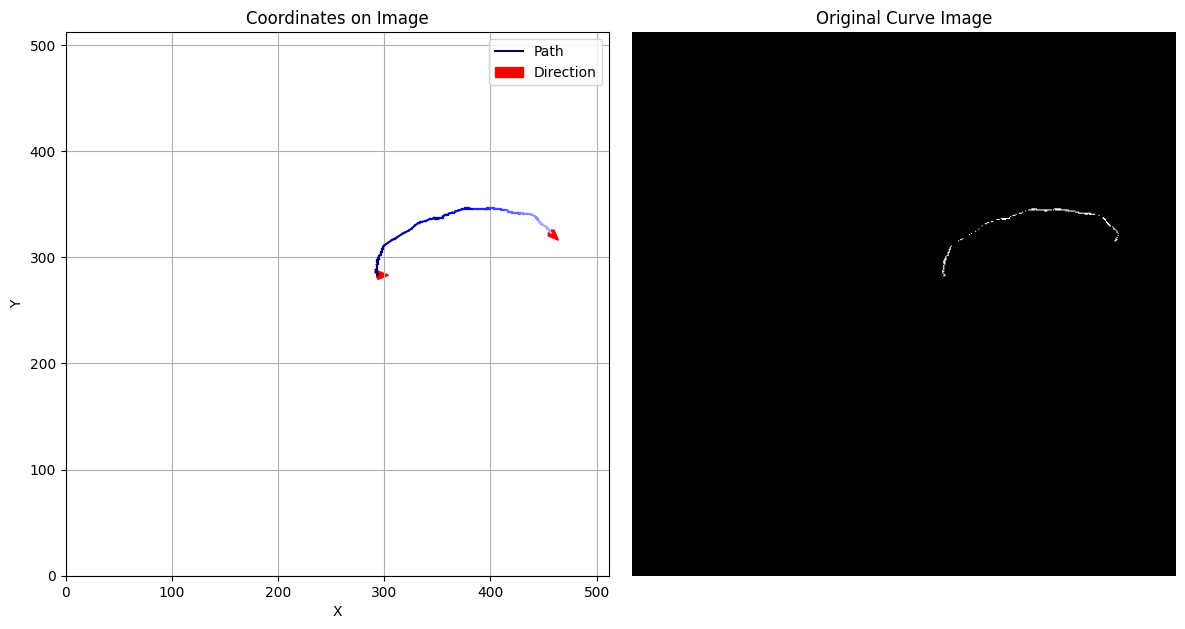

curves: 1


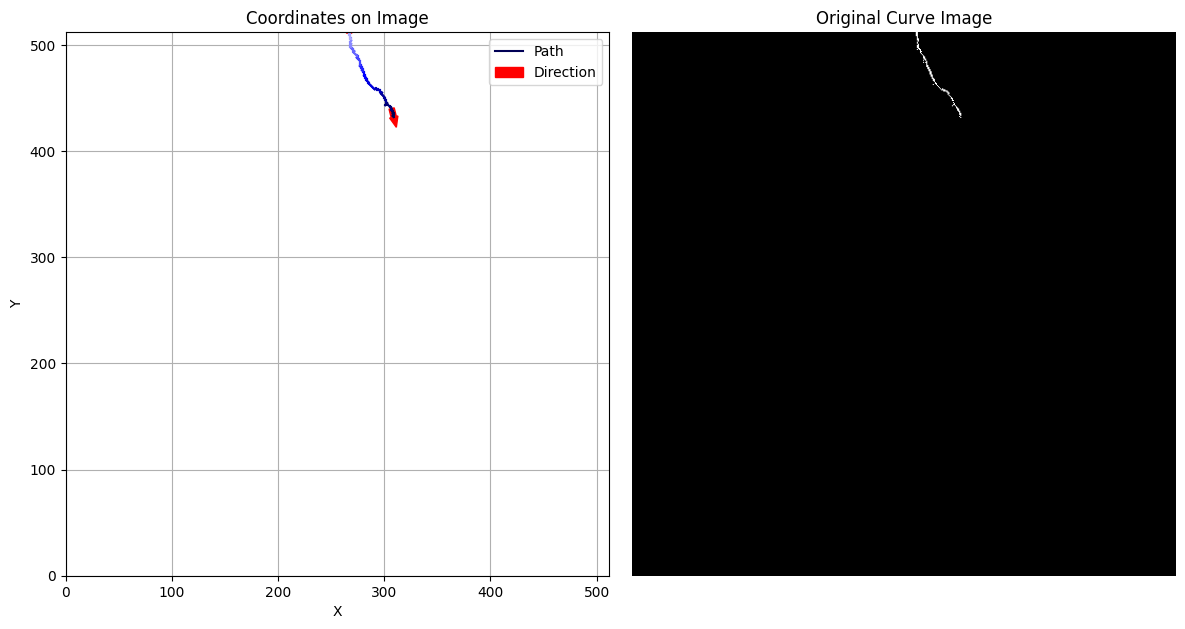

curves: 1


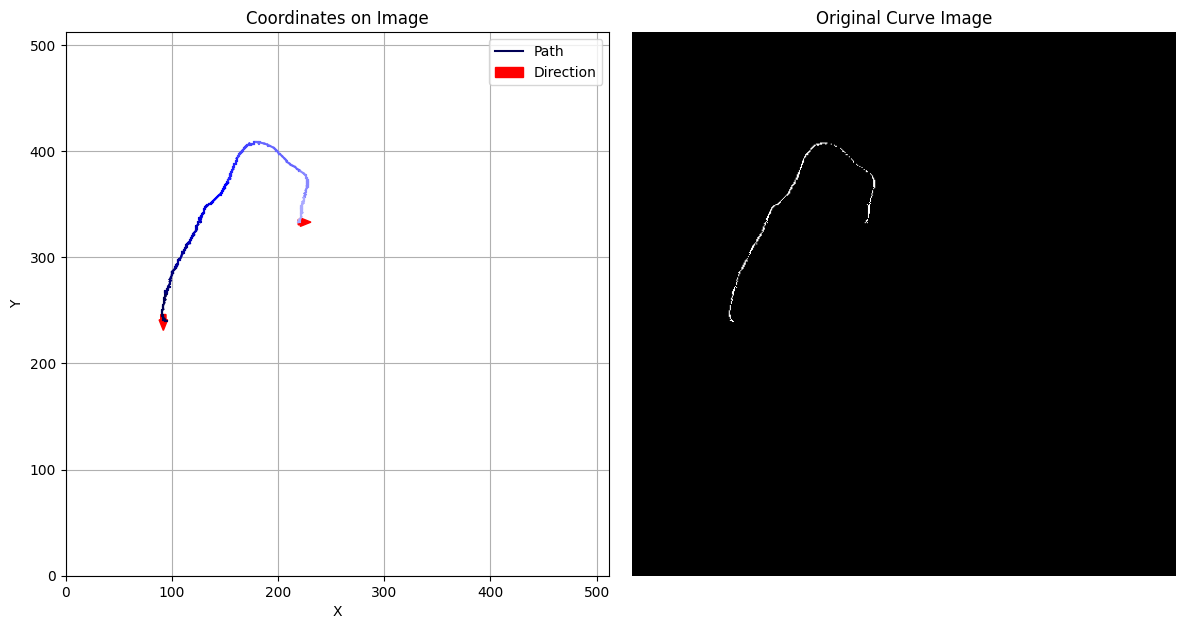

curves: 1


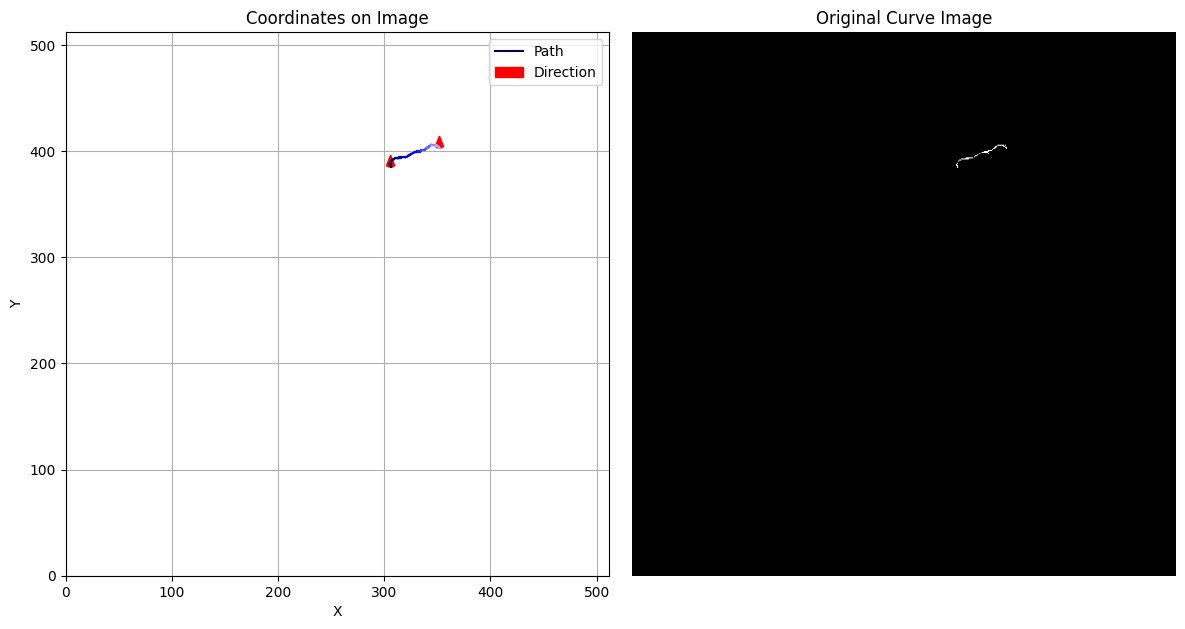

curves: 1


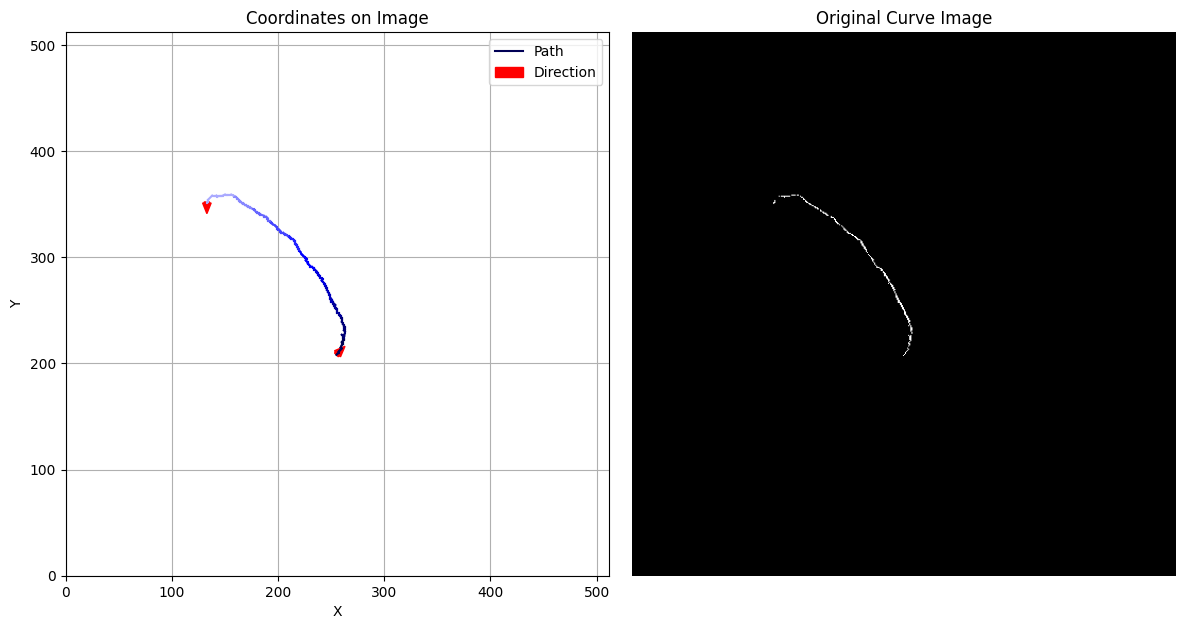

curves: 1


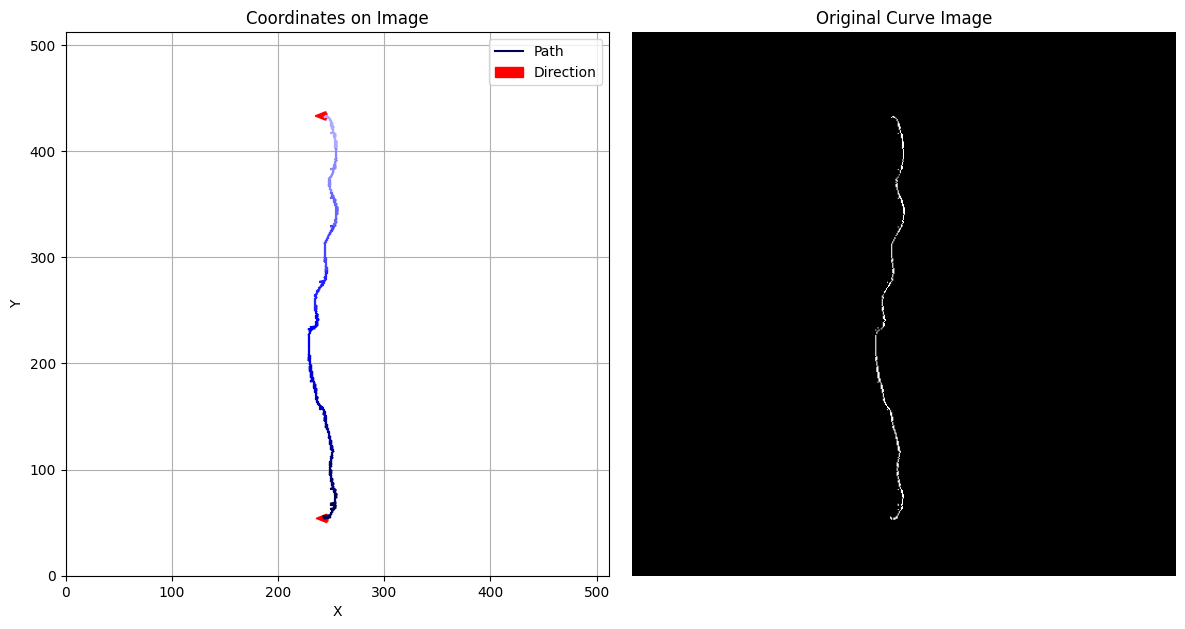

curves: 1


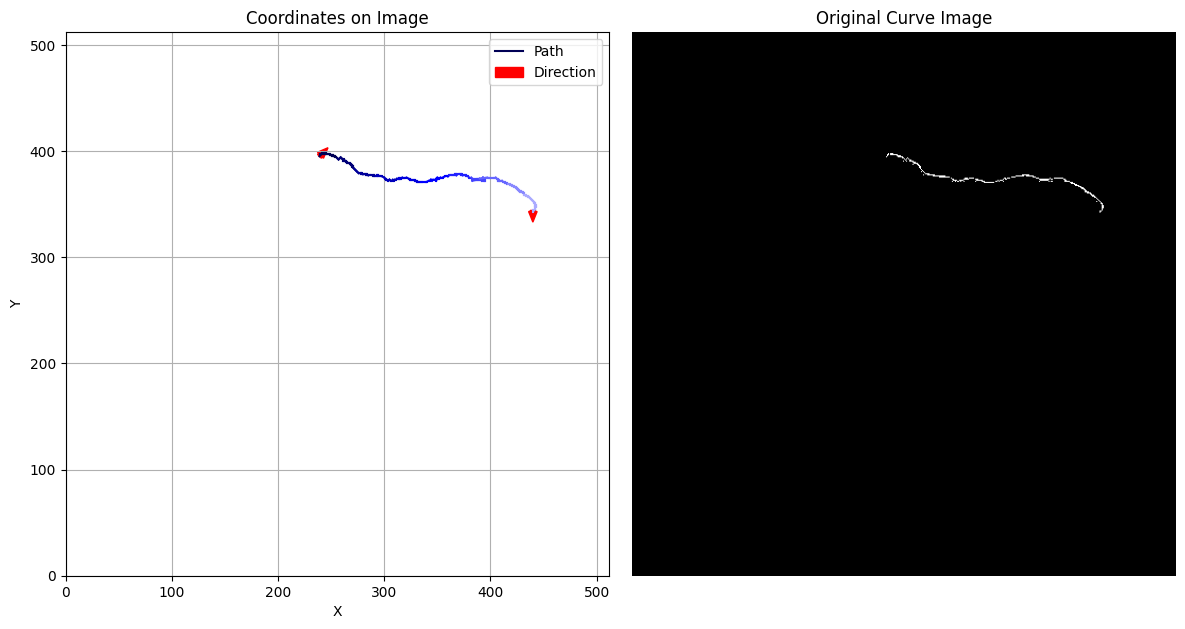

curves: 2


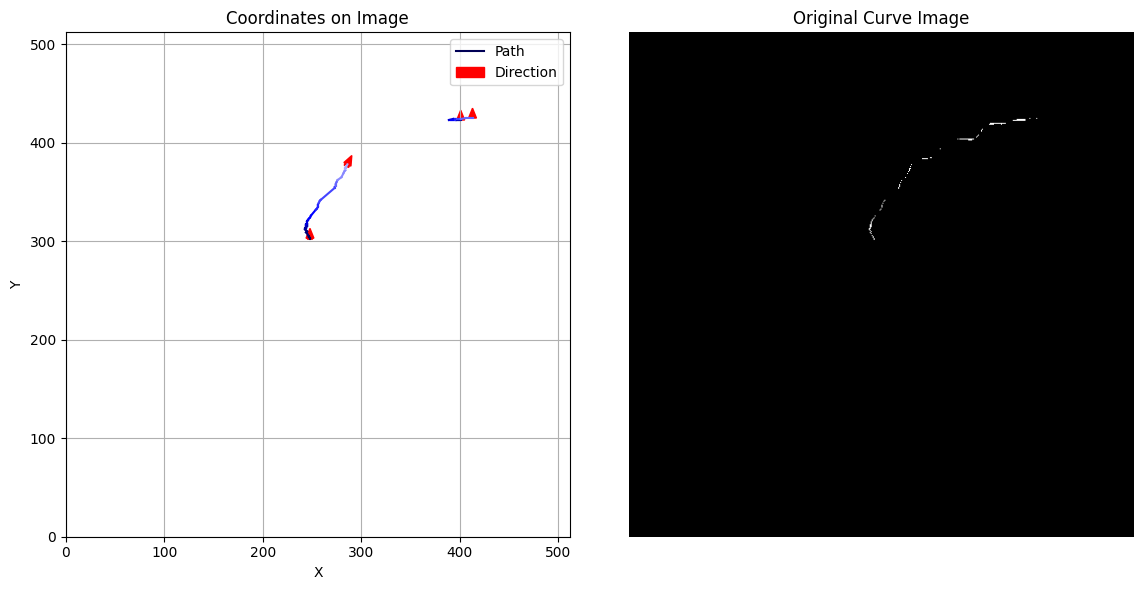

curves: 1


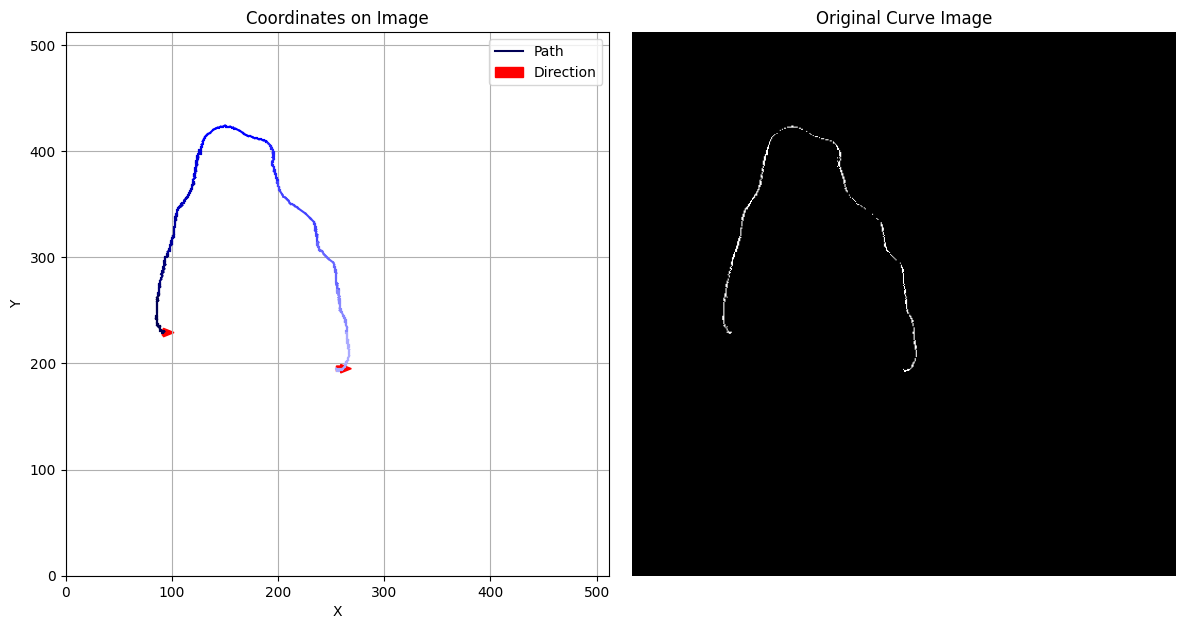

curves: 1


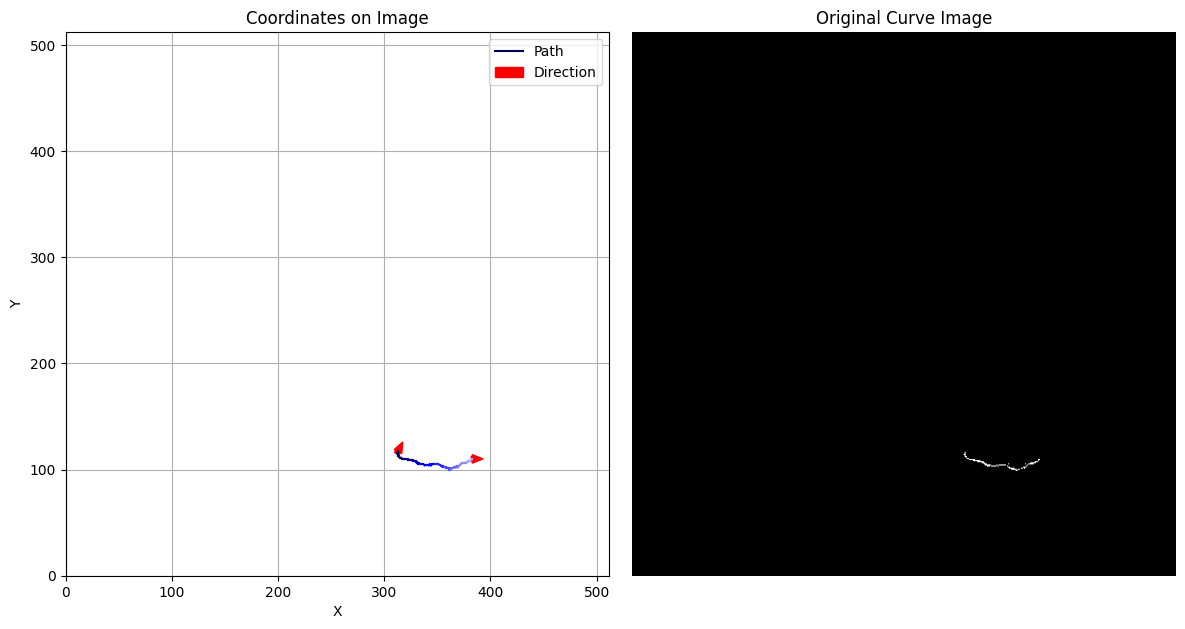

curves: 1


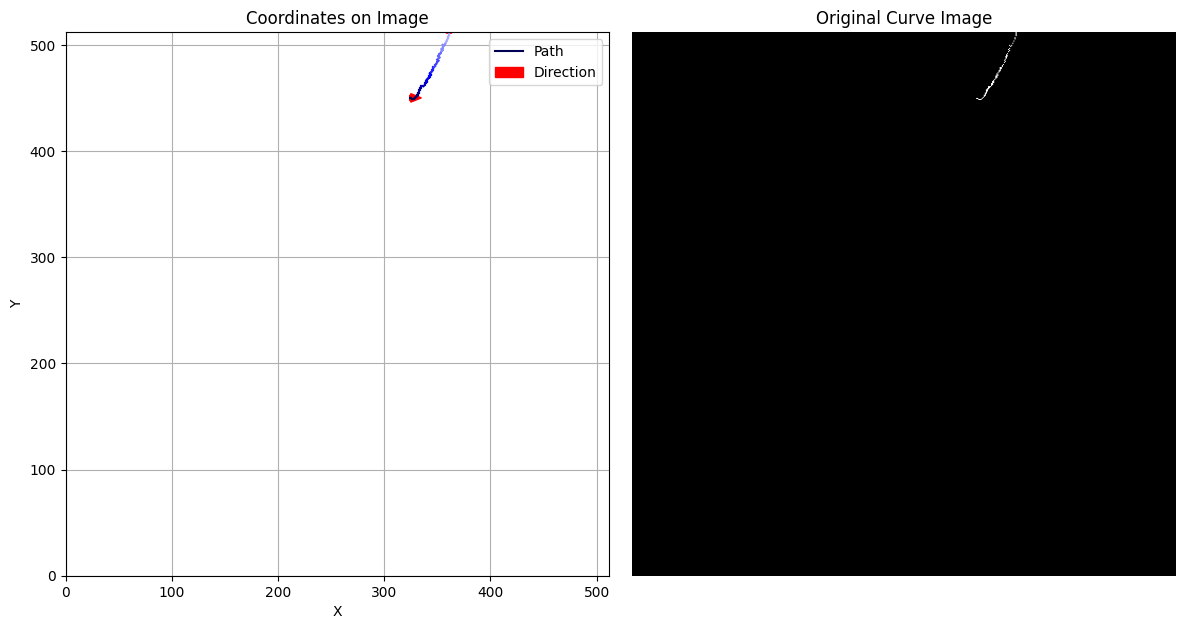

curves: 1


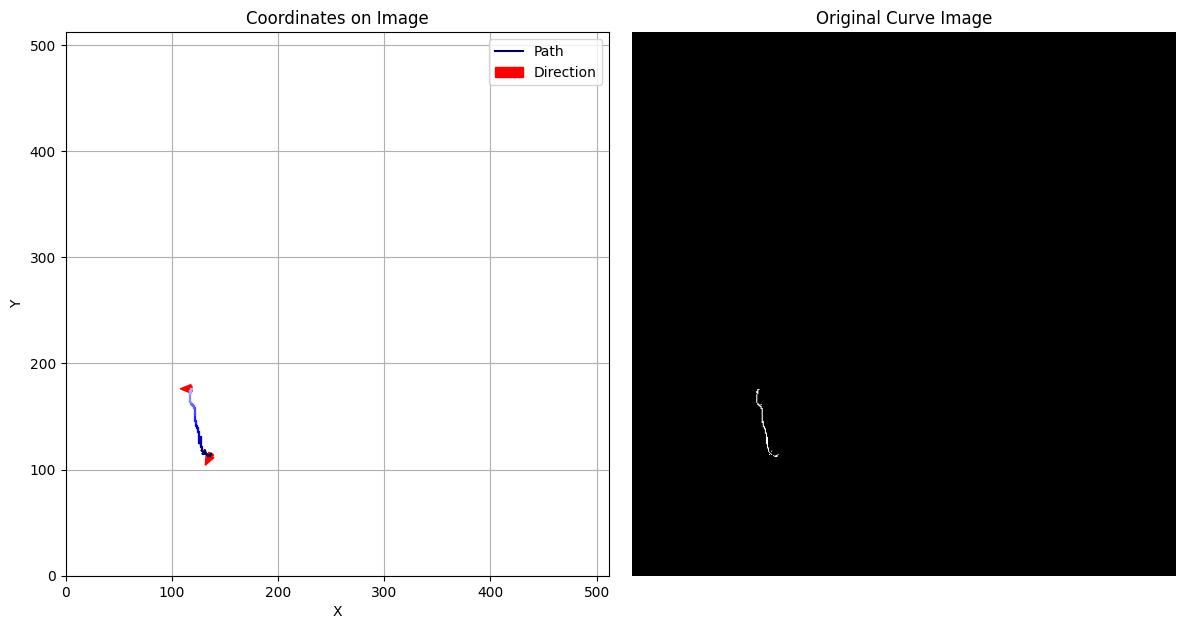

curves: 1


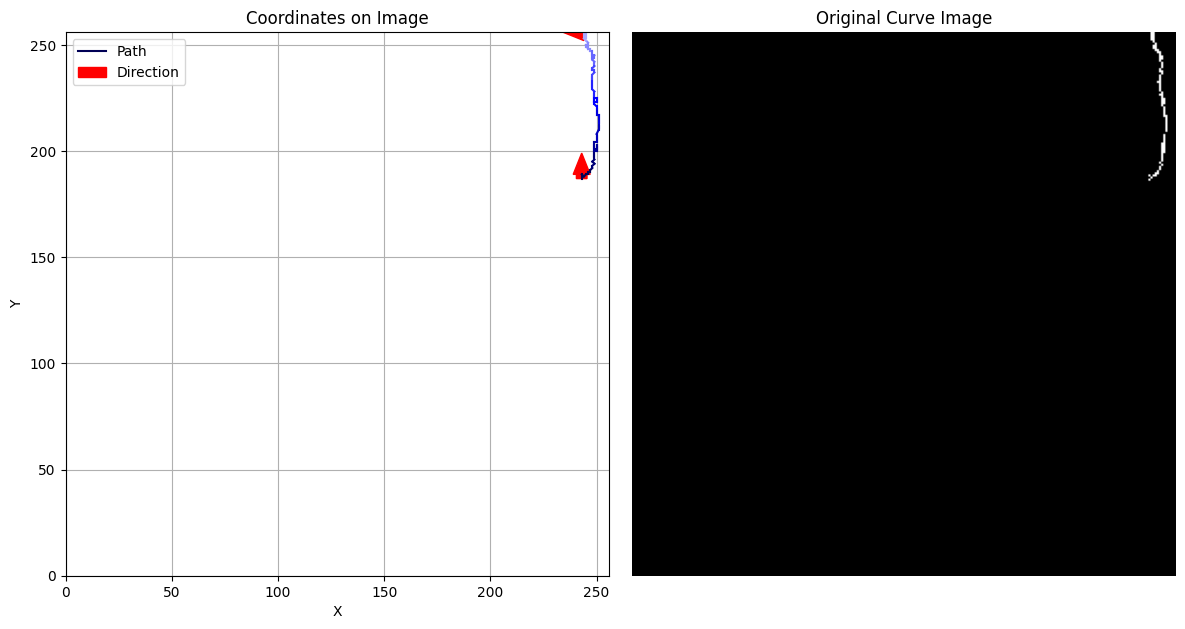

curves: 2


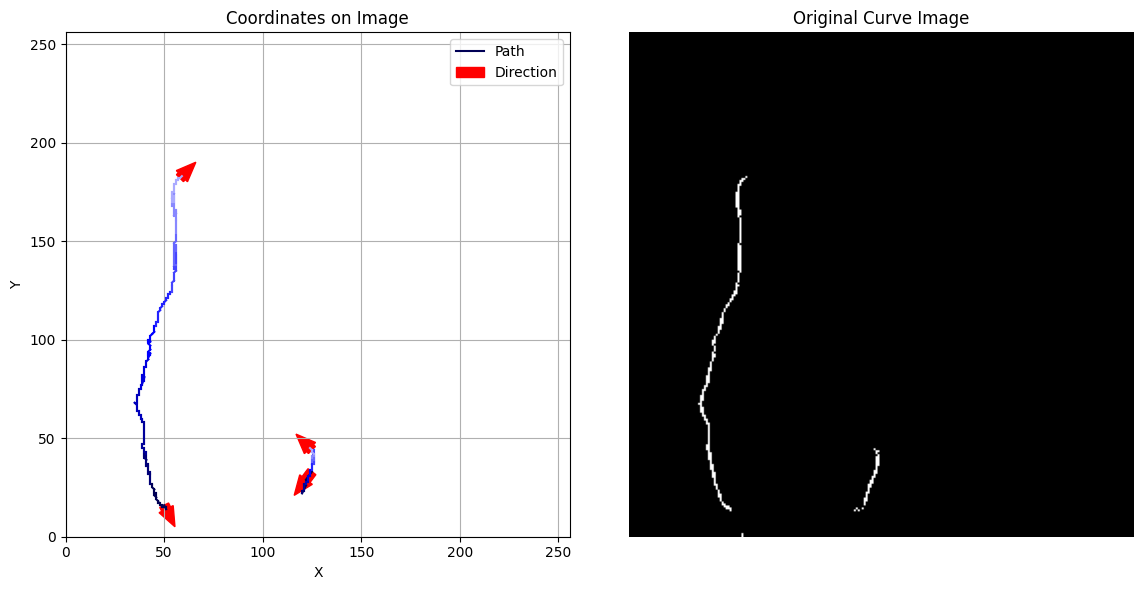

curves: 1


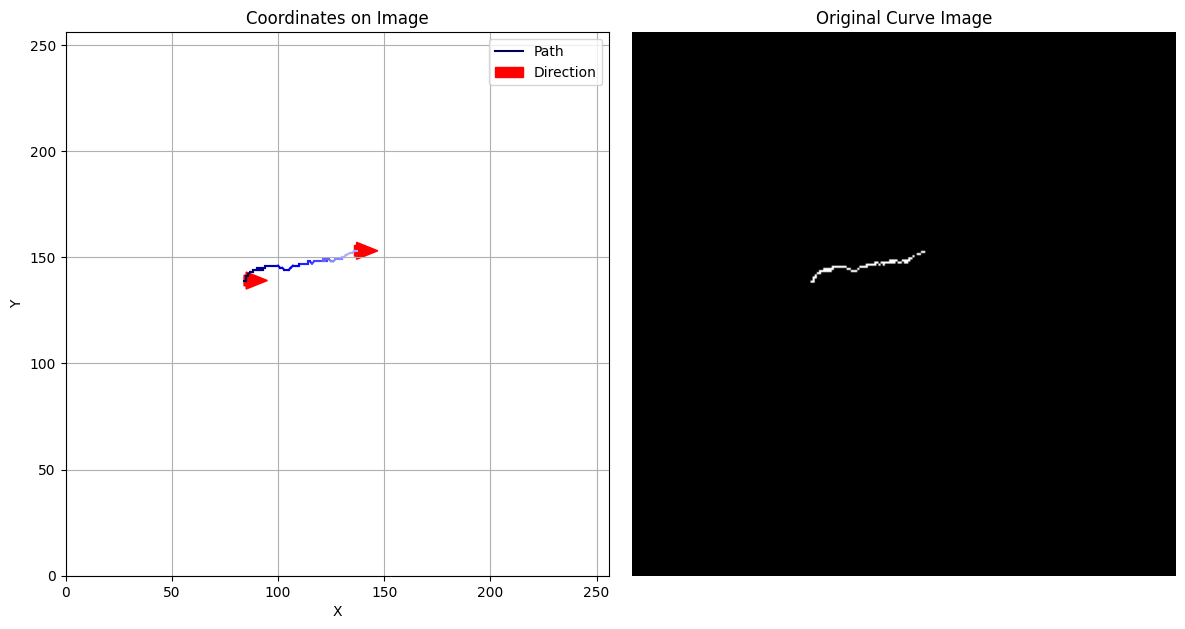

curves: 3


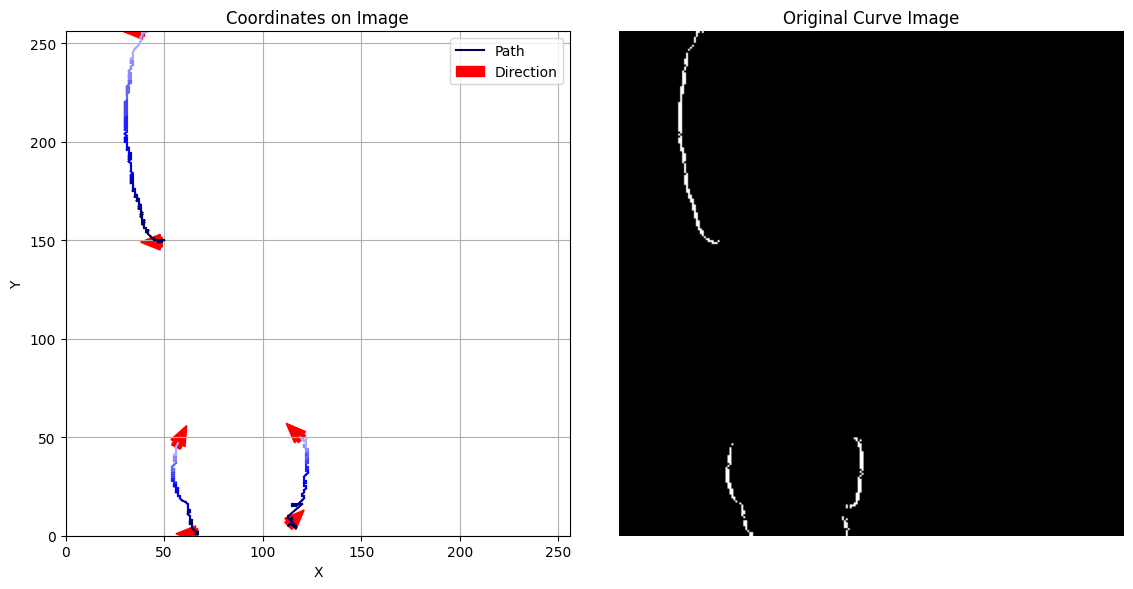

curves: 2


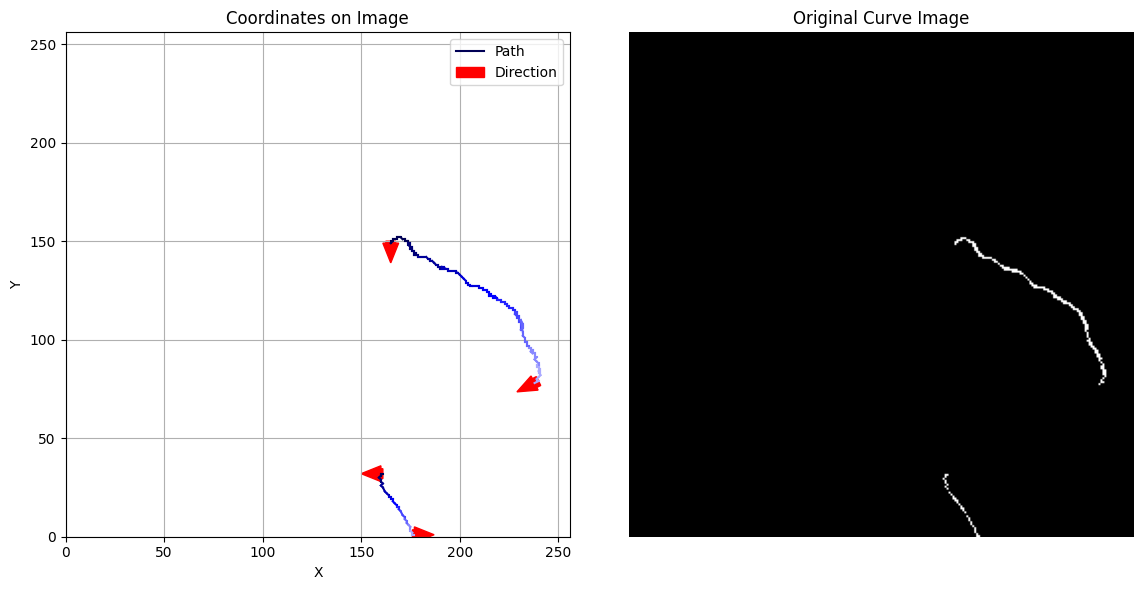

curves: 1


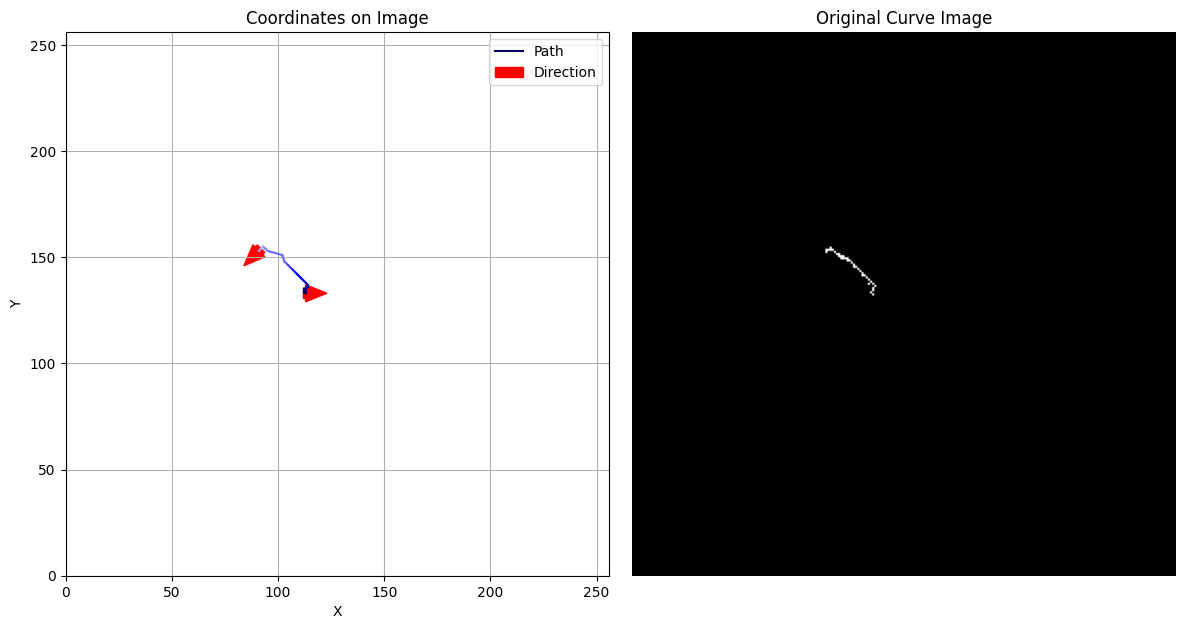

curves: 1


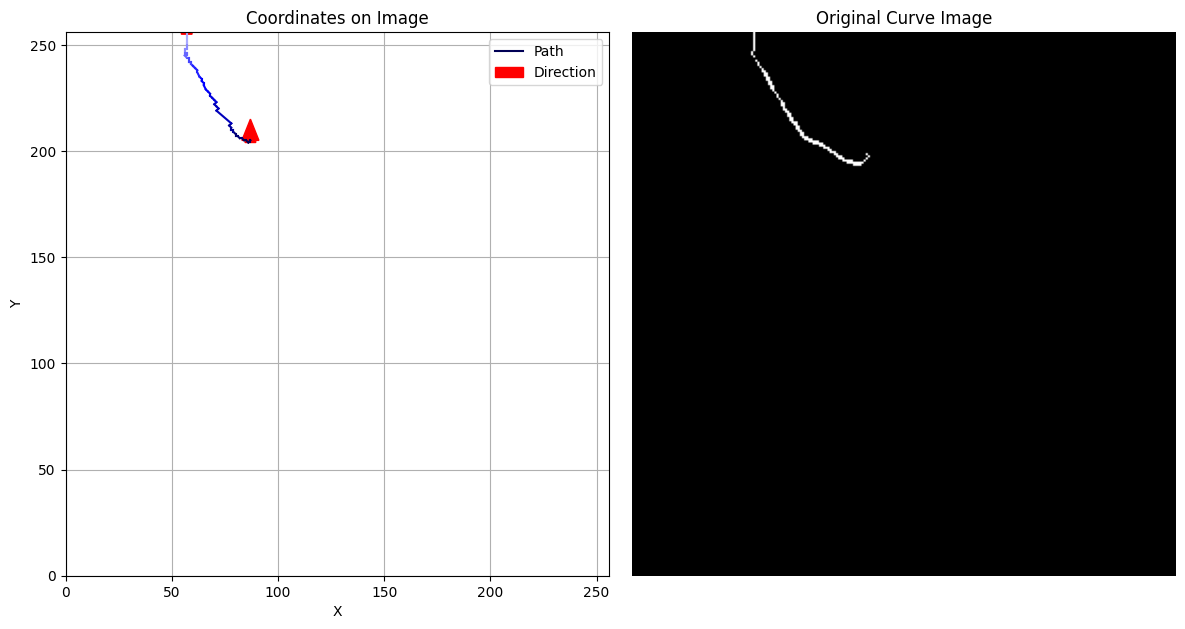

curves: 1


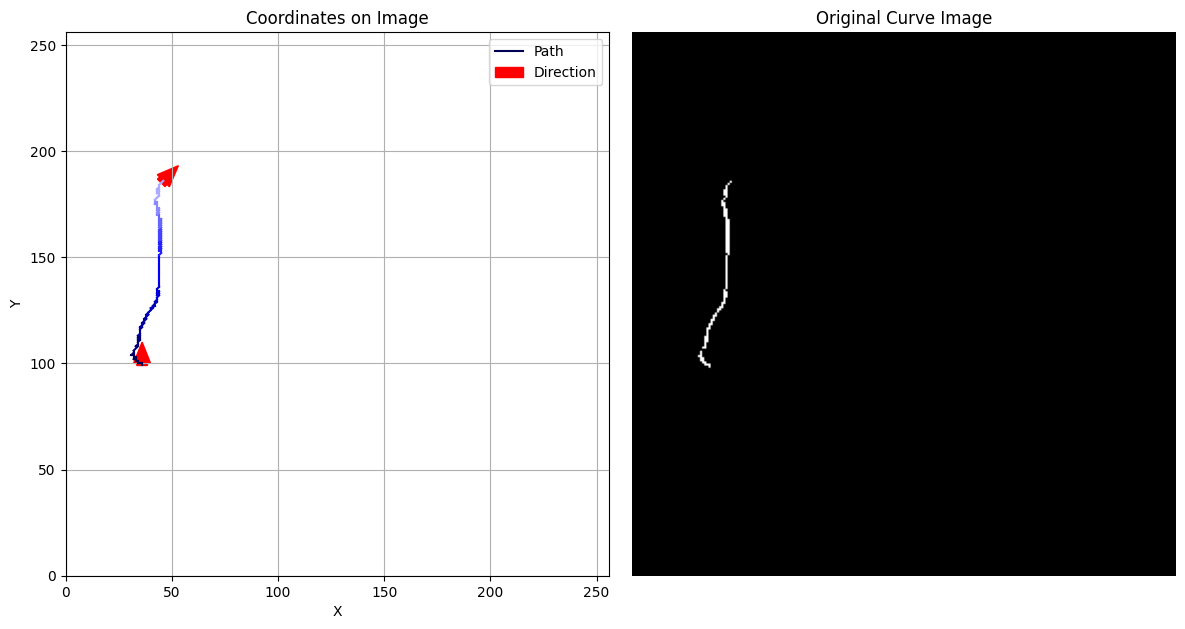

curves: 1


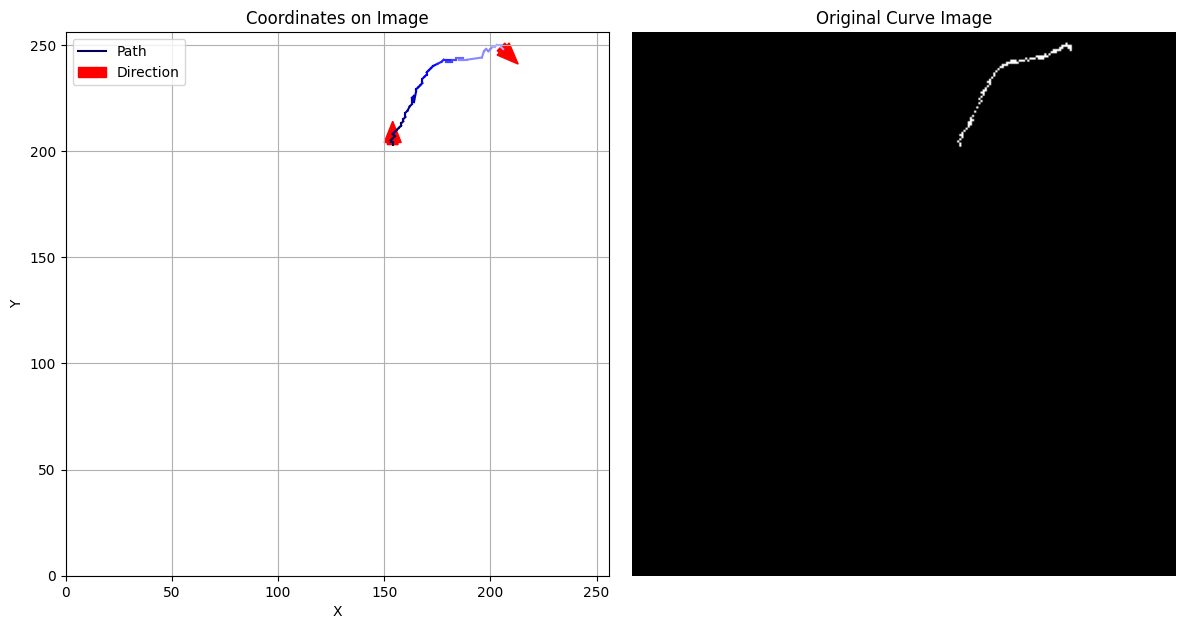

curves: 1


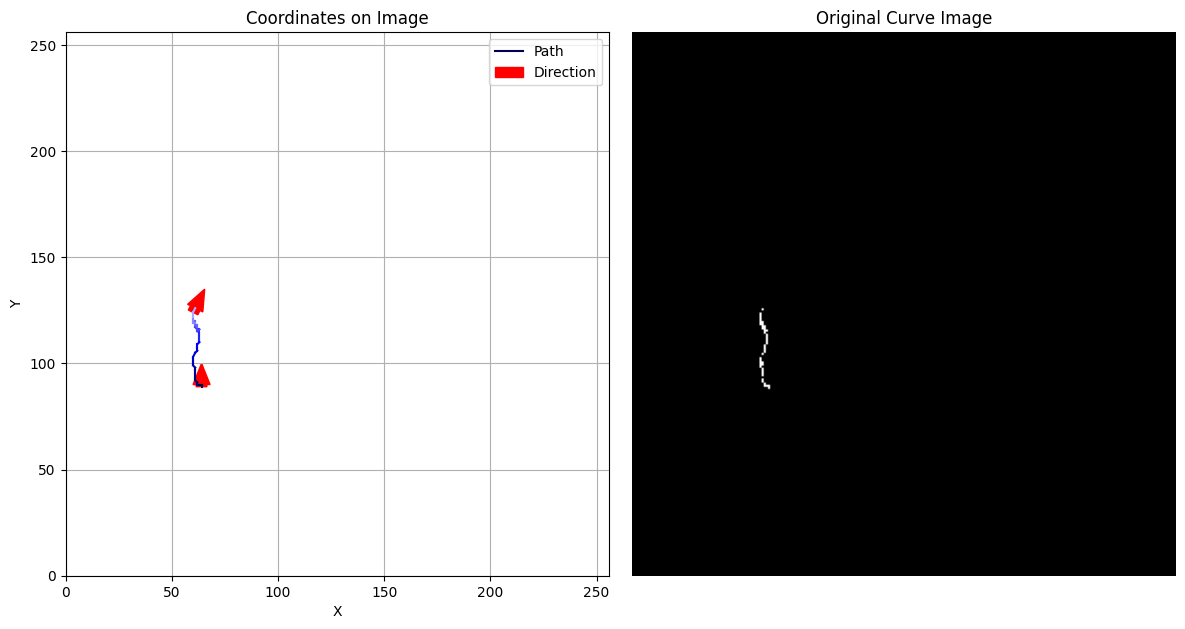

curves: 1


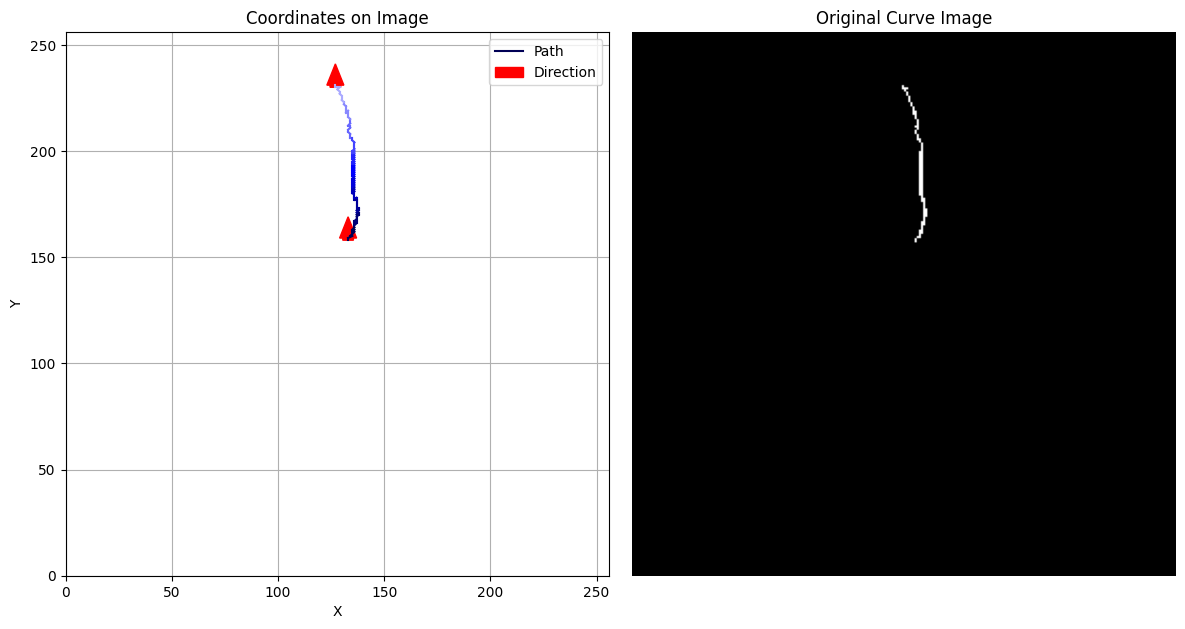

curves: 1


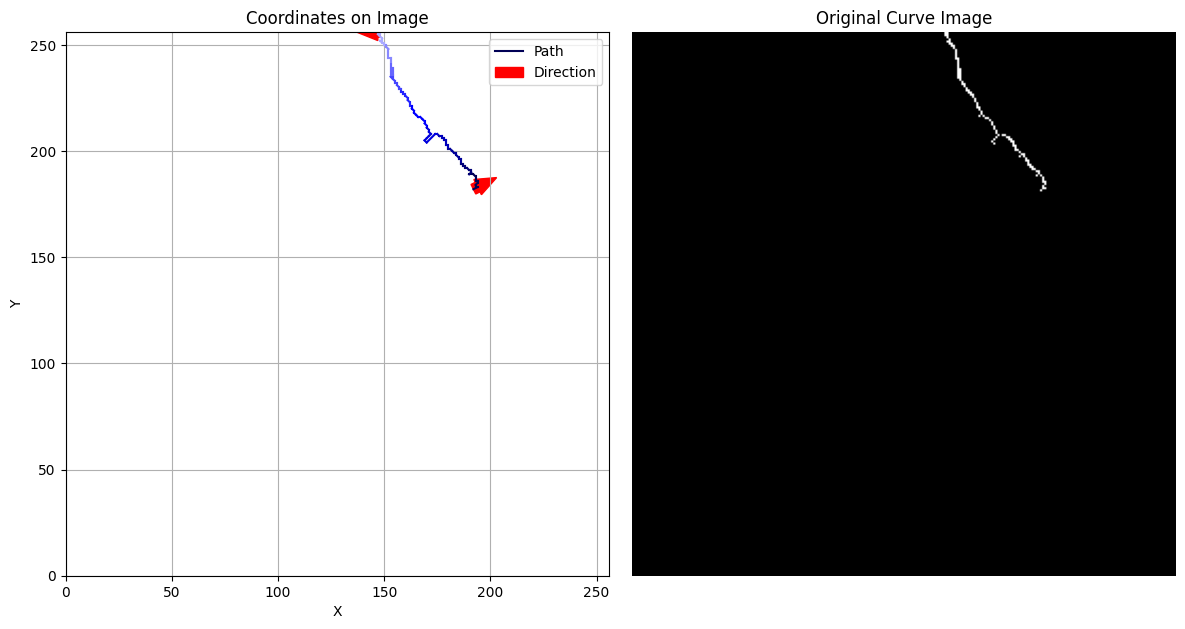

curves: 2


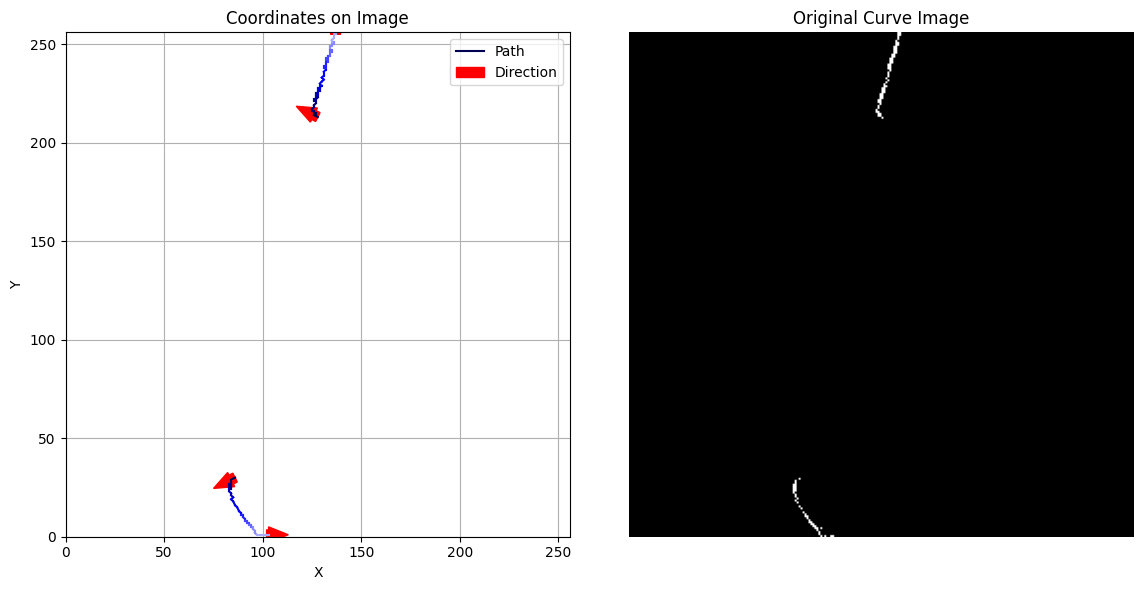

curves: 1


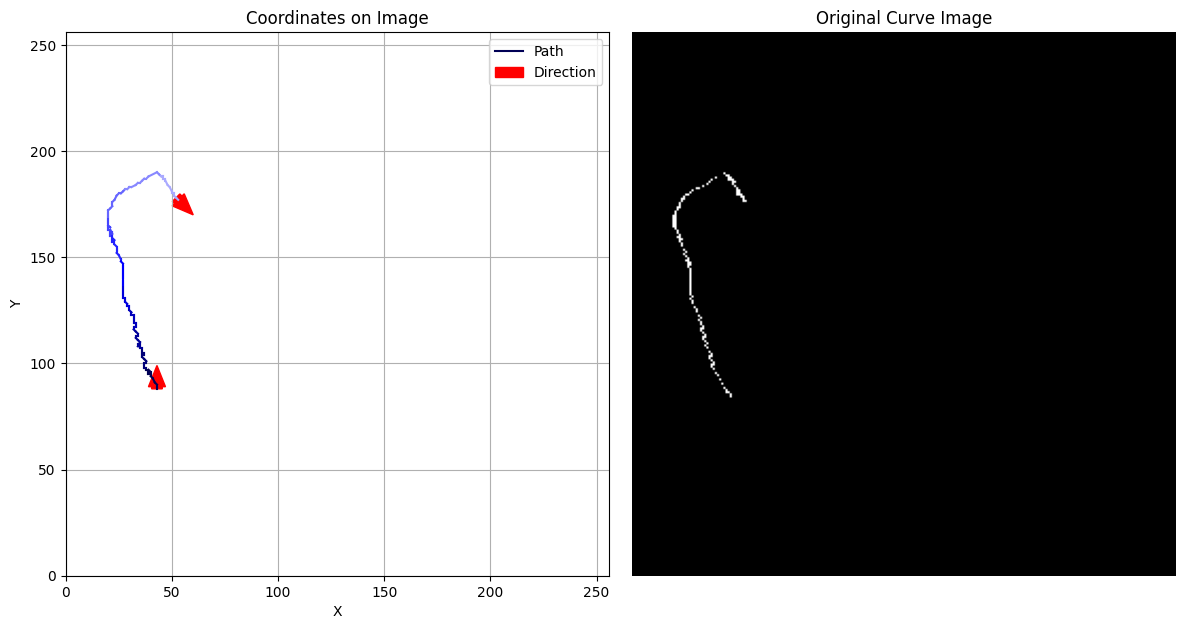

curves: 1


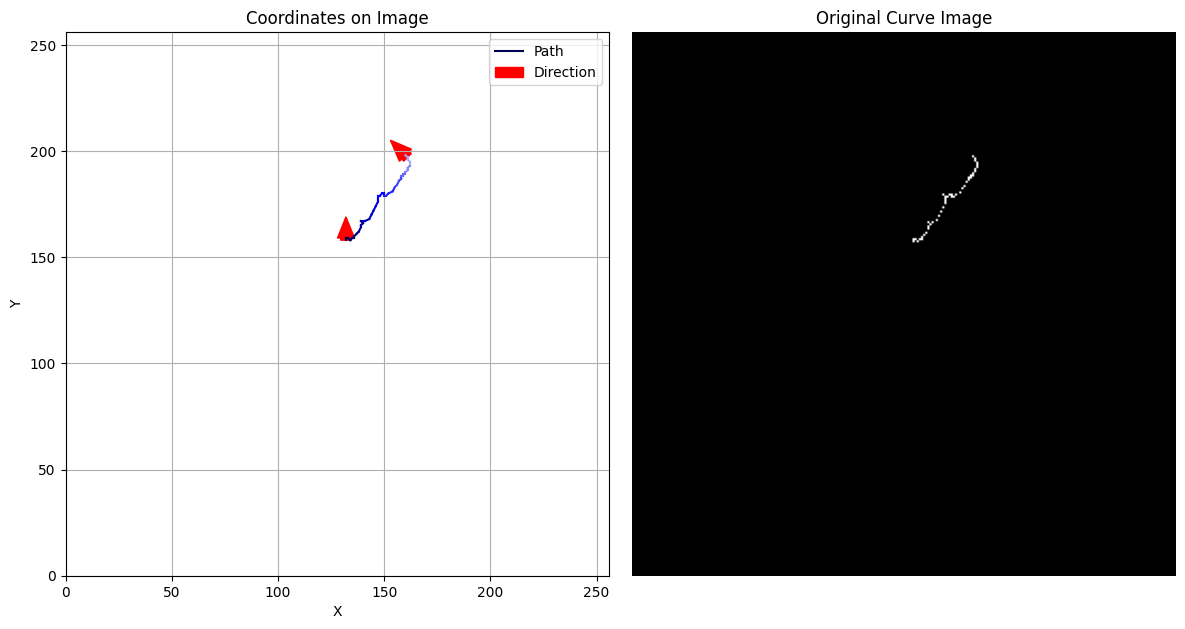

curves: 1


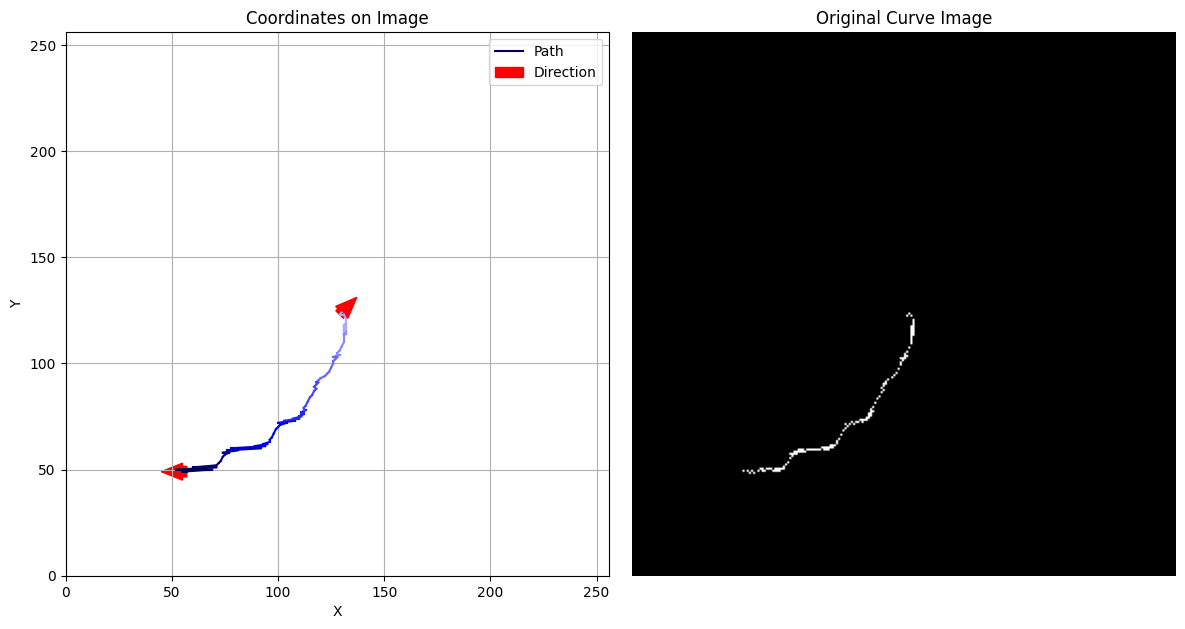

curves: 1


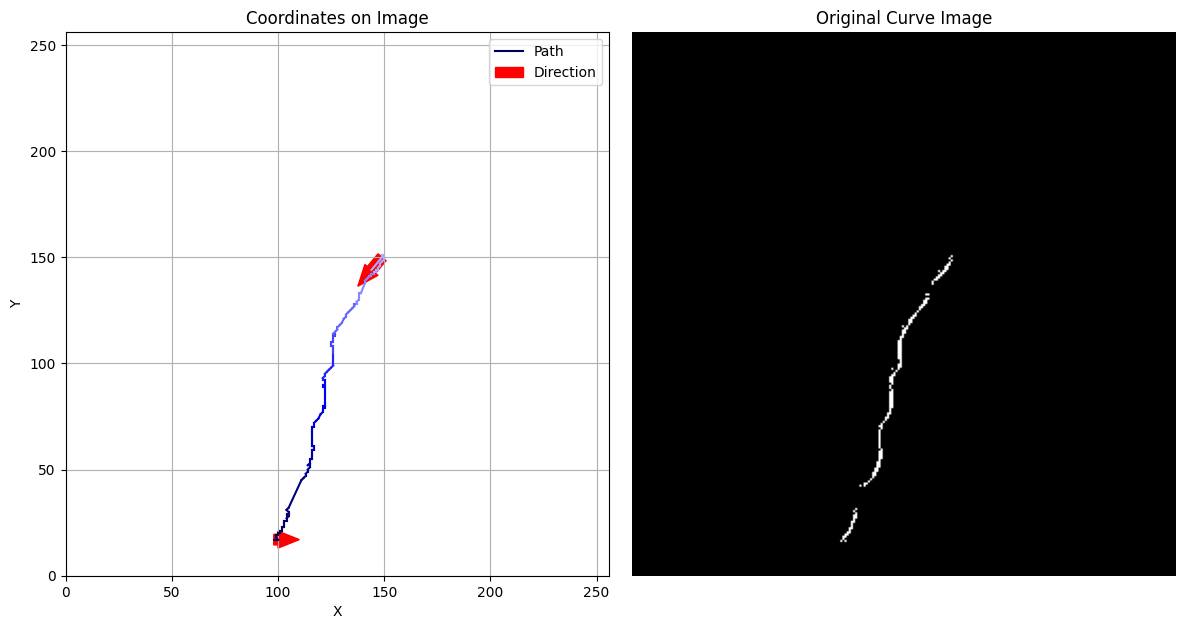

curves: 1


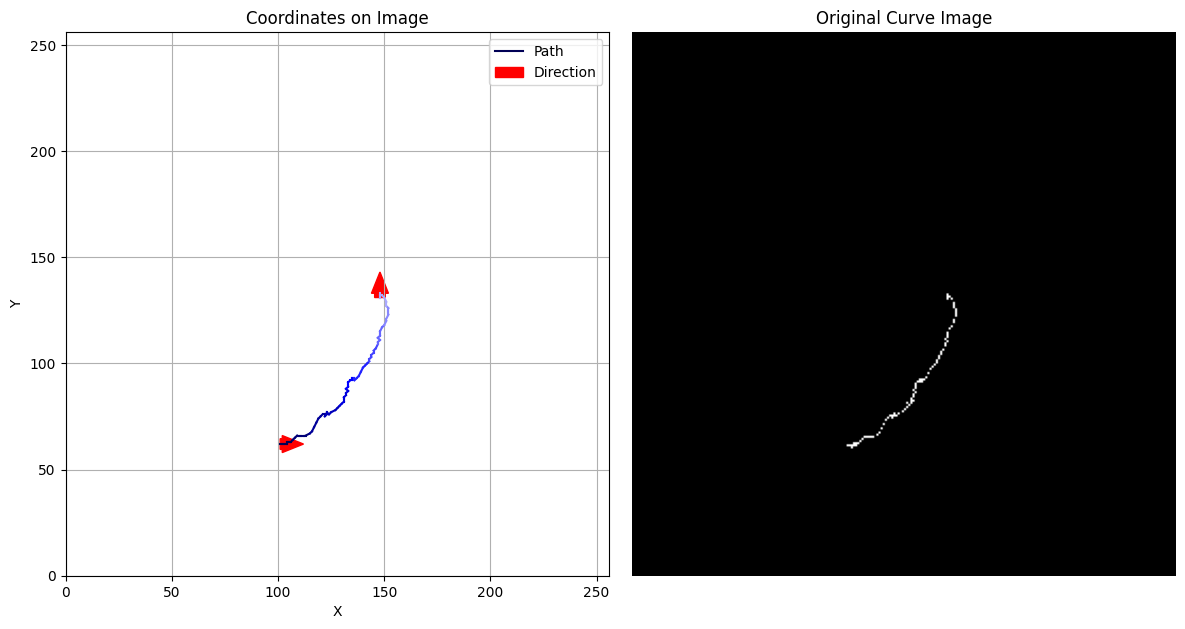

curves: 1


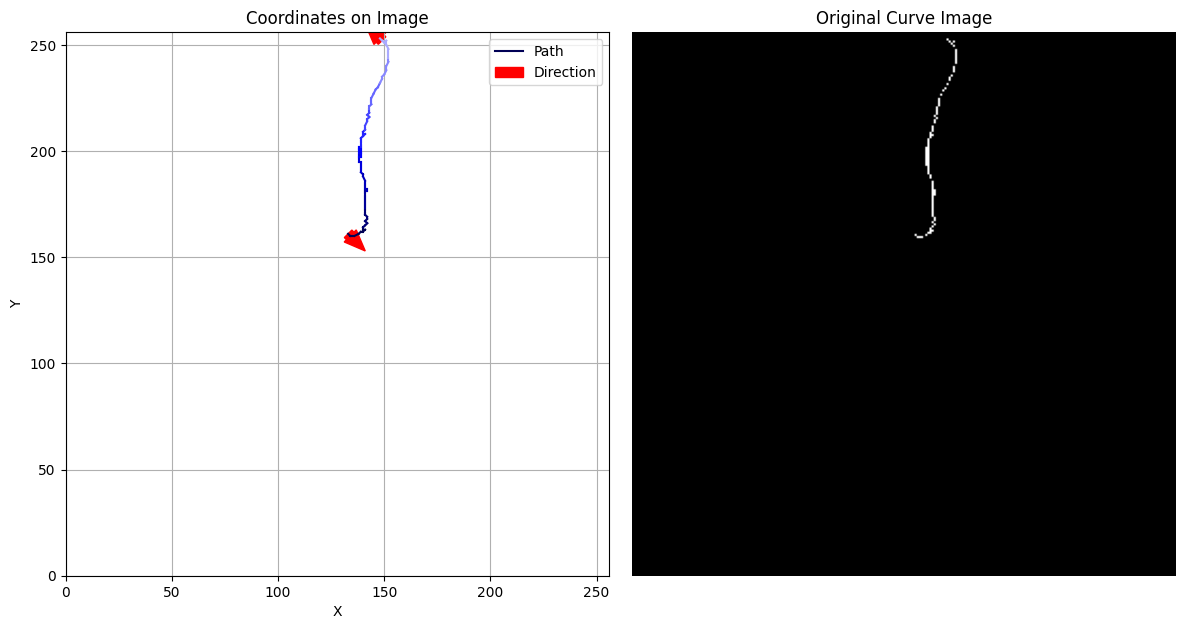

curves: 1


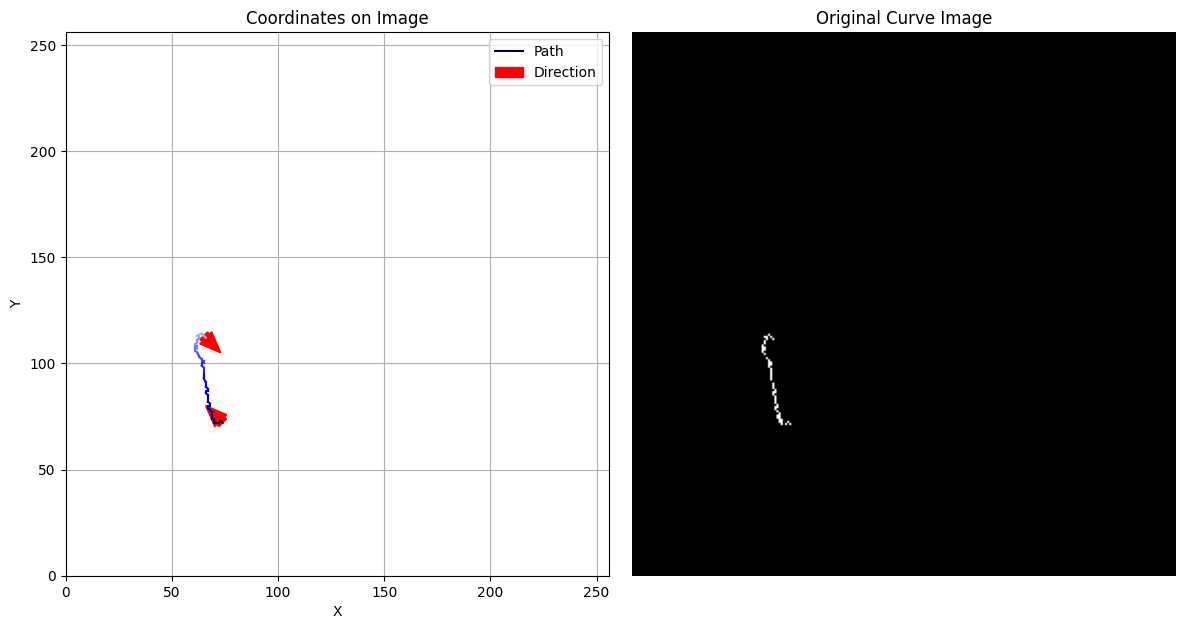

curves: 1


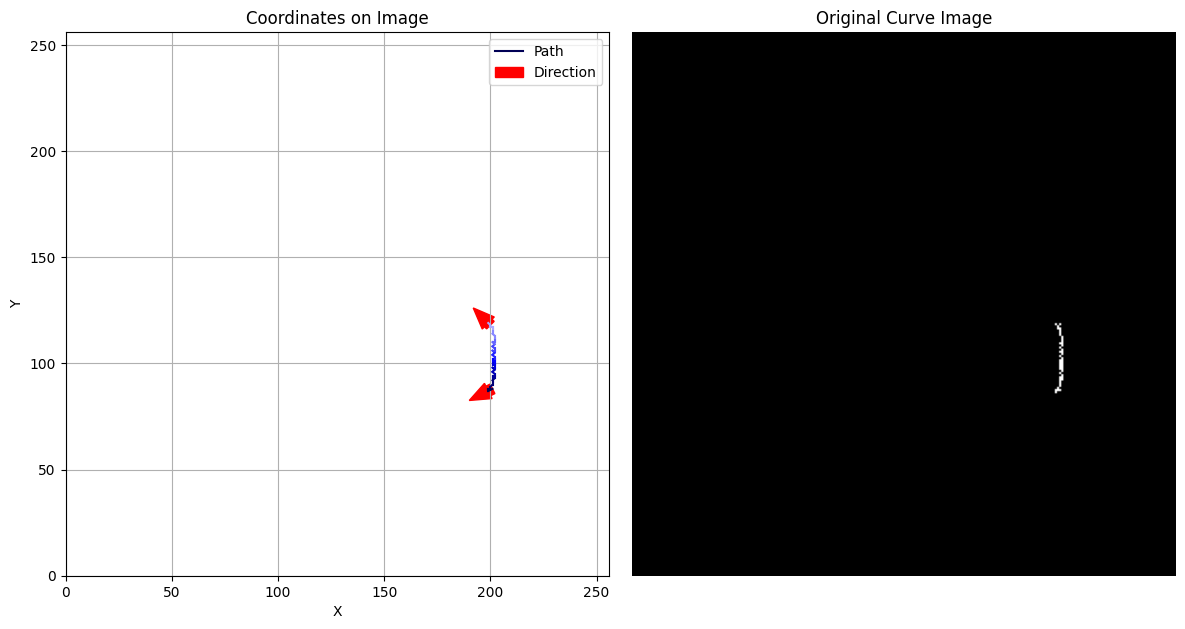

curves: 1


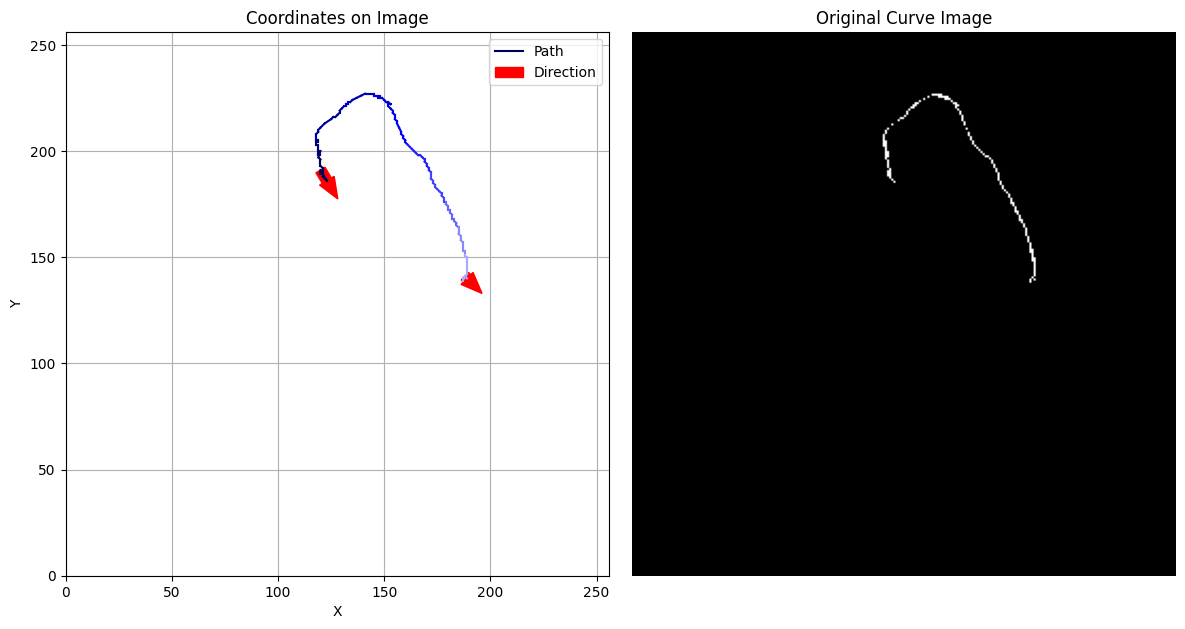

curves: 1


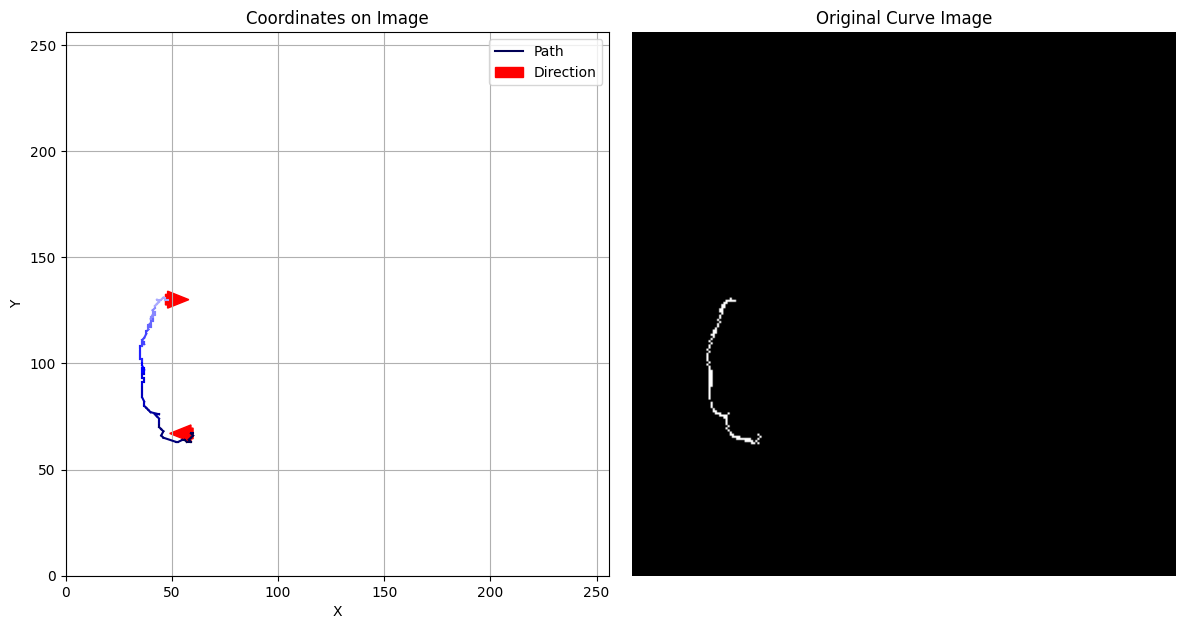

curves: 1


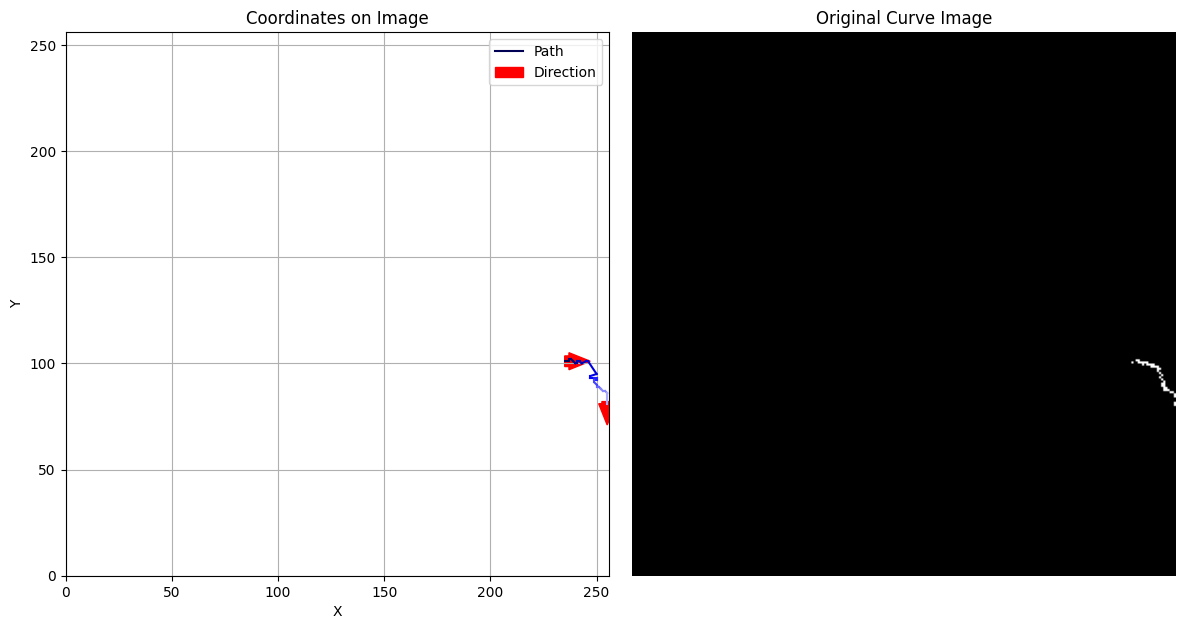

curves: 1


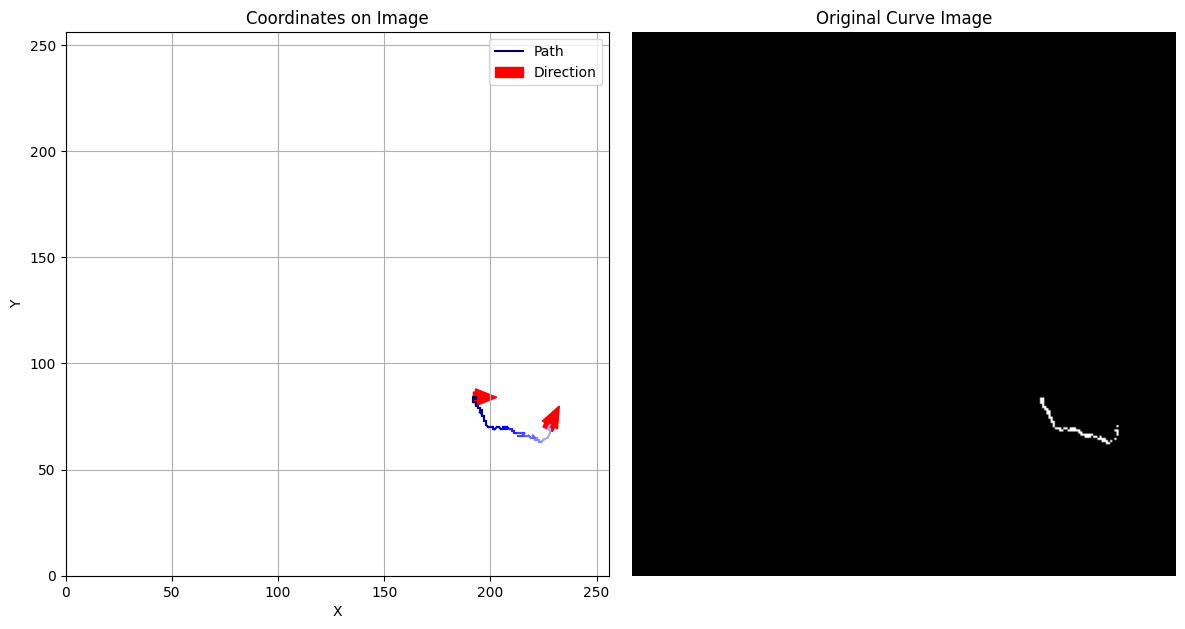

curves: 1


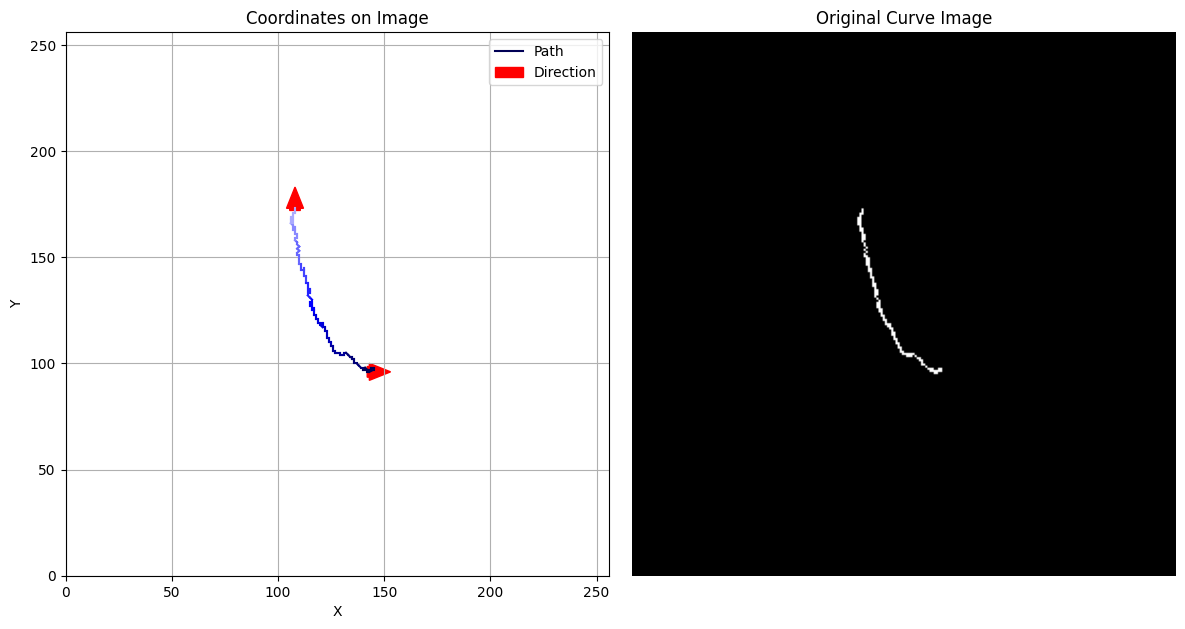

curves: 1


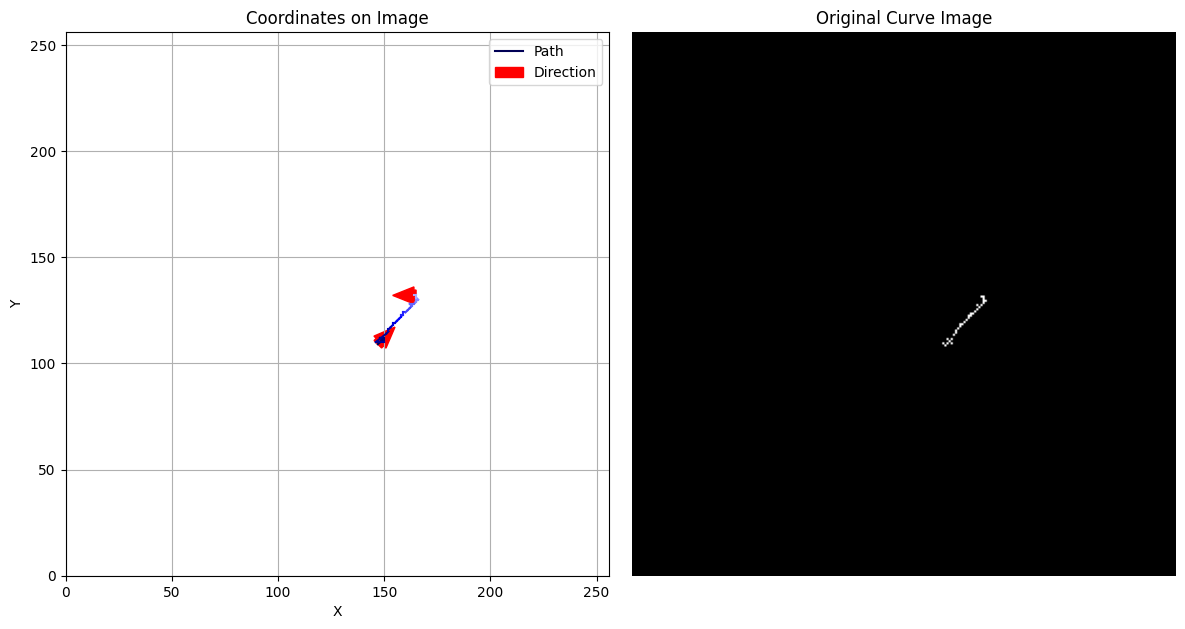

curves: 1


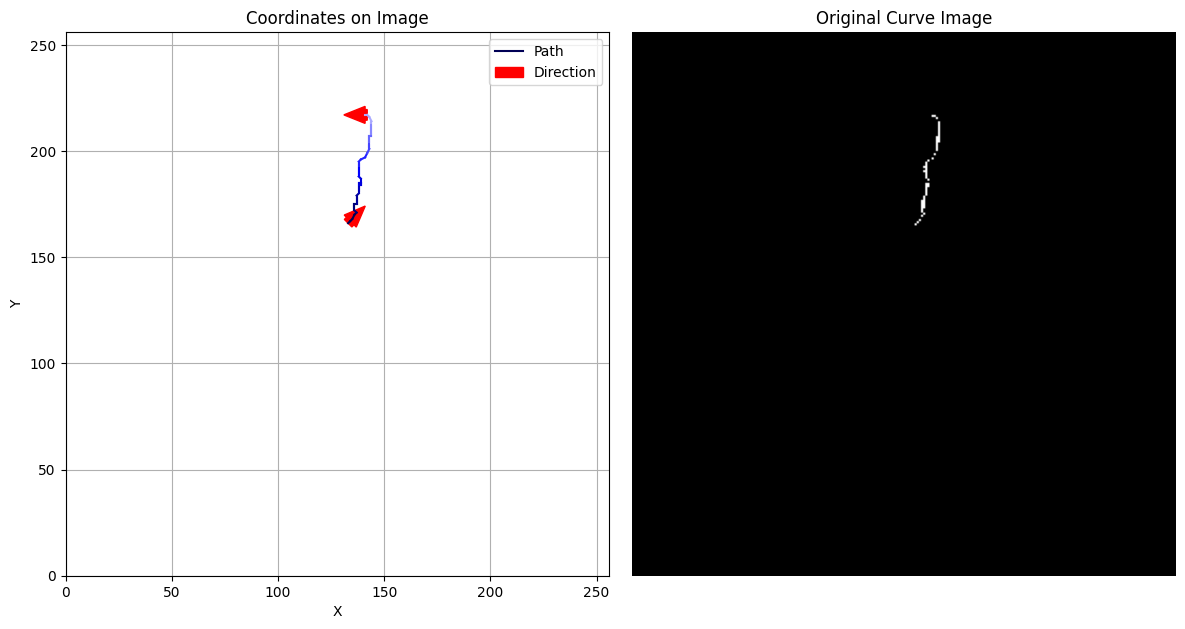

curves: 2


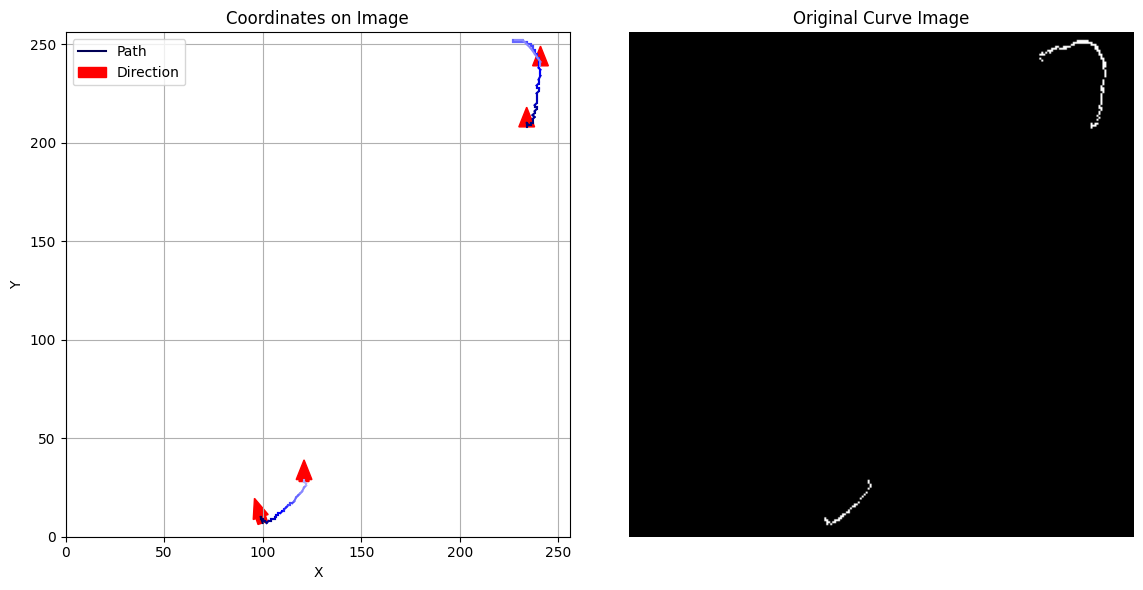

curves: 1


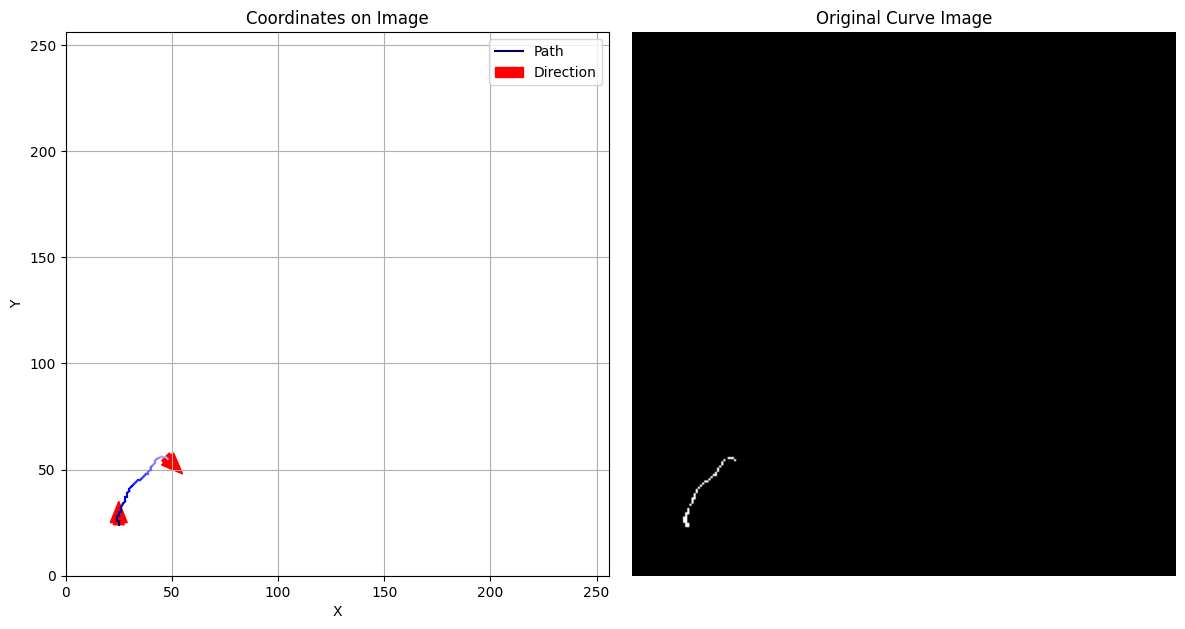

curves: 2


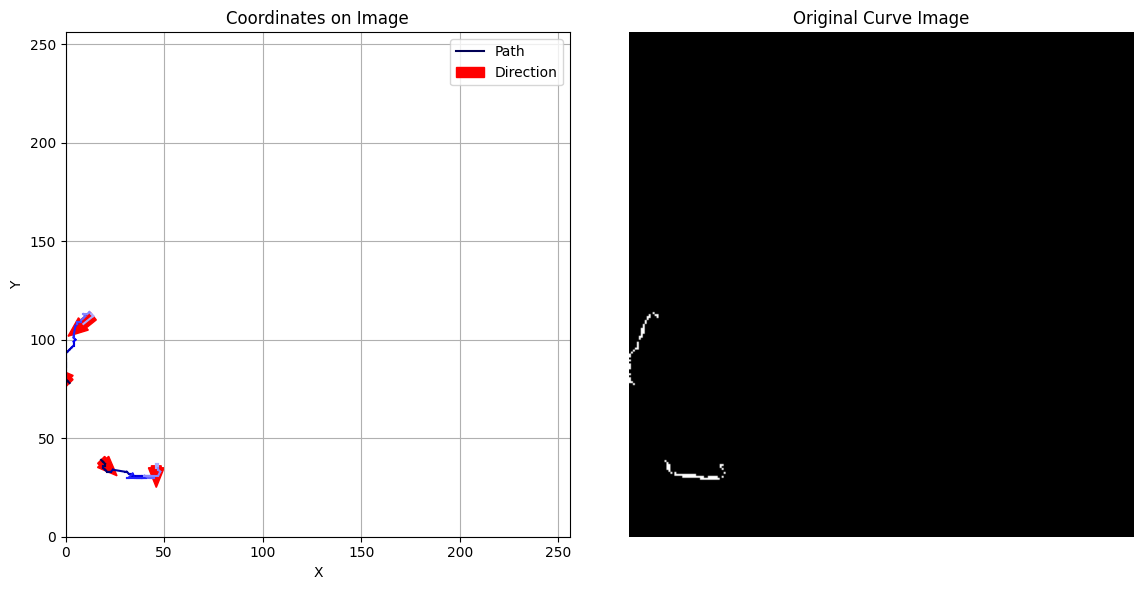

curves: 1


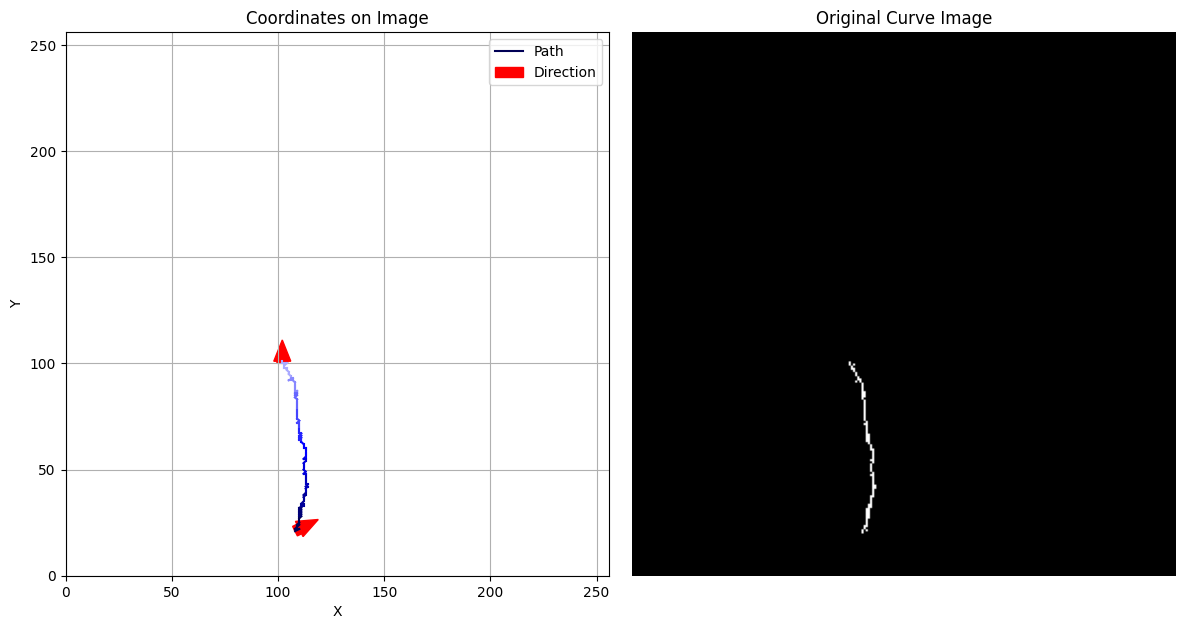

curves: 2


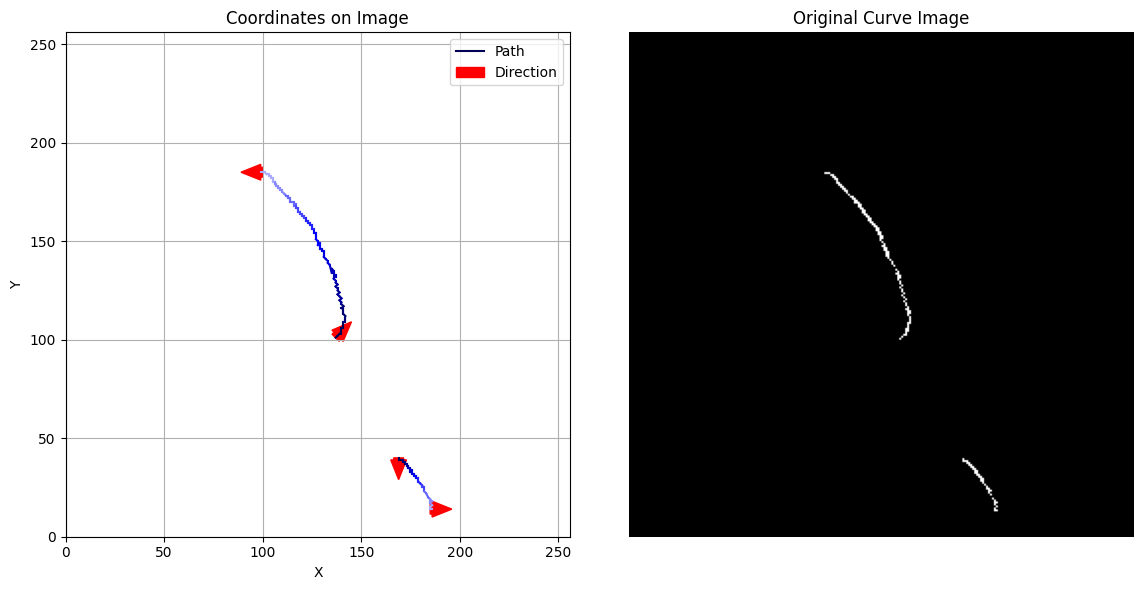

curves: 2


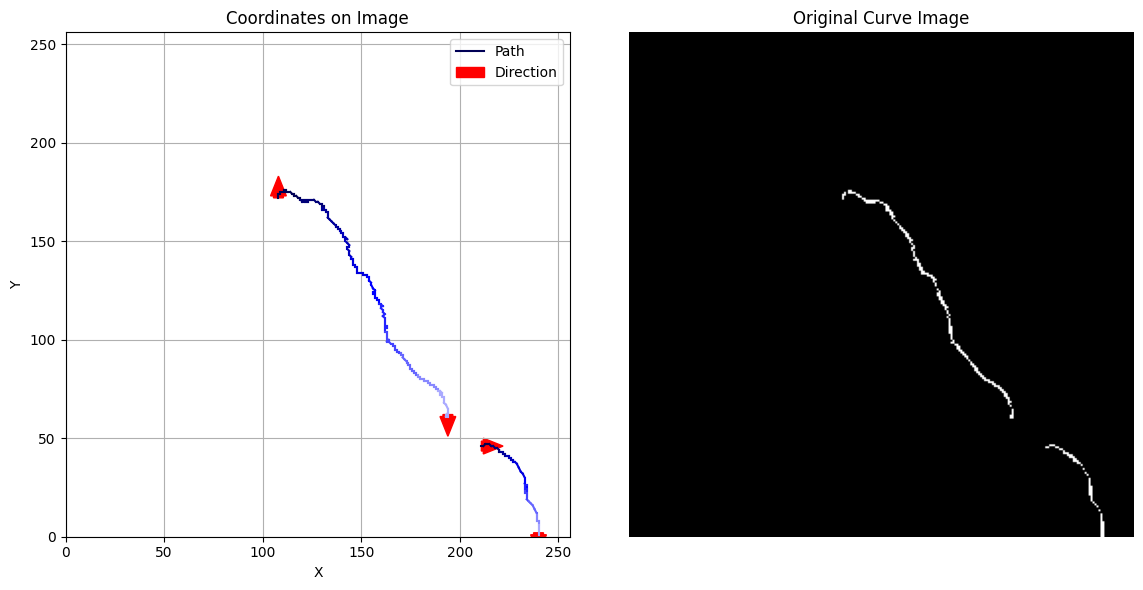

curves: 1


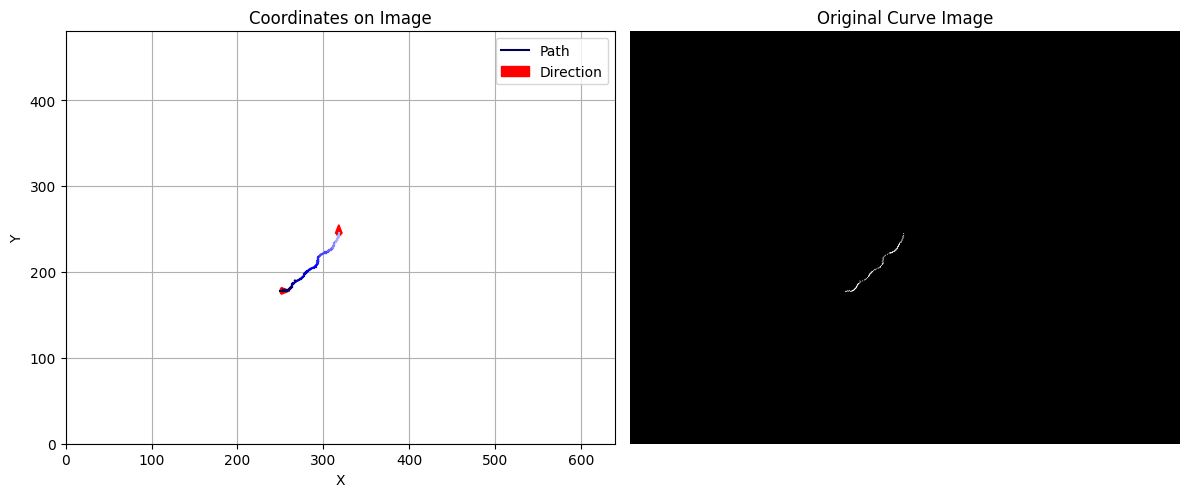

In [ ]:
# Plot the ordered paths with matplotlib
for i, image in enumerate(images):

    width, height, curve_coords = CAMIL.Map_image(image)
    plot_coordinates(image, width, height, curve_coords)

## Comparison with common interpolations methods
Used for comparison

#### Spline interpolating function

In [ ]:
from scipy.interpolate import splprep, splev

def interpolate_curve(curve_img):
    binary_img = CAMIL.convert_to_binary(curve_img) # convert input image to bin
    binary_image = CAMIL.skeletonize(binary_img) # thin the curve in the image to have approx. 1 pixel thickness
    # Find white pixel coordinates
    white_pixels = np.argwhere(binary_image == 255) # ordered from top left corner to bottom right corner of image
    cont_pixels = np.array(CAMIL.extract_contour_pixels(binary_img.copy())) # ordered intrinsically from the cv2 contour logic

    # Separate x and y coordinates
    x_coords = white_pixels[:, 1]
    y_coords = white_pixels[:, 0]
    x_cont = cont_pixels[:len(cont_pixels)//2, 0] #(take half of it since the contour is a closed curve)
    y_cont = cont_pixels[:len(cont_pixels)//2, 1]

    # Perform spline interpolation
    # with white pix
    tck, _ = splprep([x_coords, y_coords], k=3, s=0)
    interpolated_curve = splev(np.linspace(0, 1, len(white_pixels)), tck)
    # with cont pix
    tck, _ = splprep([x_cont, y_cont], k=3, s=0)
    interpolated_curve_cont = splev(np.linspace(0, 1, len(cont_pixels)), tck)

    # Convert interpolated curve for white pix to list of (x, y) coordinates
    interpolated_curve_coords = [(int(round(x)), int(round(y))) for x, y in zip(interpolated_curve[0], interpolated_curve[1])]
    # Convert interpolated curve for cont pix to list of (x, y) coordinates
    interpolated_curve_cont_coords = [(int(round(x)), int(round(y))) for x, y in zip(interpolated_curve_cont[0], interpolated_curve_cont[1])]

    return interpolated_curve_coords, interpolated_curve_cont_coords

#### Plotting and comparison functions

In [ ]:
def plot_interp(image, img_width, img_height, spline_coords, spl_coords_cont, camil_curves_coords, camil_curves_coords_cont, plot_camil_cont = False):
    if plot_camil_cont:
        # Create subplots with 1 row and 5 columns
        fig, axs = plt.subplots(1, 5, figsize=(30, 6))

        # Flip the y-axis to match image coordinates
        spline_coords = [(x, img_height - y) for x, y in spline_coords]
        spline_coords_cont = [(x, img_height - y) for x, y in spl_coords_cont]


        # Plot the interpolated curve with spline in red
        x_spline, y_spline = zip(*spline_coords)
        axs[0].plot(x_spline, y_spline, color='red', label='Interpolation with Spline')


        # Plot the first and last points of spline_coords
        axs[0].scatter(x_spline[0], y_spline[0], color='blue', label='Start')
        axs[0].scatter(x_spline[-1], y_spline[-1], color='green', label='End')


        # Set the aspect ratio to match the image
        axs[0].set_aspect('equal', adjustable='box')

        # Set the limits of the plot axes to match the image dimensions
        axs[0].set_xlim(0, img_width)
        axs[0].set_ylim(0, img_height)

        axs[0].set_xlabel('X')
        axs[0].set_ylabel('Y')
        axs[0].set_title('Interpolated Coordinates with Spline on image ordered pixels')
        axs[0].grid(True)
        axs[0].legend()

        # Plot the interpolated curve with spline in red
        x_spline_cont, y_spline_cont = zip(*spline_coords_cont)
        axs[1].plot(x_spline_cont, y_spline_cont, color='red', label='Interpolation with Spline')

        # Plot the first and last points of spline_coords
        axs[1].scatter(x_spline_cont[0], y_spline_cont[0], color='blue', label='Start')
        axs[1].scatter(x_spline_cont[-1], y_spline_cont[-1], color='green', label='End')

        # Set the aspect ratio to match the image
        axs[1].set_aspect('equal', adjustable='box')

        # Set the limits of the plot axes to match the image dimensions
        axs[1].set_xlim(0, img_width)
        axs[1].set_ylim(0, img_height)

        axs[1].set_xlabel('X')
        axs[1].set_ylabel('Y')
        axs[1].set_title('Interpolated Coordinates with Spline on contoured ordered pixels')
        axs[1].grid(True)
        axs[1].legend()
        for camil_coords in camil_curves_coords:
            print('curves:' , len(camil_curves_coords))
            if camil_coords:
              camil_coords = [(x, img_height - y) for x, y in camil_coords]
            else:
              camil_coords = [(0,0)]

            # Plot the interpolated curve with cmap in blue
            x_camil, y_camil = zip(*camil_coords)
            axs[2].plot(x_camil, y_camil, color='red', label='Interpolation with CAMIL')

            # Plot the first and last points of cmap_coords
            axs[2].scatter(x_camil[0], y_camil[0], color='blue', label='Start')
            axs[2].scatter(x_camil[-1], y_camil[-1], color='green', label='End')

            # Set the aspect ratio to match the image
            axs[2].set_aspect('equal', adjustable='box')

            # Set the limits of the plot axes to match the image dimensions
            axs[2].set_xlim(0, img_width)
            axs[2].set_ylim(0, img_height)

            axs[2].set_xlabel('X')
            axs[2].set_ylabel('Y')
            axs[2].set_title('Interpolated Coordinates with CAMIL')
            axs[2].grid(True)
            axs[2].legend()
        for camil_coords_cont in camil_curves_coords_cont:
            print('curves:' , len(camil_curves_coords))
            if camil_coords_cont:
              camil_coords_cont = [(x, img_height - y) for x, y in camil_coords_cont]
            else:
              camil_coords_cont = [(0,0)]

            # Plot the interpolated curve with cmap in blue
            x_camil, y_camil = zip(*camil_coords_cont)
            axs[3].plot(x_camil, y_camil, color='red', label='Interpolation with contour-CAMIL')

            # Plot the first and last points of cmap_coords
            axs[3].scatter(x_camil[0], y_camil[0], color='blue', label='Start')
            axs[3].scatter(x_camil[-1], y_camil[-1], color='green', label='End')

            # Set the aspect ratio to match the image
            axs[3].set_aspect('equal', adjustable='box')

            # Set the limits of the plot axes to match the image dimensions
            axs[3].set_xlim(0, img_width)
            axs[3].set_ylim(0, img_height)

            axs[3].set_xlabel('X')
            axs[3].set_ylabel('Y')
            axs[3].set_title('Interpolated Coordinates with contour_order enhanced with CAMIL')
            axs[3].grid(True)
            axs[3].legend()

        # Display the original image on the right subplot
        axs[4].imshow(image, cmap='gray')
        axs[4].set_title('Original Binary Image')
        axs[4].axis('off')
    else:
        # Create subplots with 1 row and 4 columns
        fig, axs = plt.subplots(1, 4, figsize=(30, 6))

        # Flip the y-axis to match image coordinates
        spline_coords = [(x, img_height - y) for x, y in spline_coords]
        spline_coords_cont = [(x, img_height - y) for x, y in spl_coords_cont]

        # Plot the interpolated curve with spline in red
        x_spline, y_spline = zip(*spline_coords)
        axs[0].plot(x_spline, y_spline, color='red', label='Interpolation with Spline')


        # Plot the first and last points of spline_coords
        axs[0].scatter(x_spline[0], y_spline[0], color='blue', label='Start')
        axs[0].scatter(x_spline[-1], y_spline[-1], color='green', label='End')


        # Set the aspect ratio to match the image
        axs[0].set_aspect('equal', adjustable='box')

        # Set the limits of the plot axes to match the image dimensions
        axs[0].set_xlim(0, img_width)
        axs[0].set_ylim(0, img_height)

        axs[0].set_xlabel('X')
        axs[0].set_ylabel('Y')
        axs[0].set_title('Interpolated Coordinates with Spline on image ordered pixels')
        axs[0].grid(True)
        axs[0].legend()

        # Plot the interpolated curve with spline in red
        x_spline_cont, y_spline_cont = zip(*spline_coords_cont)
        axs[1].plot(x_spline_cont, y_spline_cont, color='red', label='Interpolation with Spline')

        # Plot the first and last points of spline_coords
        axs[1].scatter(x_spline_cont[0], y_spline_cont[0], color='blue', label='Start')
        axs[1].scatter(x_spline_cont[-1], y_spline_cont[-1], color='green', label='End')

        # Set the aspect ratio to match the image
        axs[1].set_aspect('equal', adjustable='box')

        # Set the limits of the plot axes to match the image dimensions
        axs[1].set_xlim(0, img_width)
        axs[1].set_ylim(0, img_height)

        axs[1].set_xlabel('X')
        axs[1].set_ylabel('Y')
        axs[1].set_title('Interpolated Coordinates with Spline on contoured ordered pixels')
        axs[1].grid(True)
        axs[1].legend()

        for camil_coords in camil_curves_coords:
            print('curves:' , len(camil_curves_coords))
            if camil_coords:
              camil_coords = [(x, img_height - y) for x, y in camil_coords]
            else:
              camil_coords = [(0,0)]

            # Plot the interpolated curve with cmap in blue
            x_camil, y_camil = zip(*camil_coords)
            axs[2].plot(x_camil, y_camil, color='red', label='Interpolation with CAMIL')

            # Plot the first and last points of cmap_coords
            axs[2].scatter(x_camil[0], y_camil[0], color='blue', label='Start')
            axs[2].scatter(x_camil[-1], y_camil[-1], color='green', label='End')

            # Set the aspect ratio to match the image
            axs[2].set_aspect('equal', adjustable='box')

            # Set the limits of the plot axes to match the image dimensions
            axs[2].set_xlim(0, img_width)
            axs[2].set_ylim(0, img_height)

            axs[2].set_xlabel('X')
            axs[2].set_ylabel('Y')
            axs[2].set_title('Interpolated Coordinates with CAMIL')
            axs[2].grid(True)
            axs[2].legend()


        # Display the original image on the right subplot
        axs[3].imshow(image, cmap='gray')
        axs[3].set_title('Original Binary Image')
        axs[3].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def calculate_mse(image1, image2):
    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")

    # Compute Mean Squared Error (MSE)
    mse = ((image1 - image2) ** 2).mean(axis=None)
    return mse

def draw_mappings(coords, height, width):
    img = np.zeros((height, width), dtype=np.uint8)
    for curve_coords in coords:
        map = CAMIL.draw_lines(height, width, curve_coords)
        map = cv2.add(map, img.copy())
        img = map.copy()
    return img

def compute_accuracy(curve_img, spline_coords, spl_coords_cont, camil_curves_coords):
    height, width = curve_img.shape[:2]
    pixel_order_map = draw_mappings([spline_coords], height, width)
    contour_order_map = draw_mappings([spl_coords_cont], height, width)
    camil_map = draw_mappings(camil_curves_coords, height, width)

    pixel_mse = calculate_mse(curve_img.copy(), pixel_order_map)
    cont_mse = calculate_mse(curve_img.copy(), contour_order_map)
    camil_mse = calculate_mse(curve_img.copy(), camil_map)
    return pixel_mse, cont_mse, camil_mse

def plot_mse(pixel_mse, cont_mse, camil_mse):
    plt.plot(pixel_mse, label='MSE Spline pixel order mappings')
    plt.plot(cont_mse, label='MSE Spline contour order mappings')
    plt.plot(camil_mse, label='MSE CAMIL mappings')

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('MSE error wrt the original curve image')

    plt.legend()
    plt.show()


### Plot the comparisons of interpolation methods results
(from worst to best)
* 🔴 **Spline applied directly on white pixels retrieved from the binary image**:
  * ❌ the interpolation may fail since the pixels are ordered form the top left corner to the bottm right corner of the image, so the curve is restricted to have that direction (***top/left->bottom/right***).
  * ✅ it's the simplest way
* 🟡 **Spline applied with pixels extracted via open(half) contour**:
  * ❌ the interpolation may fail to capture the starting and ending point of the curve (since the order is based on an internal criterium of the cv2 findContours function). The criterium seems to take as starting point always the topmost point of the found contour, therefore the curve to map must satisfy ***top->down*** direction.
  * ✅ avoids back and forth lines that can be created with the previous method due to left/right, top/bottom simmetries in the curve
* 🟢 **CAMIL algorithm**:
  * ❌ the possible errors may be in start/end point position's precision, but that may be adjusted with the CAMIL's parameters according to your needs.
  * ✅ avoids many of the common errors of the previous two methods
  * ✅ it maps multiple separate curves (or it connects near ones based on yuor parameters selection)
  * ✅ a curve can follow ***any direction/orientation*** in the image plane.  
  * There's also last-resort methods (in case something fails) in the usual interpolation method, one that starts from open contour order (but is not guaranteed to works every time, indeed it's a last-resort) and one which is based on the pixel ordered as an image. They are used only if they don't have any issues. To look at the contour-camil method results put the `plot_camil_cont` flag to `True` when calling the plotting code.


In general the curves that will result in a non accurate interpolations have one of these issues:
* close loops
* long length (you may want to try to increase the number of iterations, it will slow the algotihm though)
* too many bumps, articulations or the line passes near other sections of the curve
* too much pixellated curve image
* curve has sparse points/it's not continous in the image (try to increase the max_distance, but precision may worsen)


curves: 1


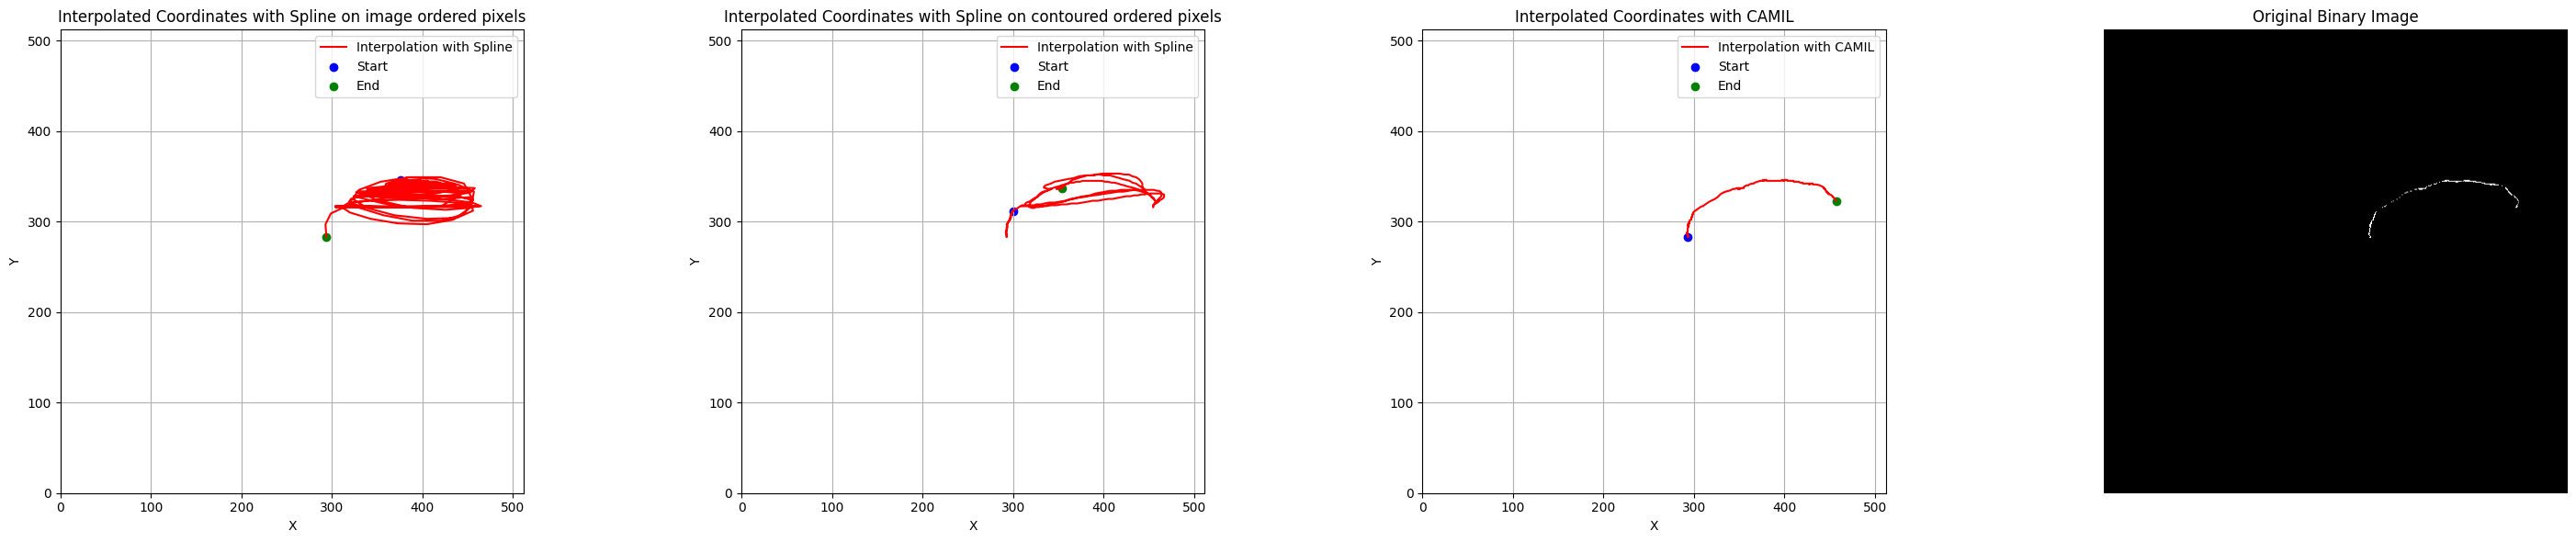

curves: 1


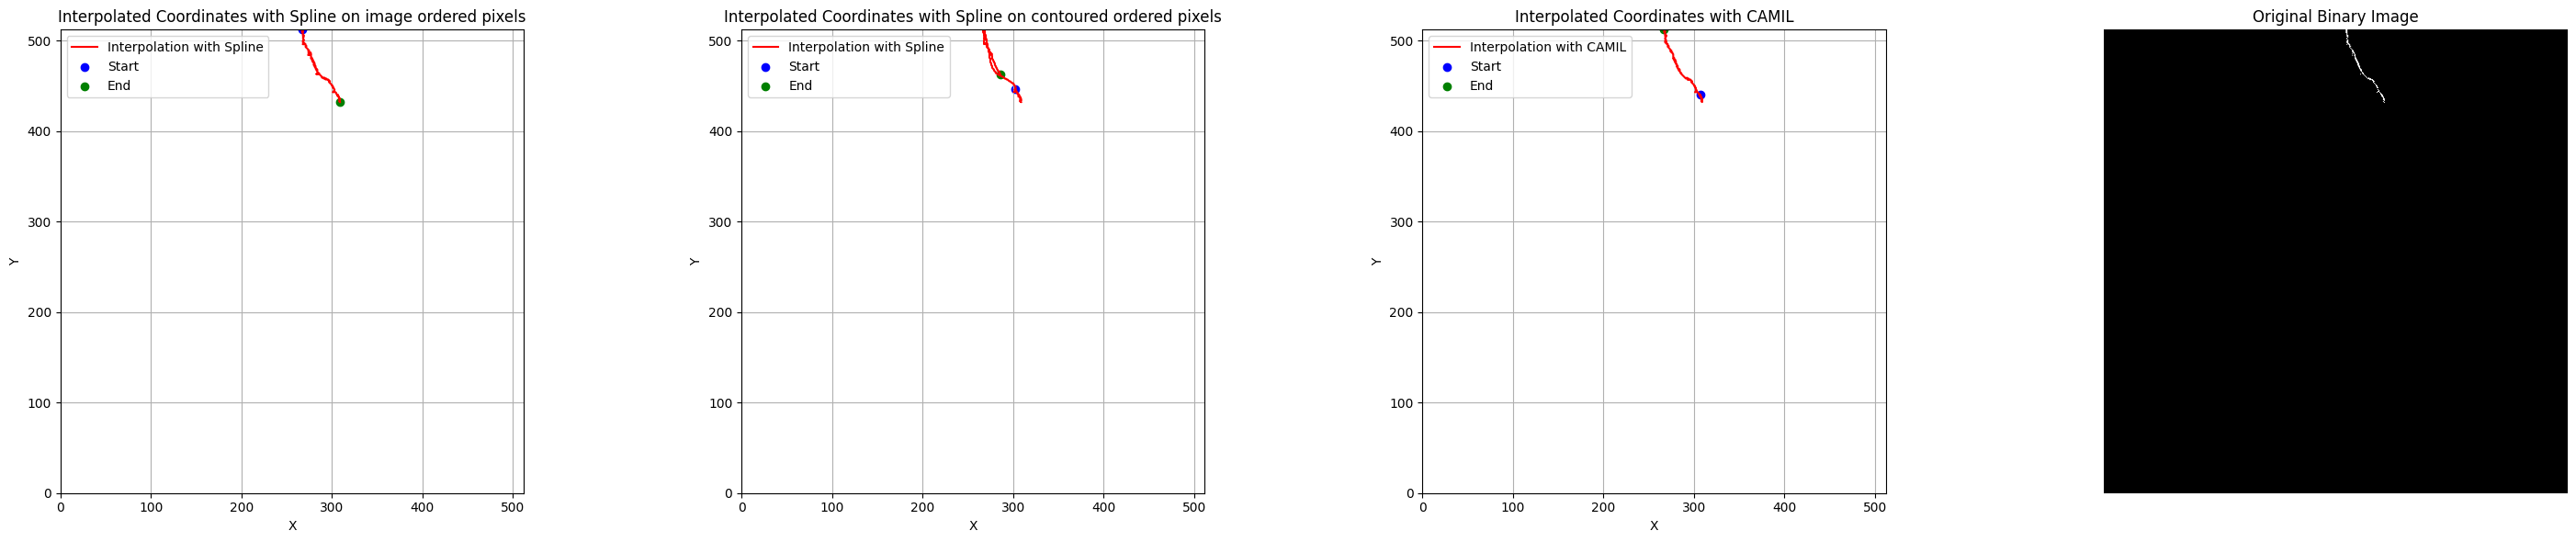

curves: 1


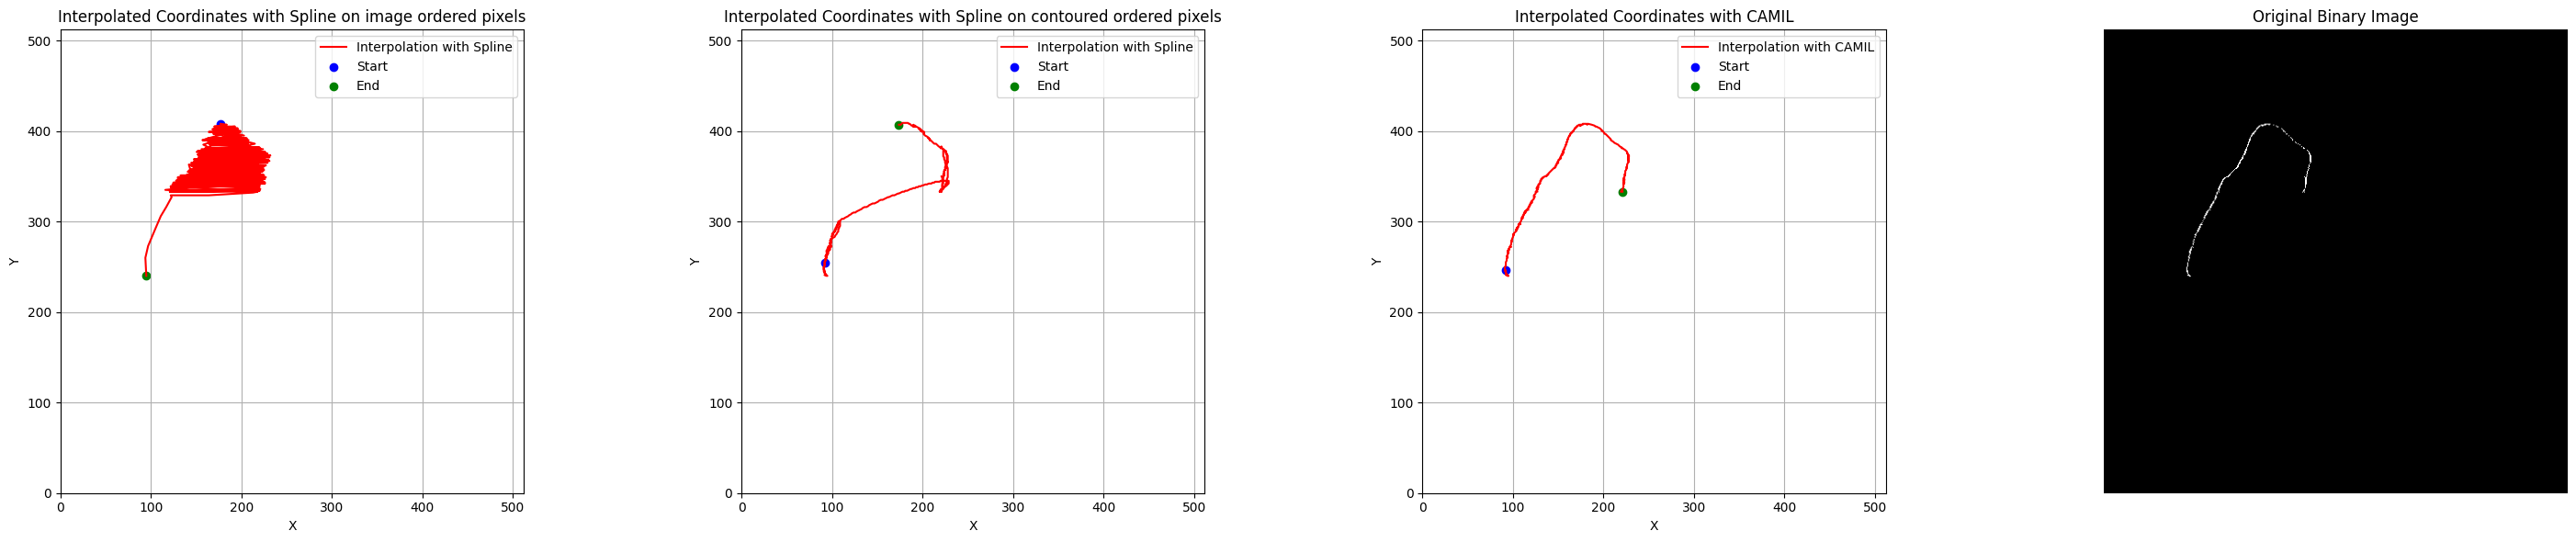

curves: 1


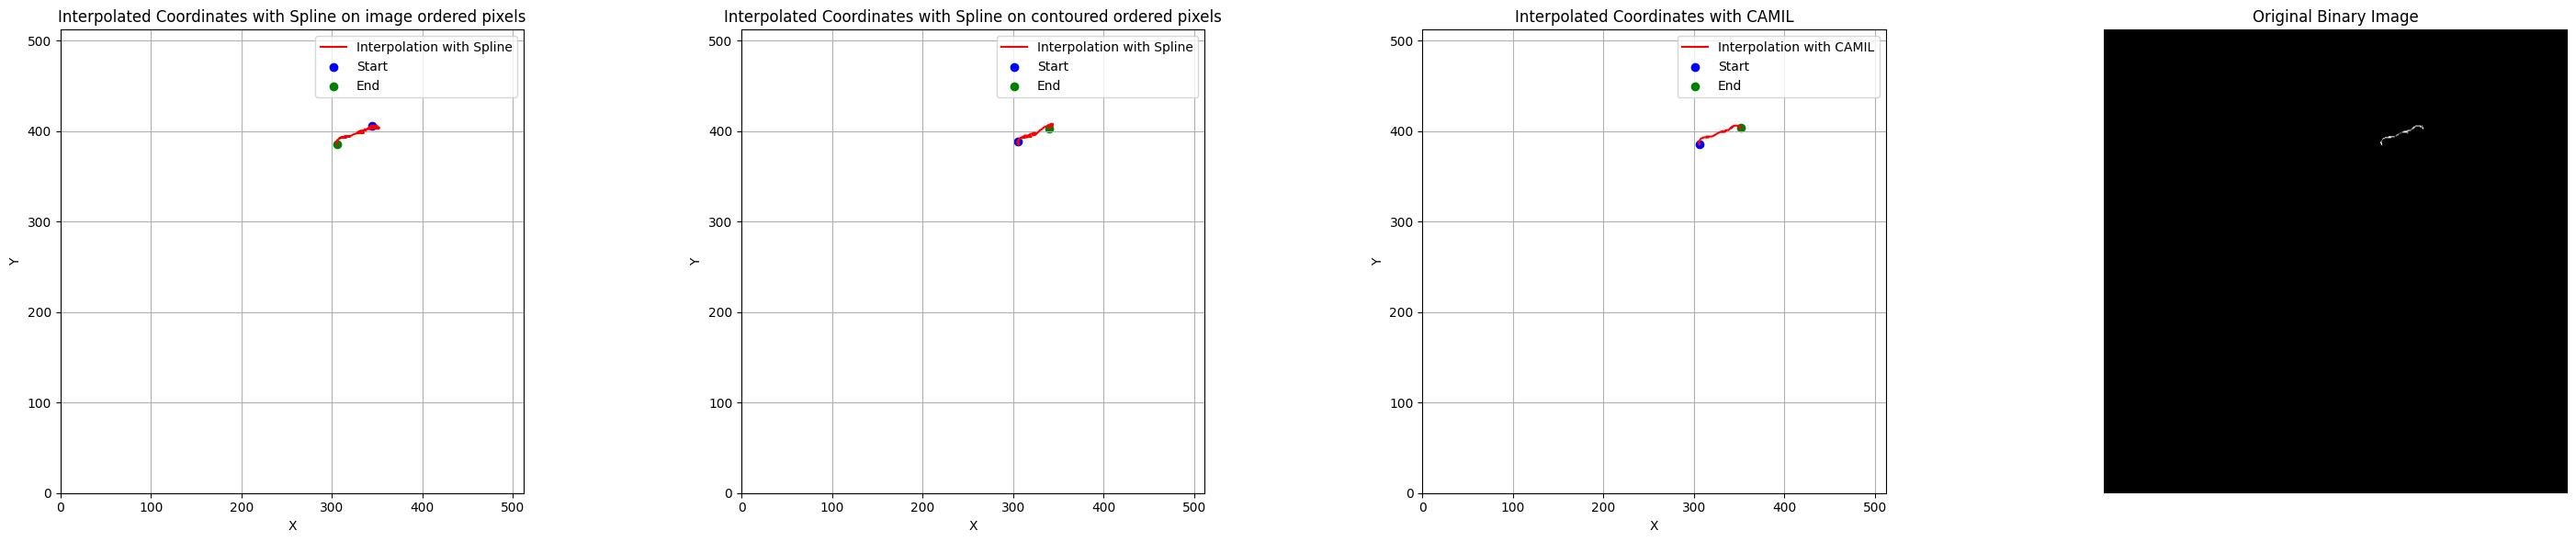

curves: 1


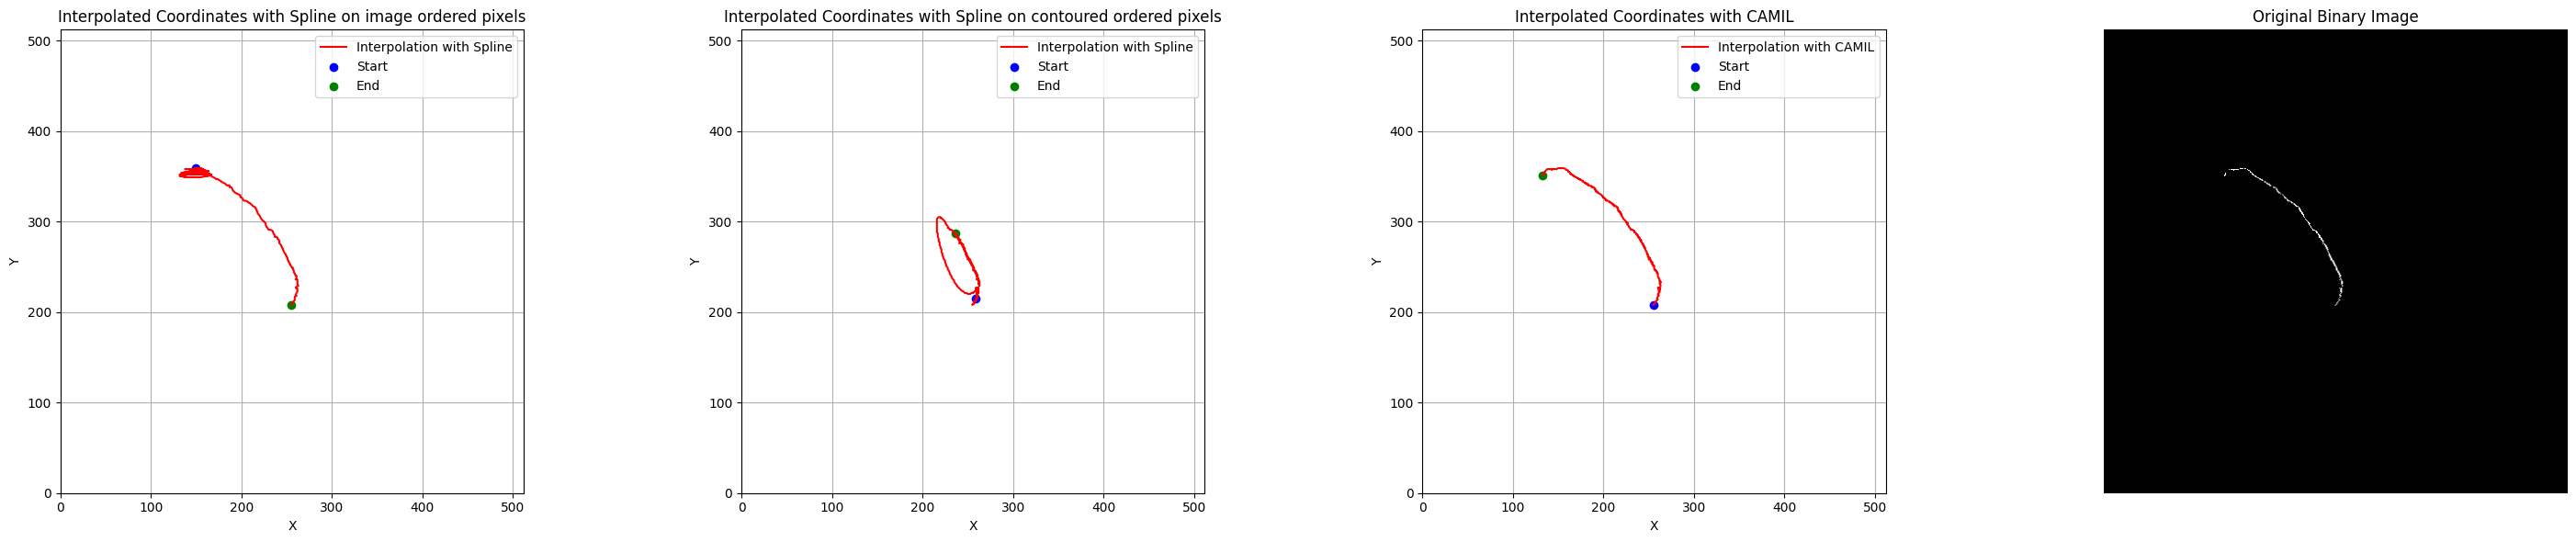

curves: 1


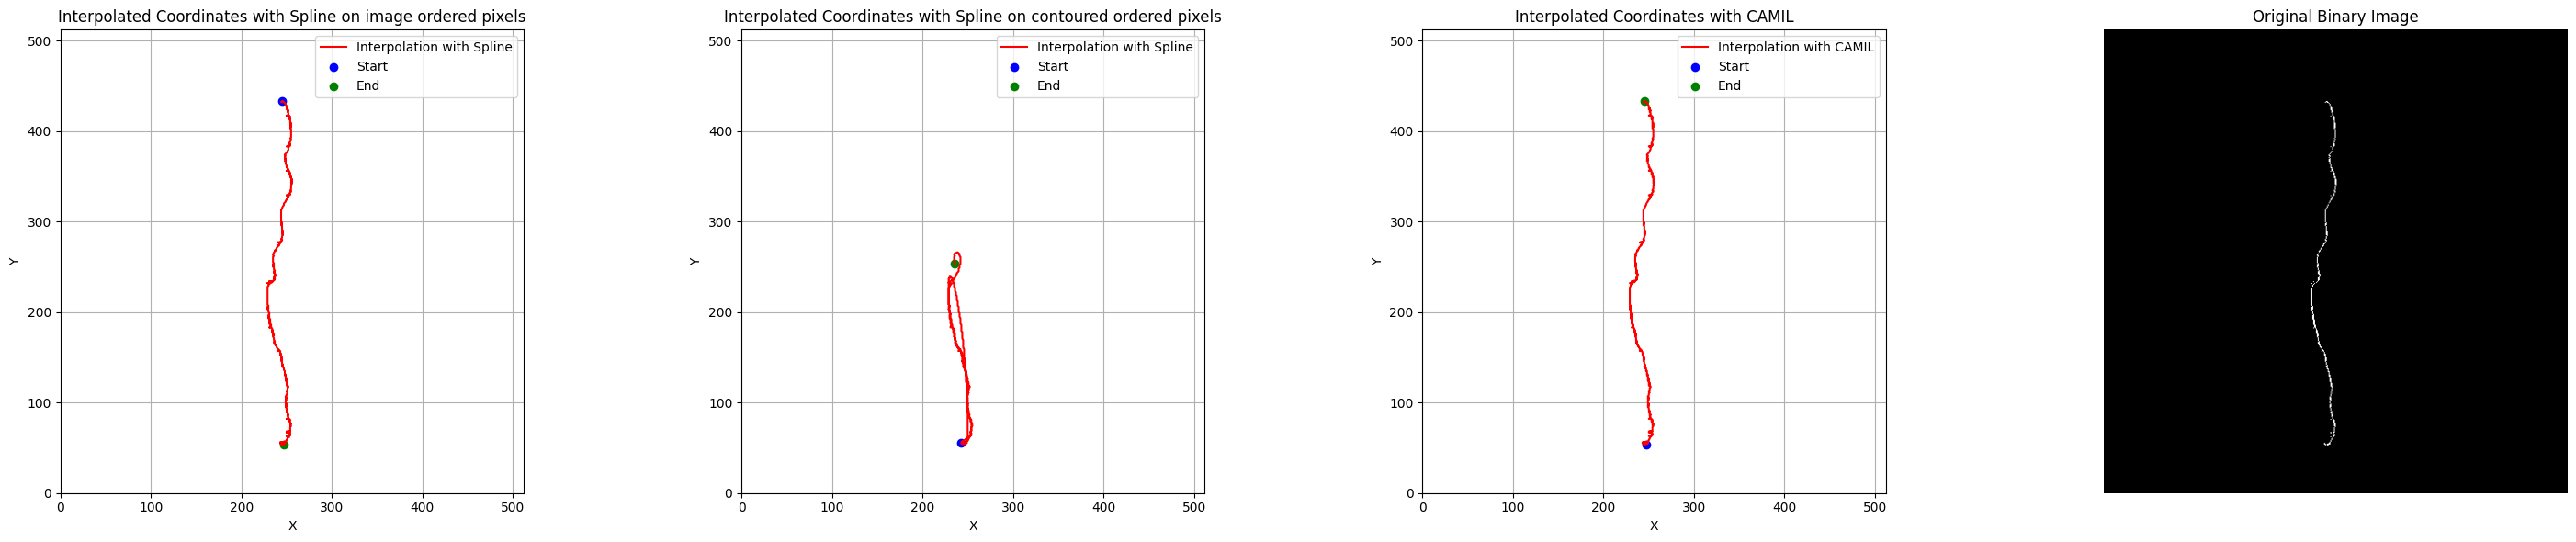

curves: 1


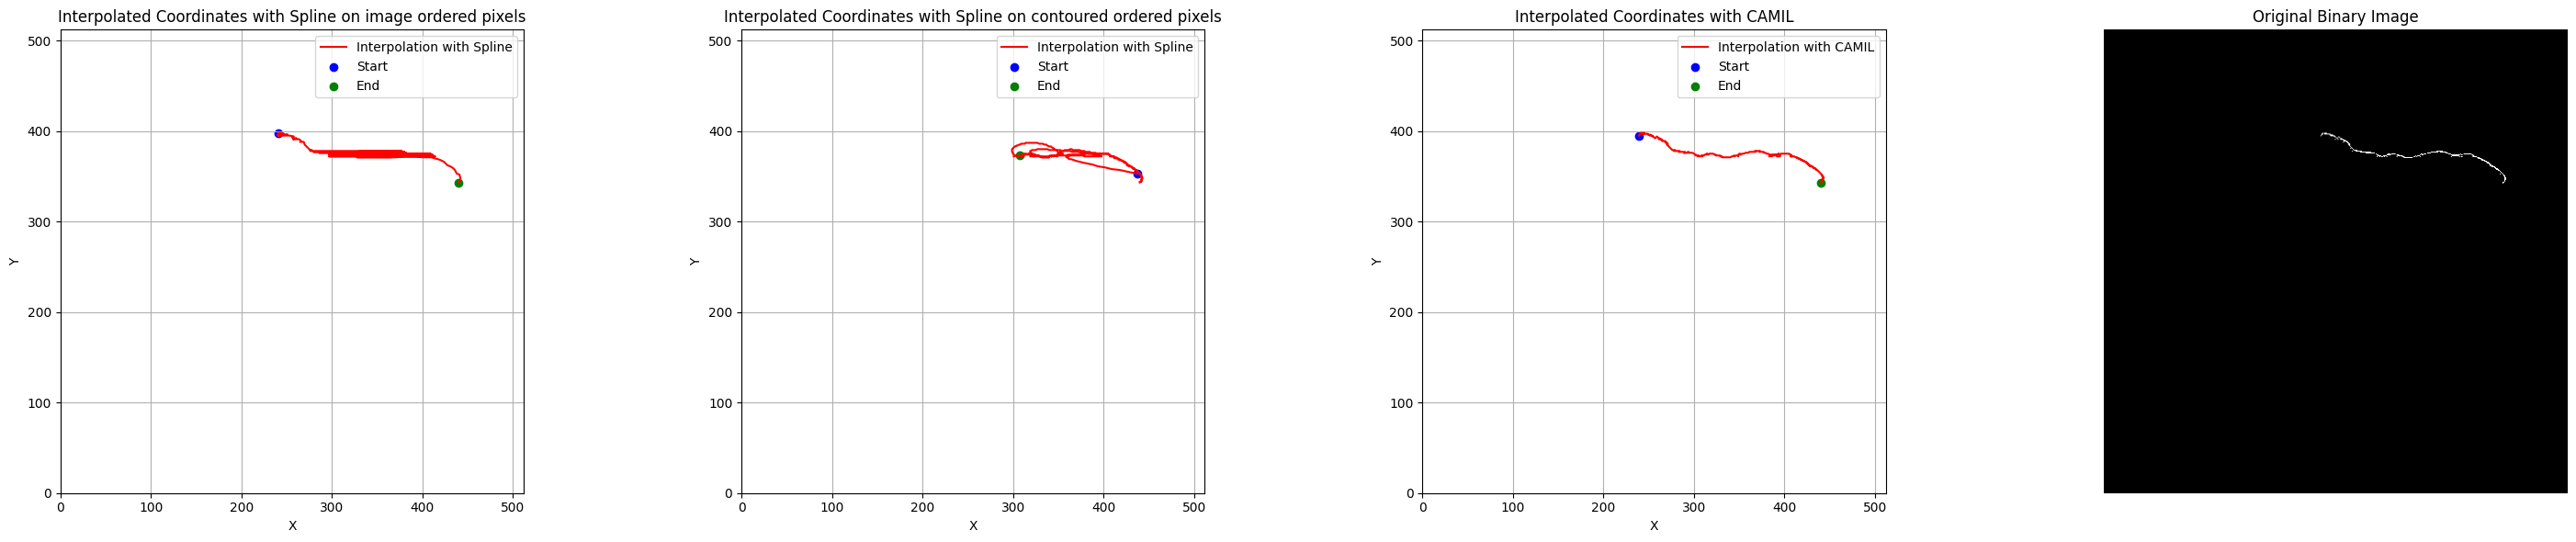

curves: 2
curves: 2


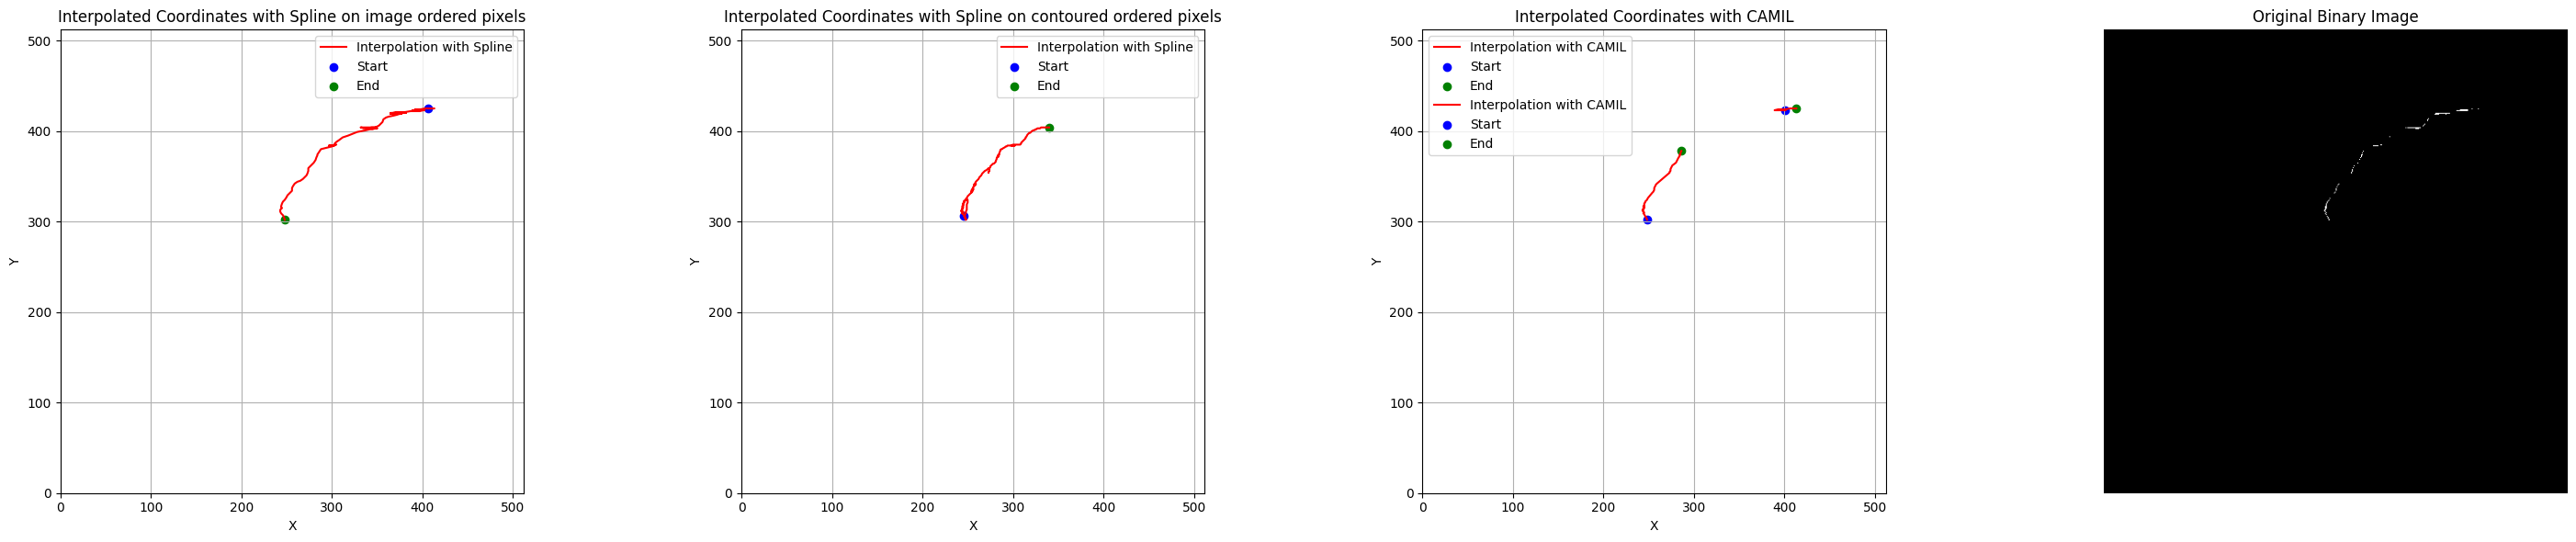

curves: 1


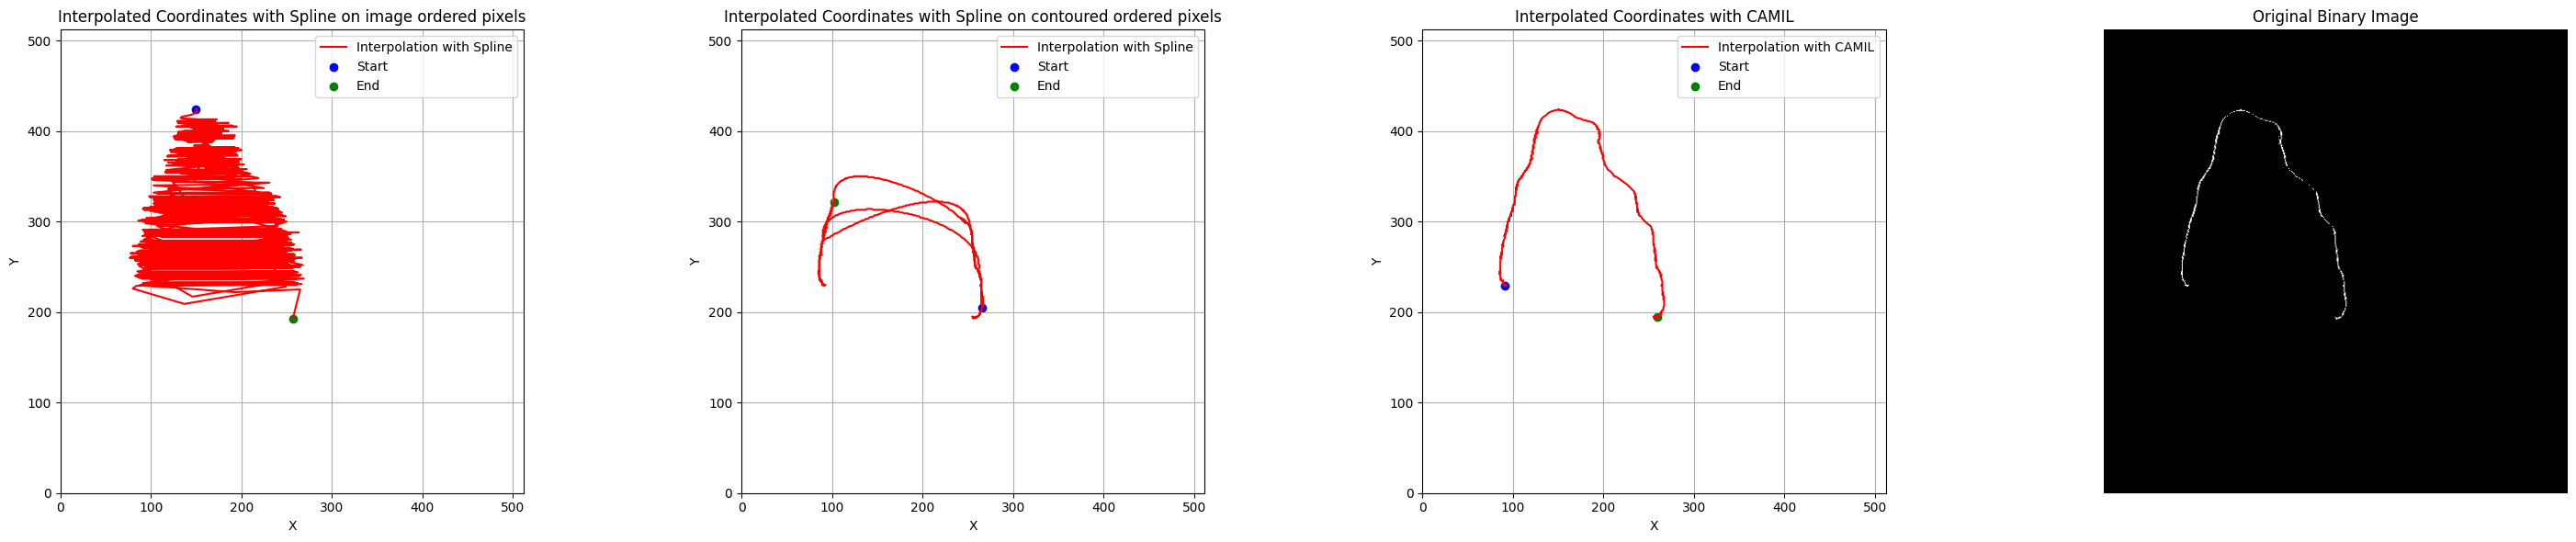

curves: 1


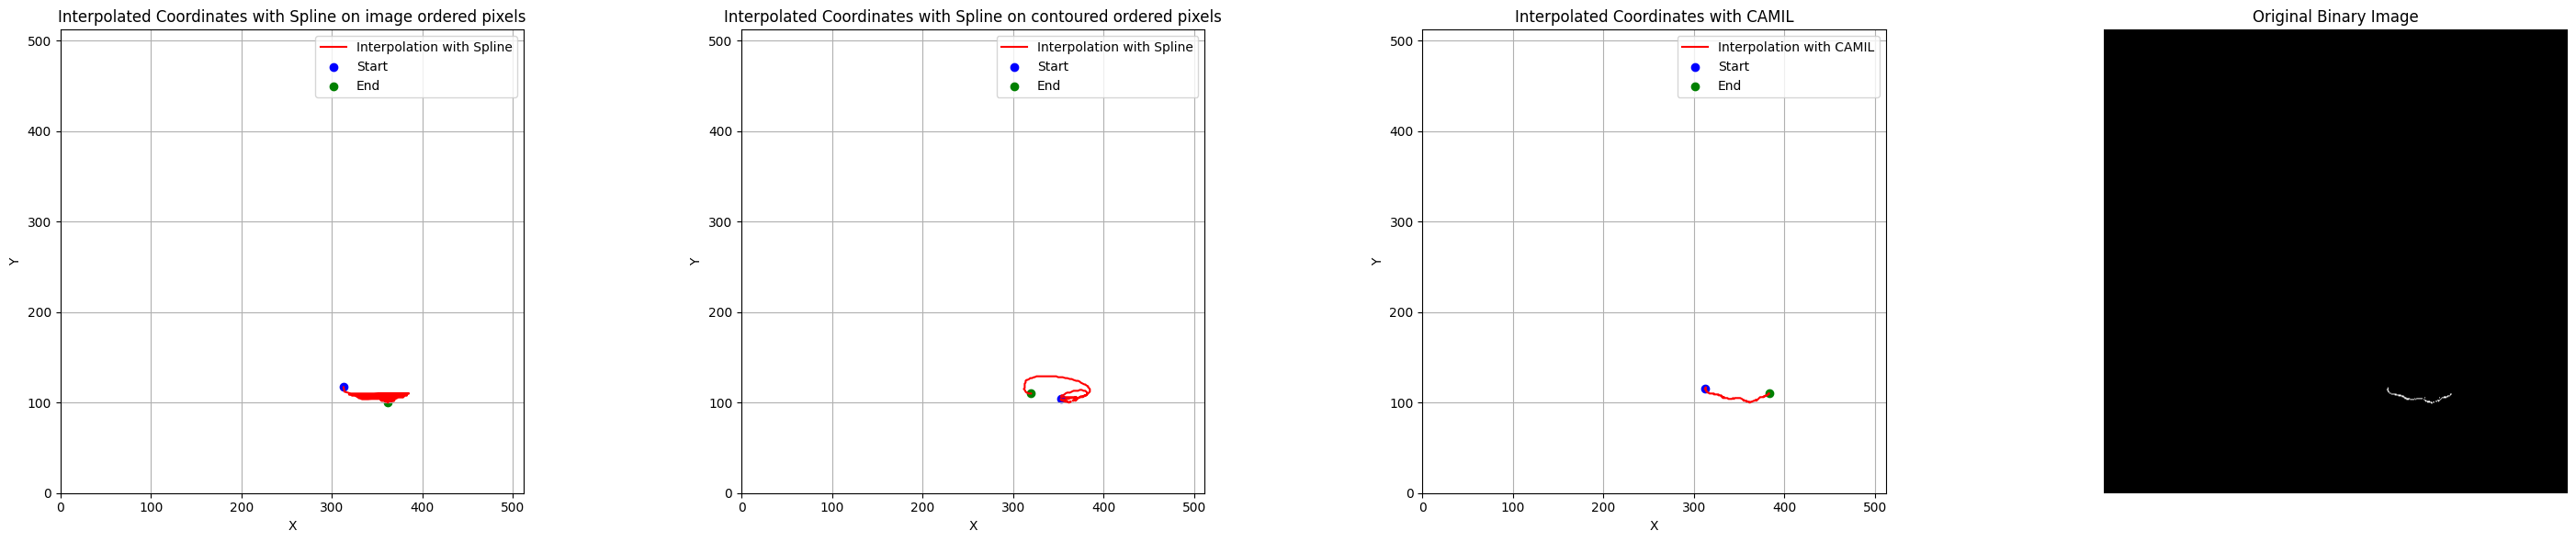

curves: 1


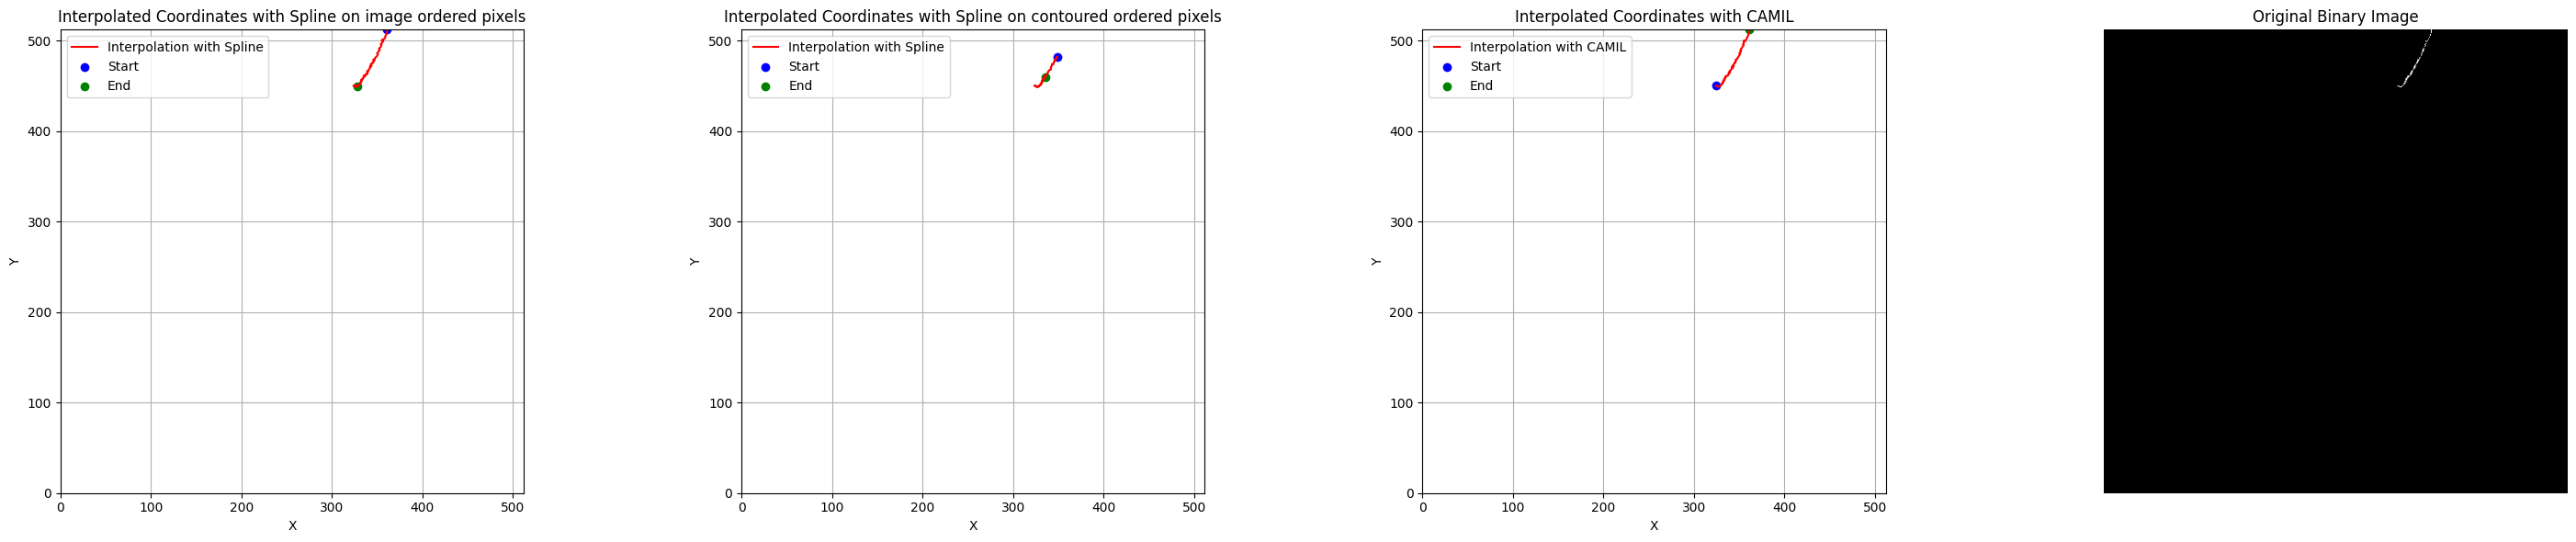

curves: 1


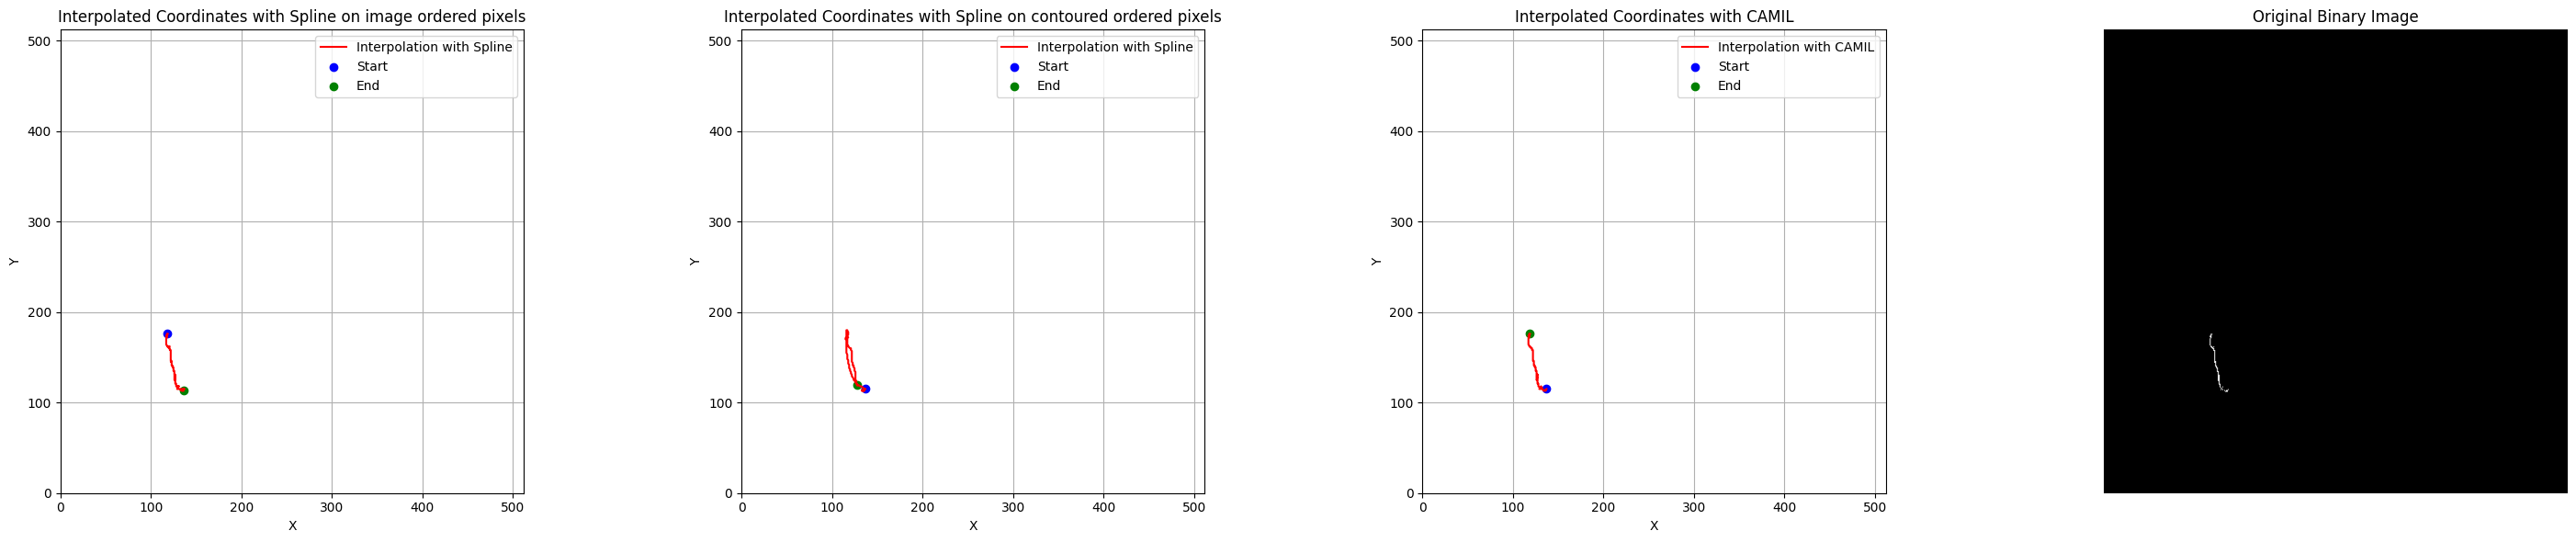

curves: 1


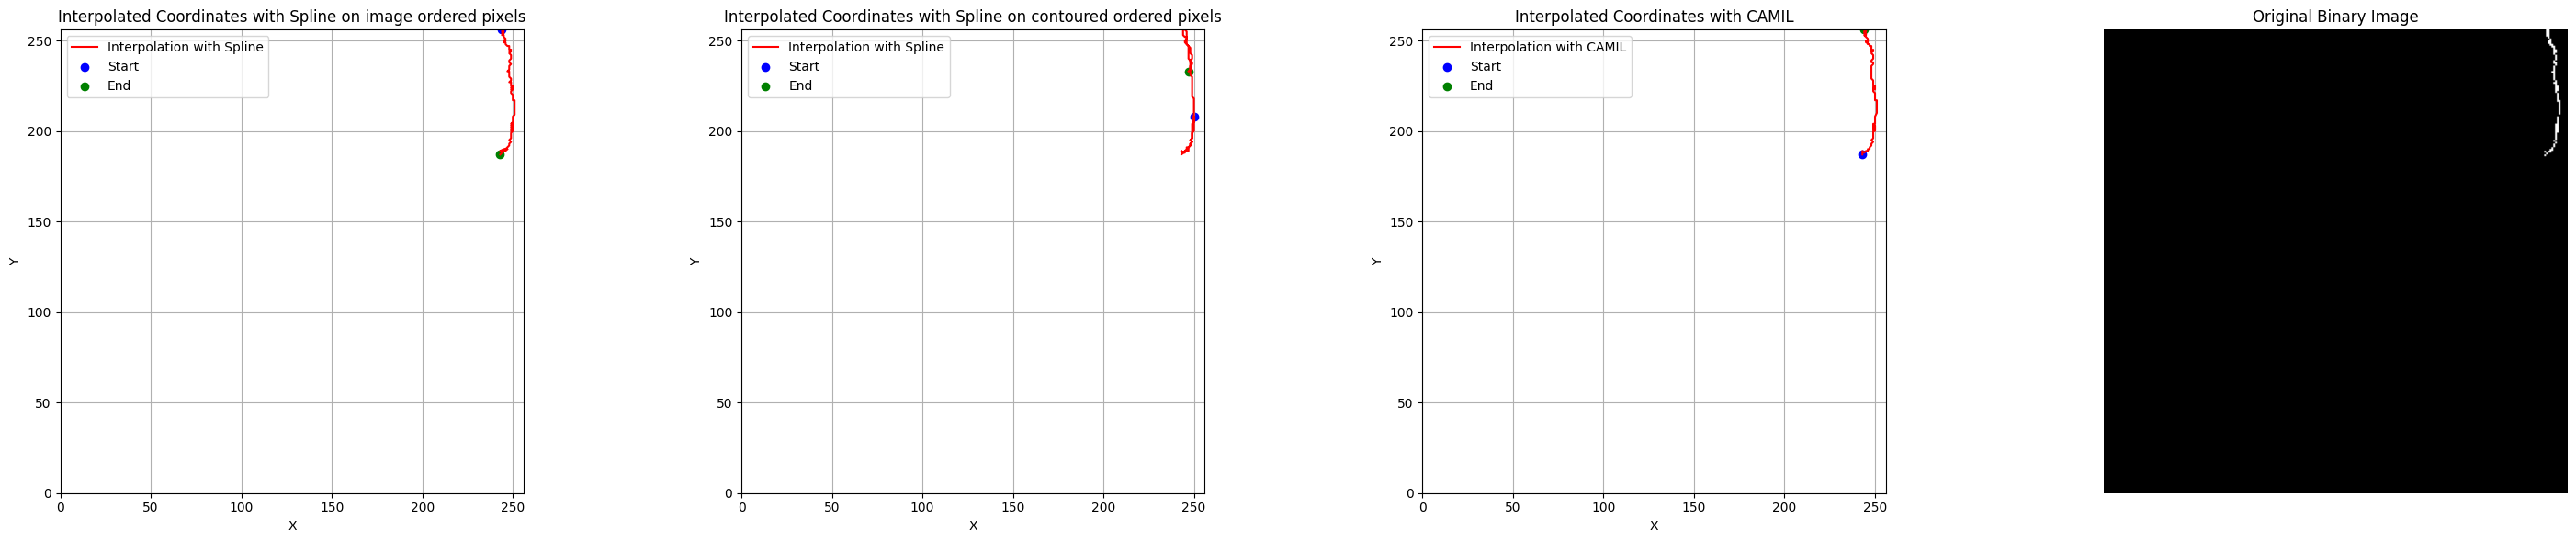

curves: 2
curves: 2


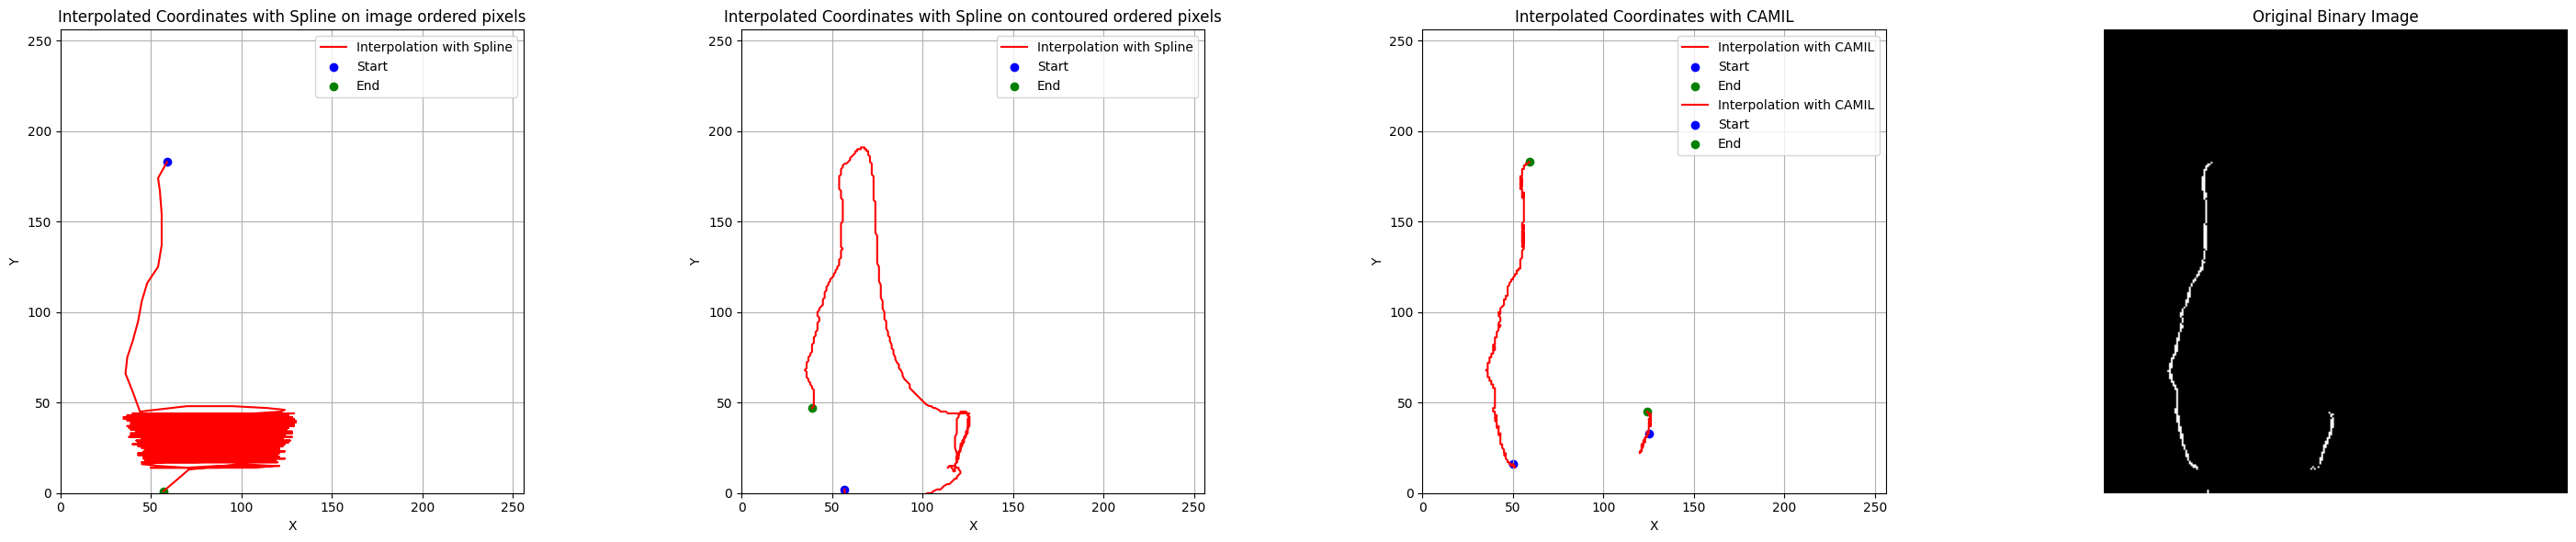

curves: 1


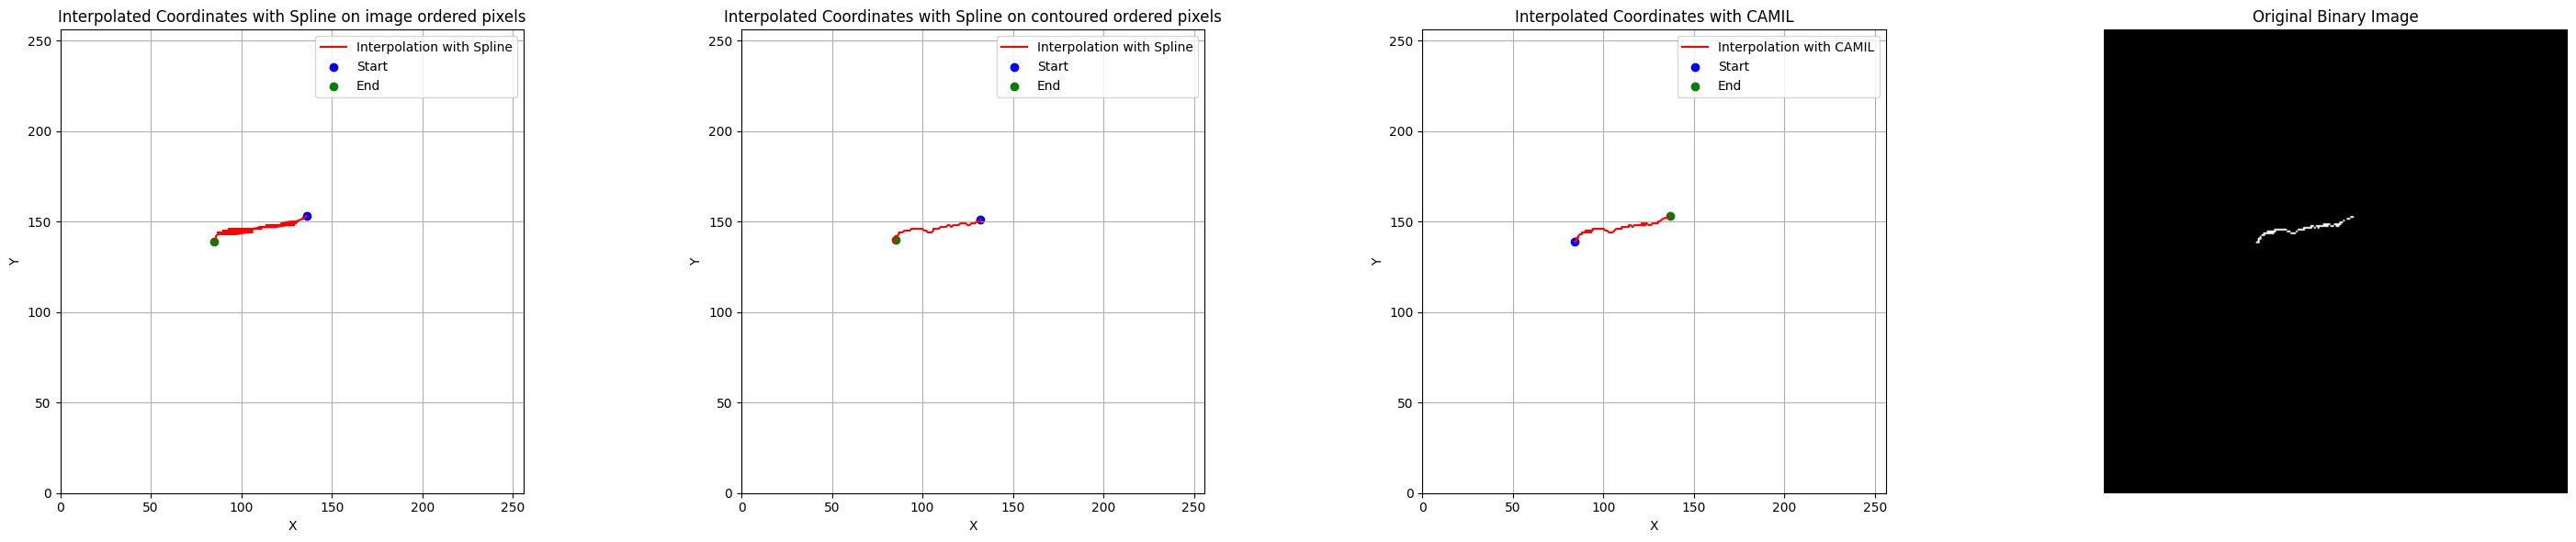

curves: 3
curves: 3
curves: 3


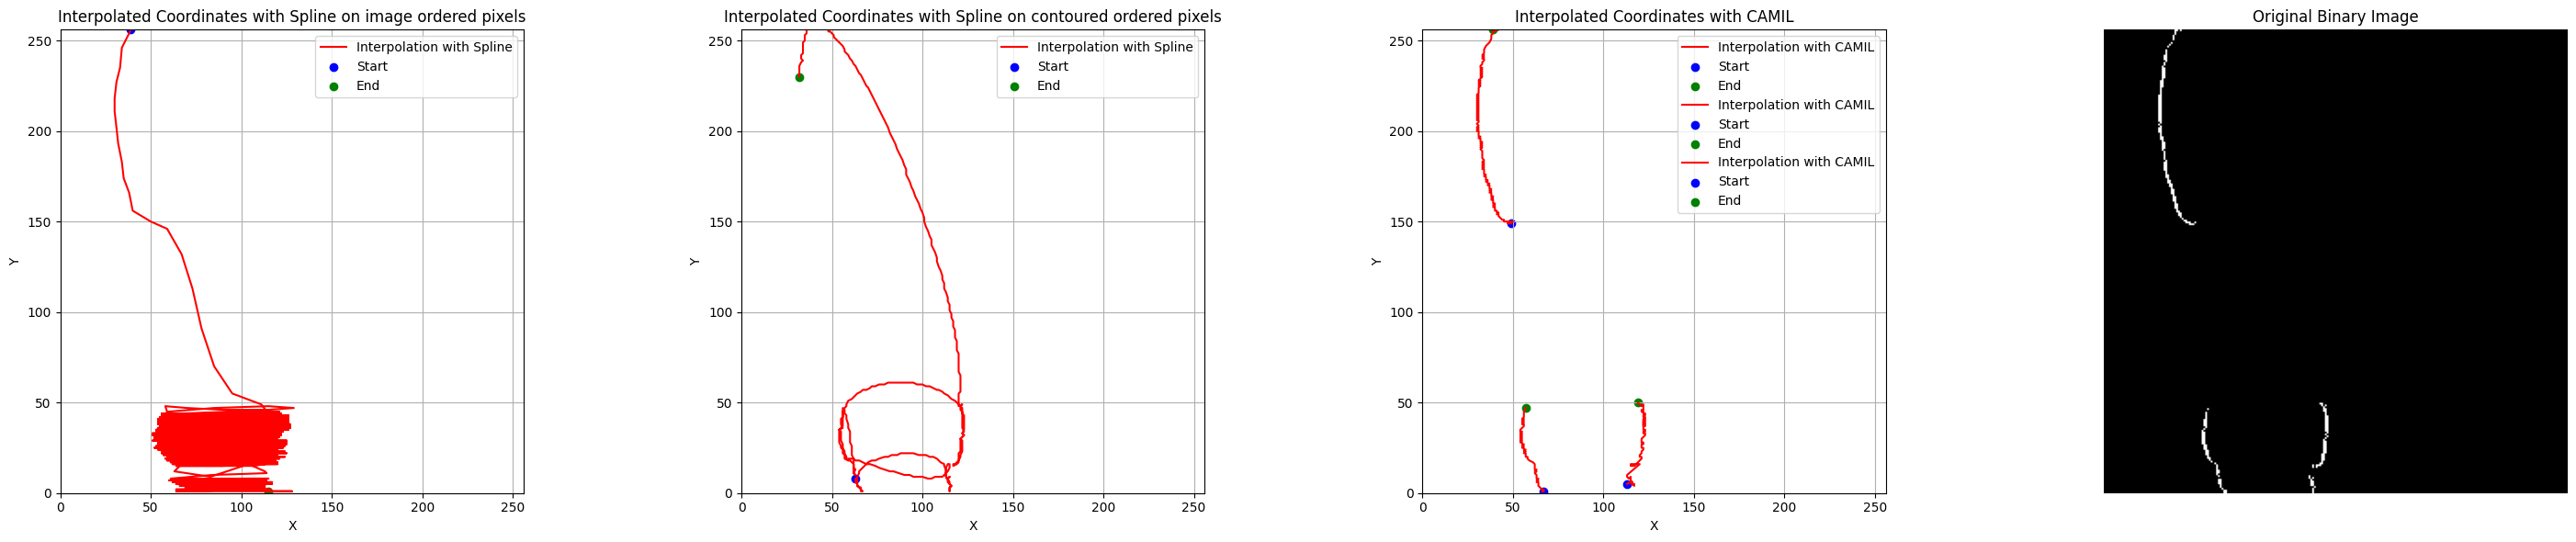

curves: 2
curves: 2


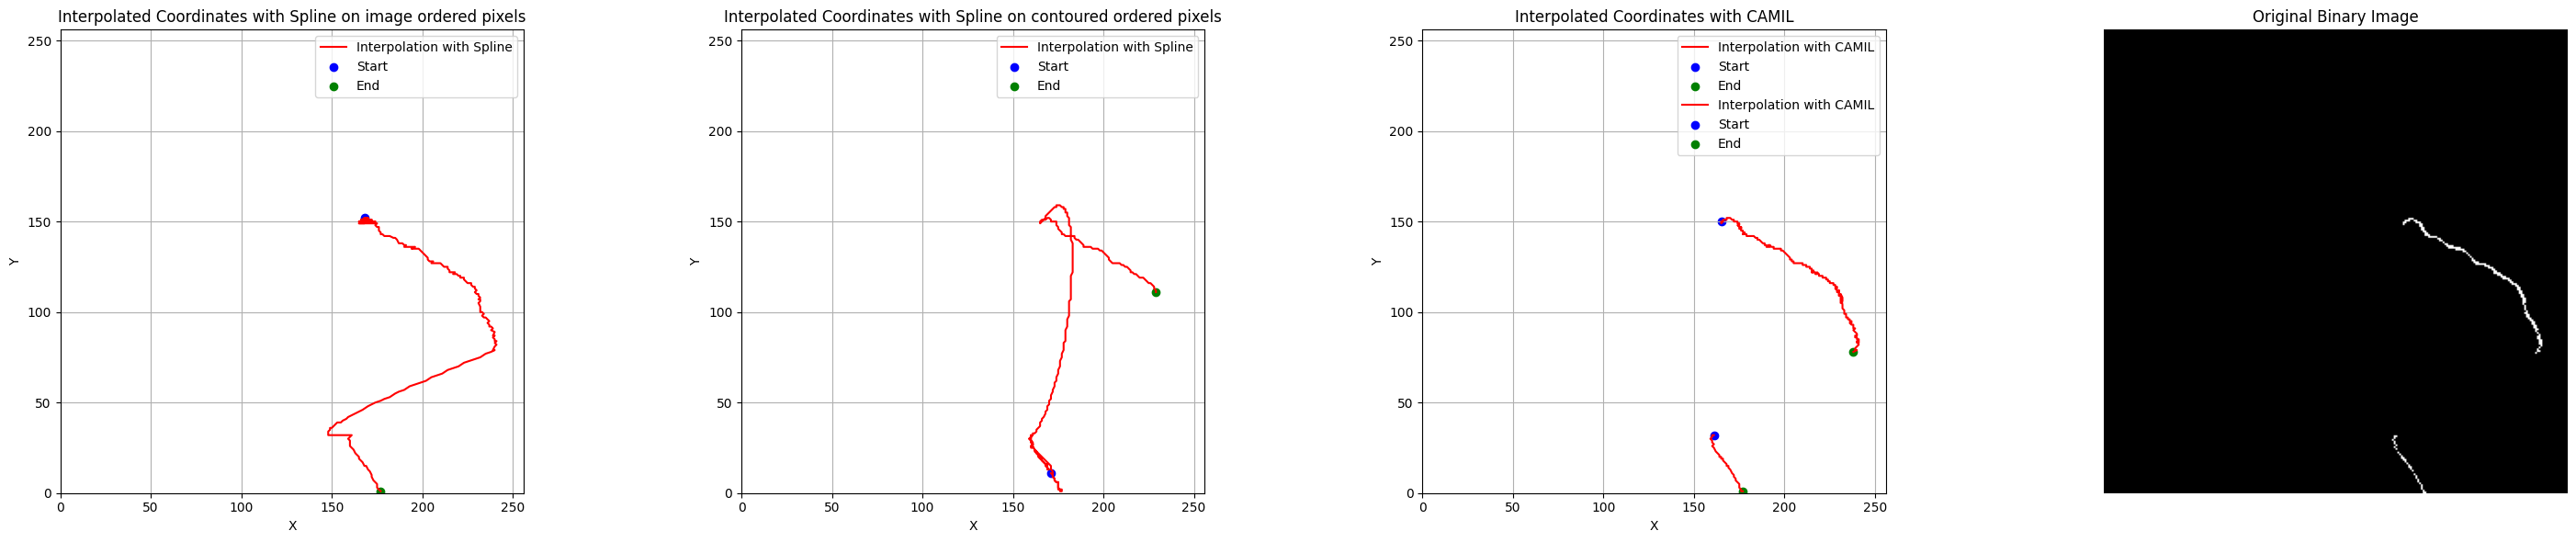

curves: 1


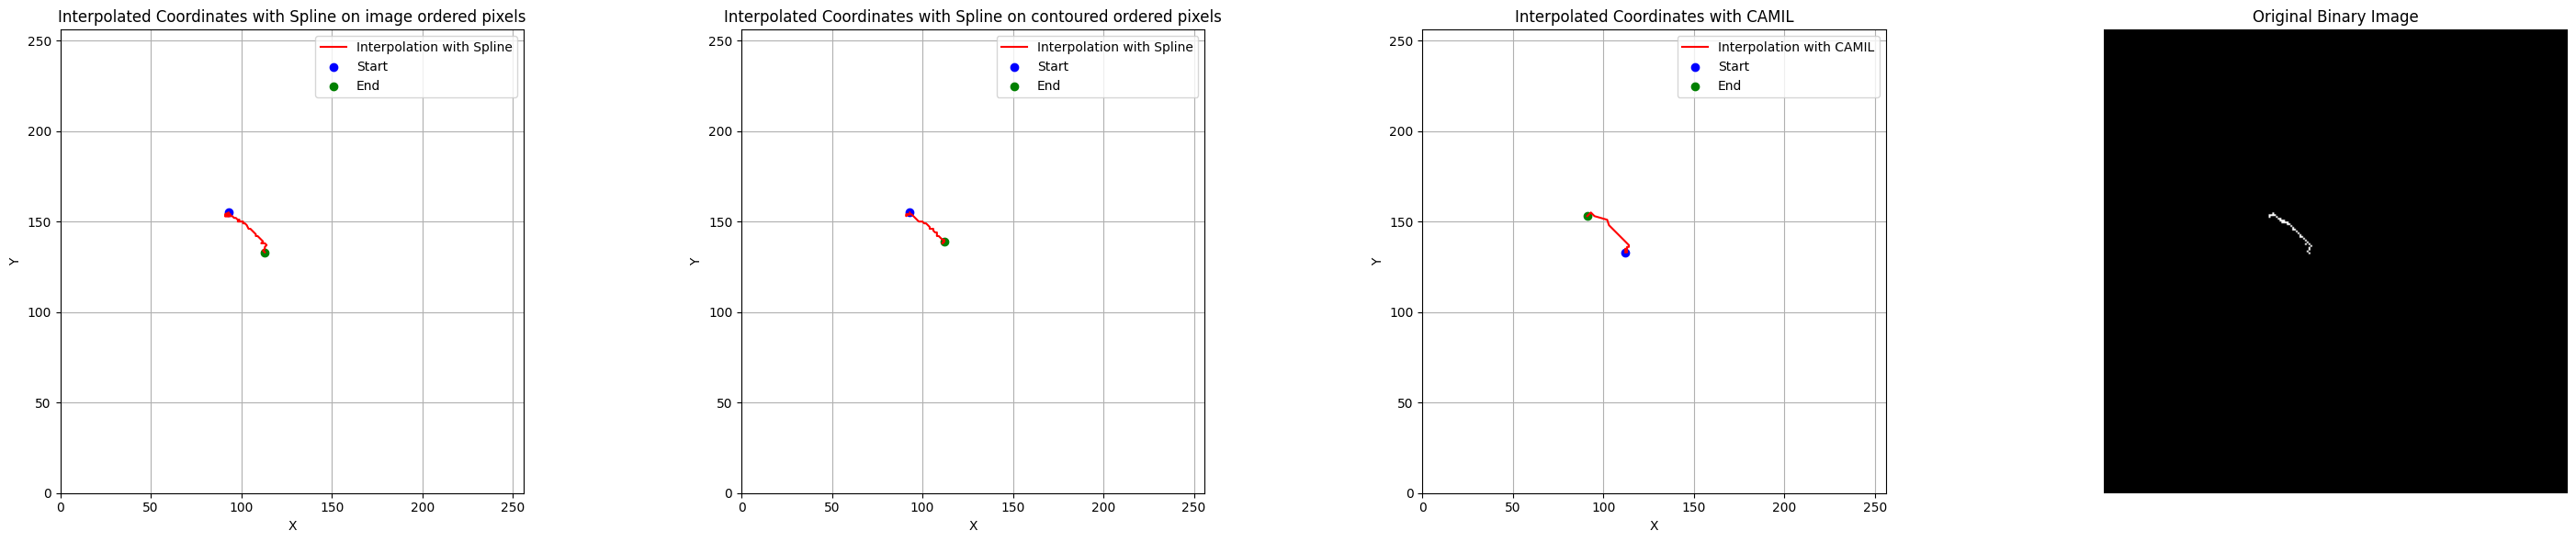

curves: 1


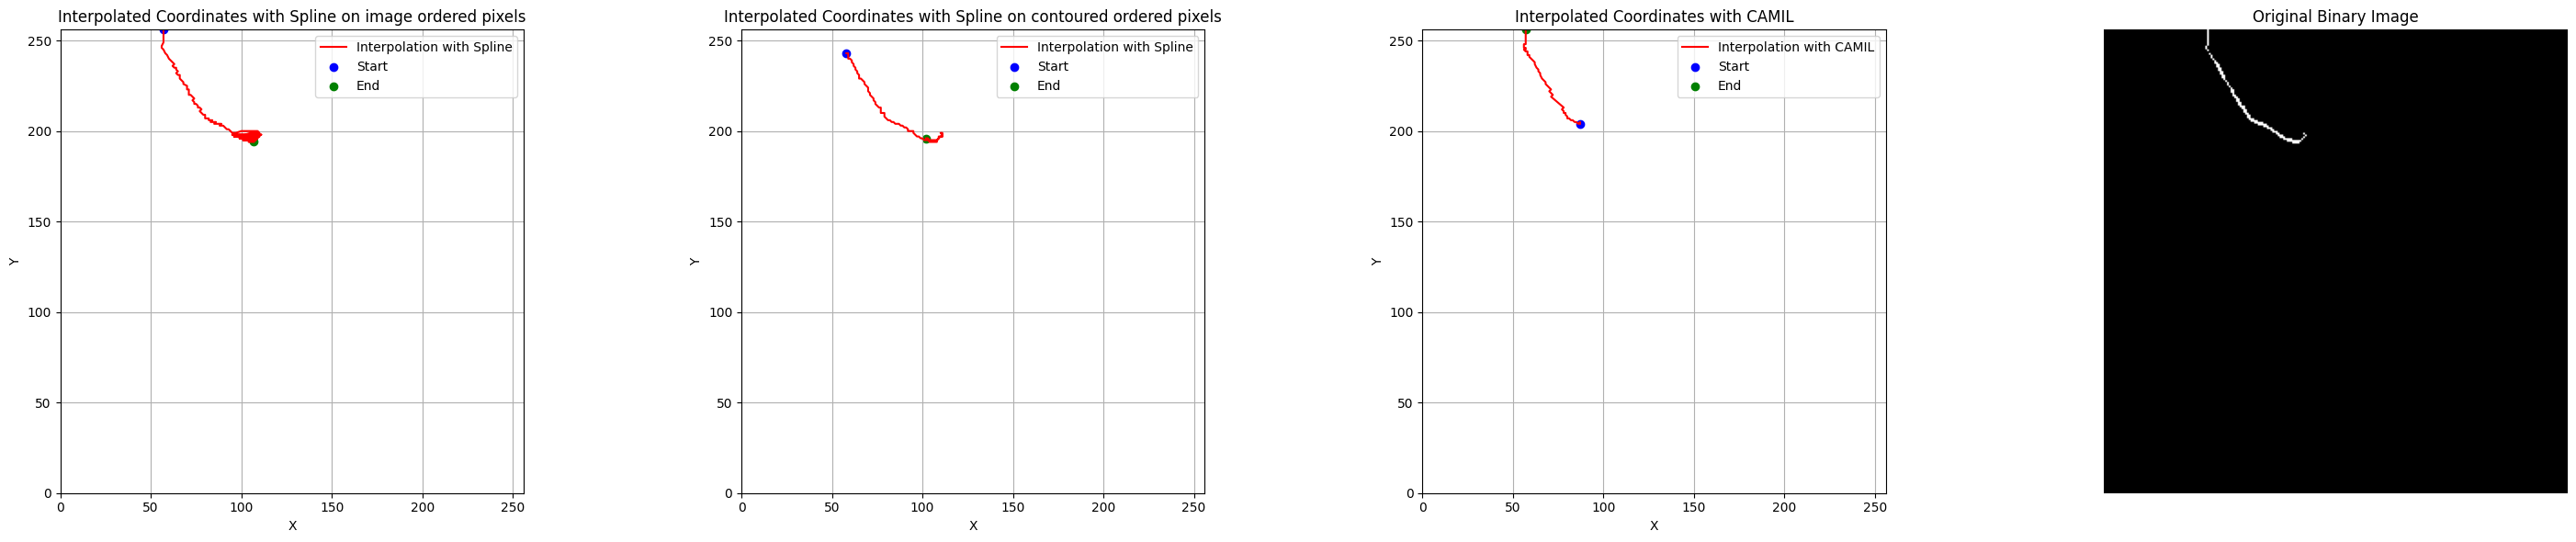

curves: 1


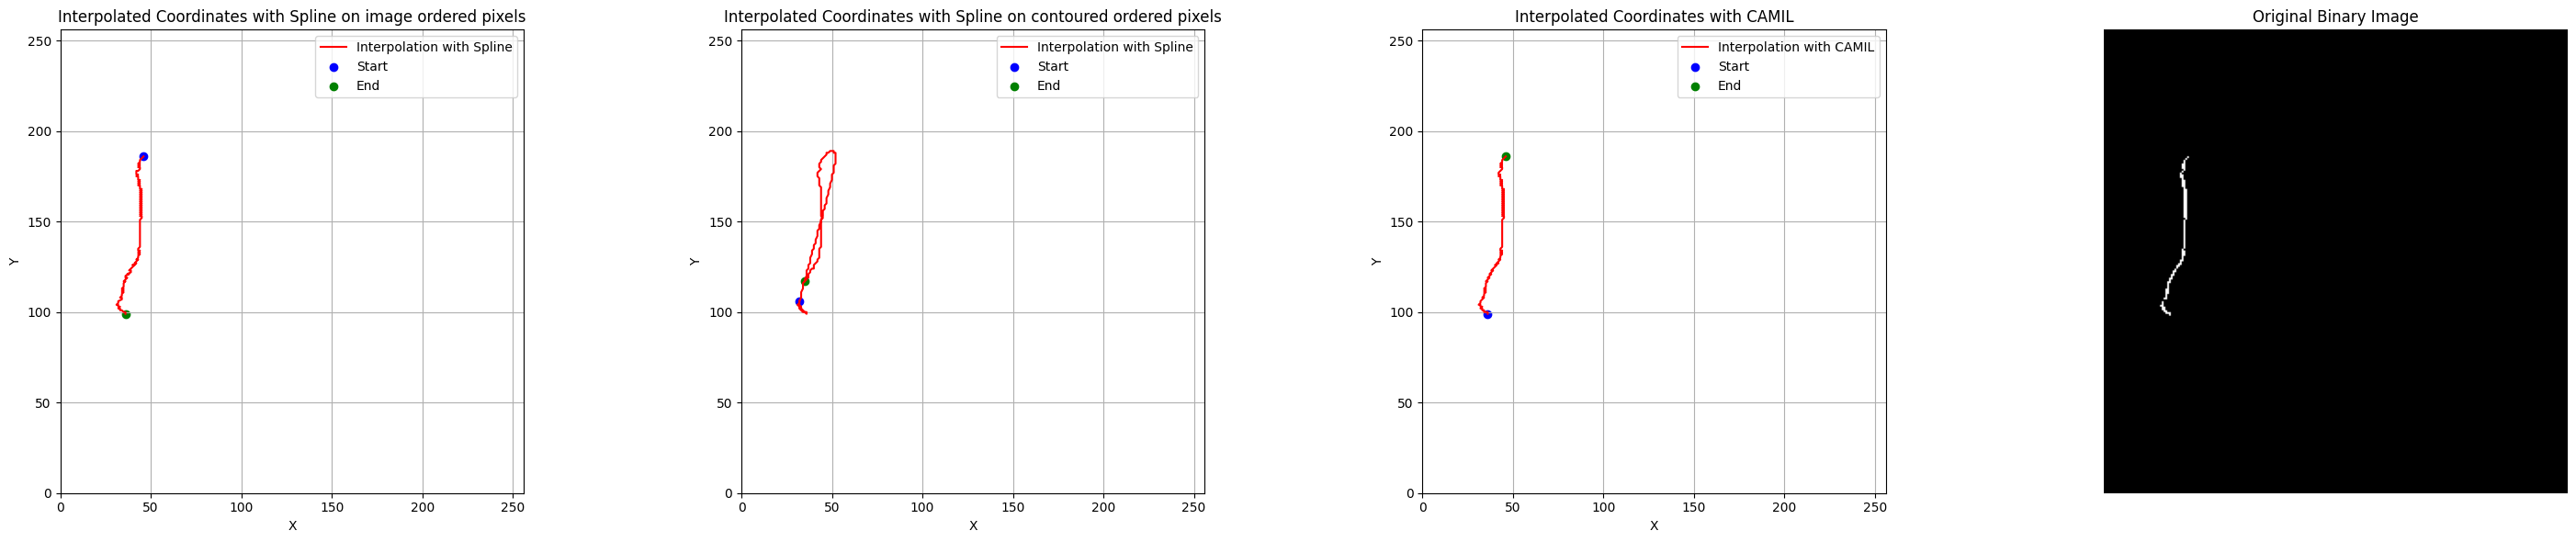

curves: 1


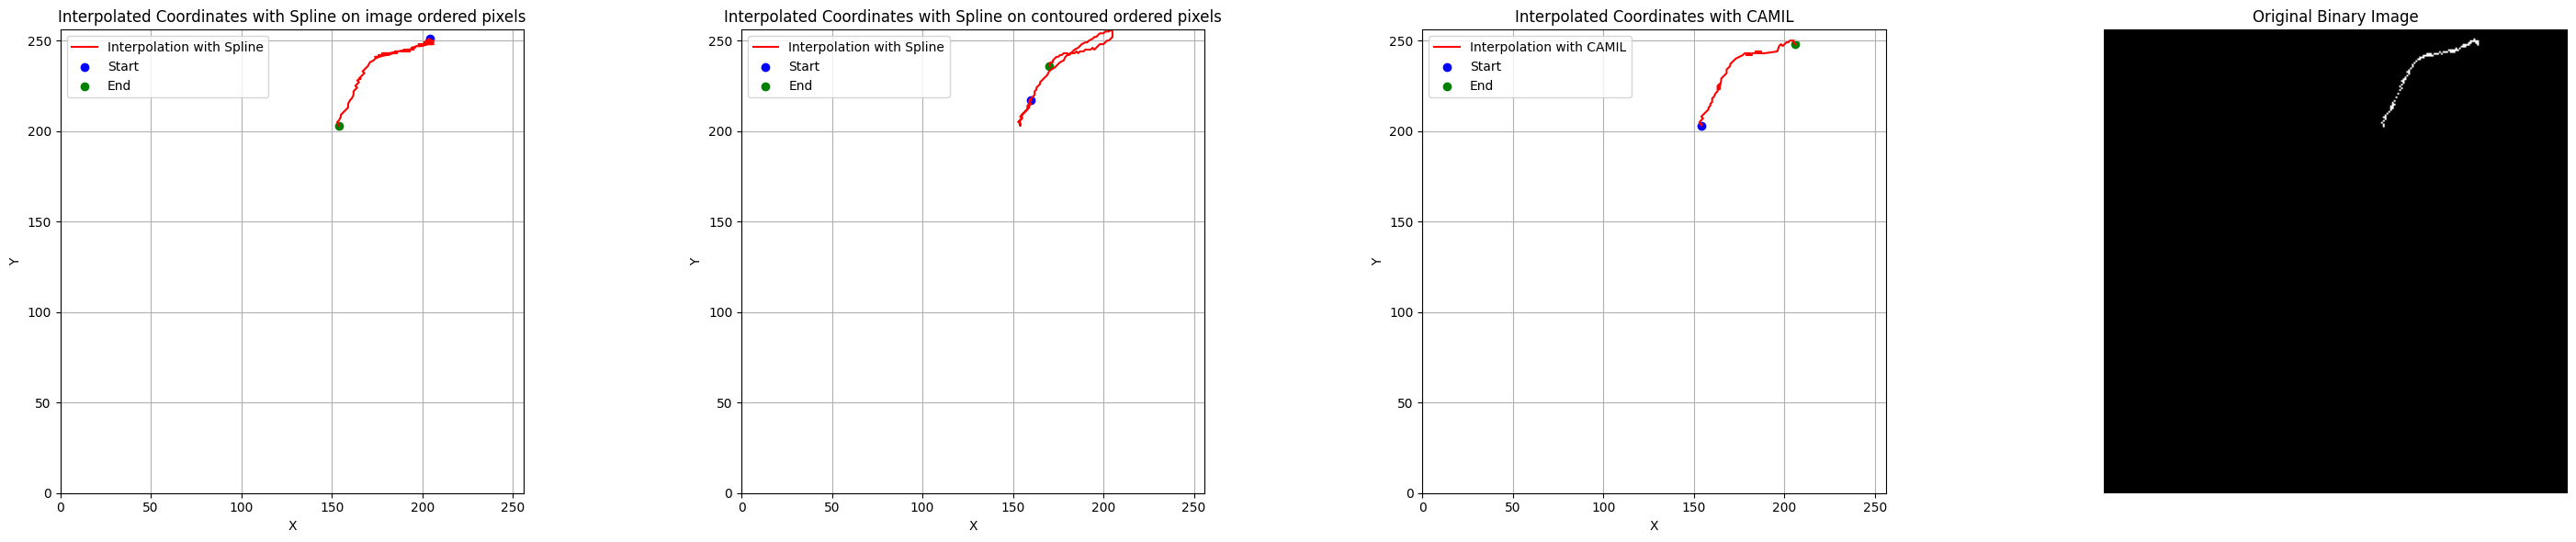

curves: 1


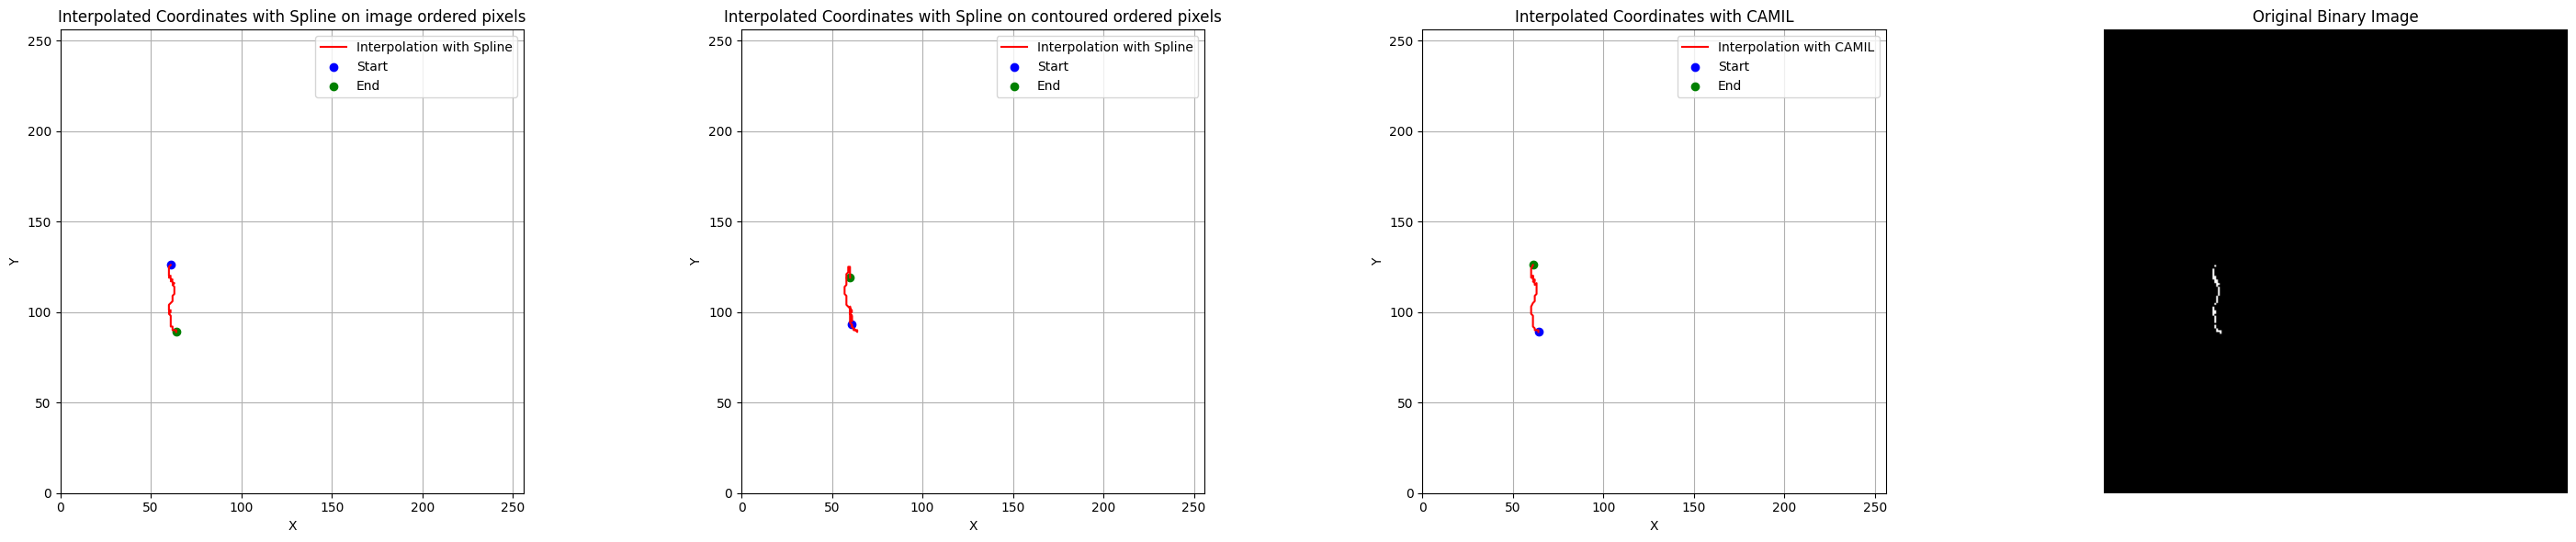

curves: 1


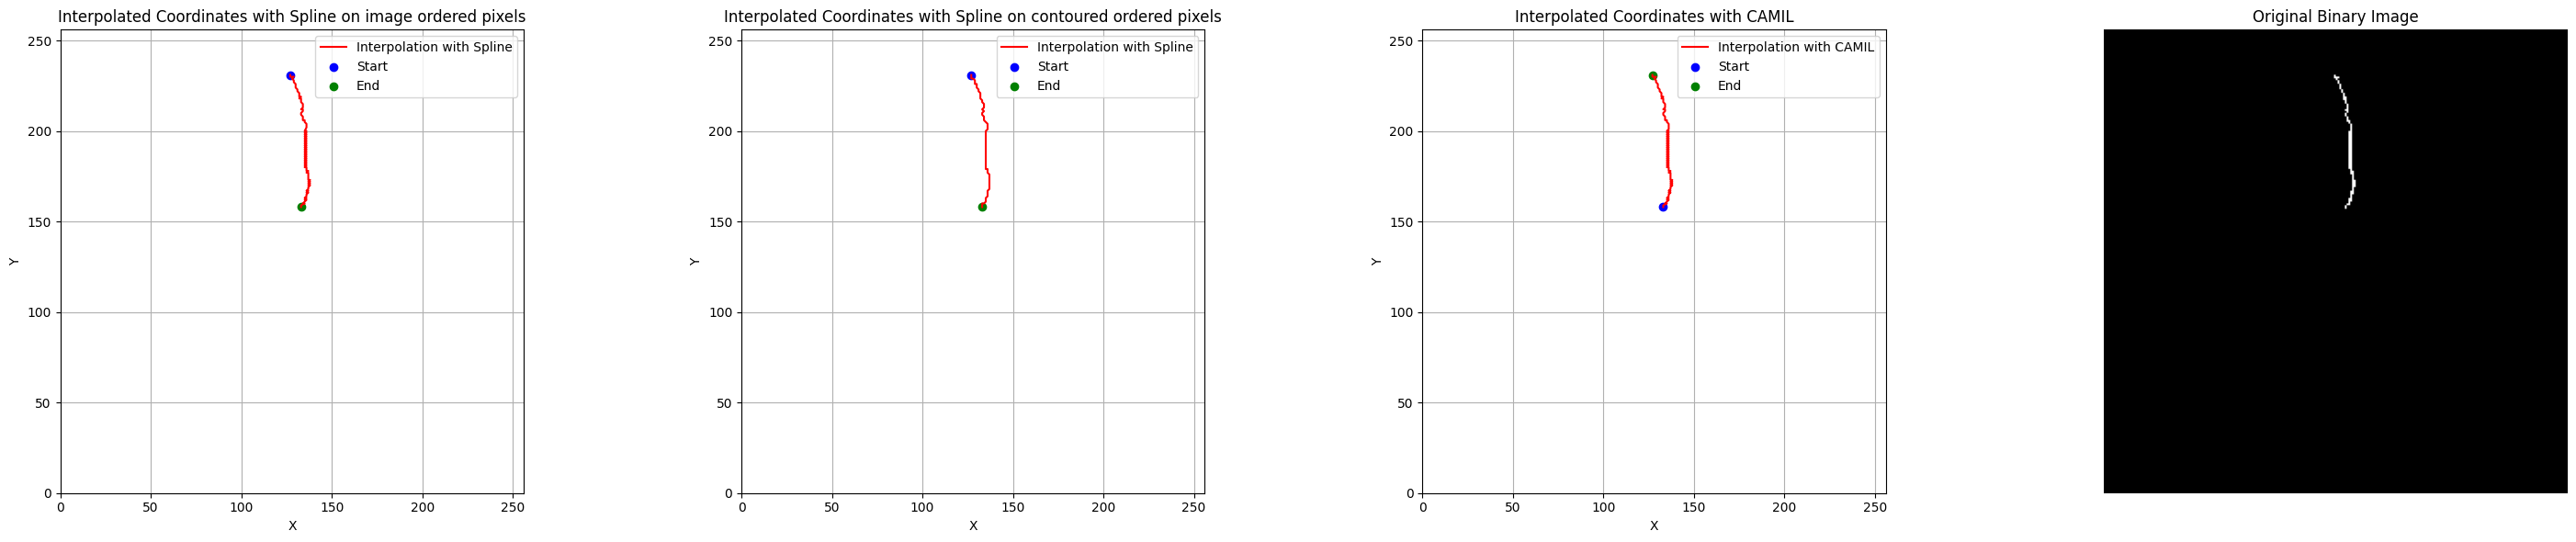

curves: 1


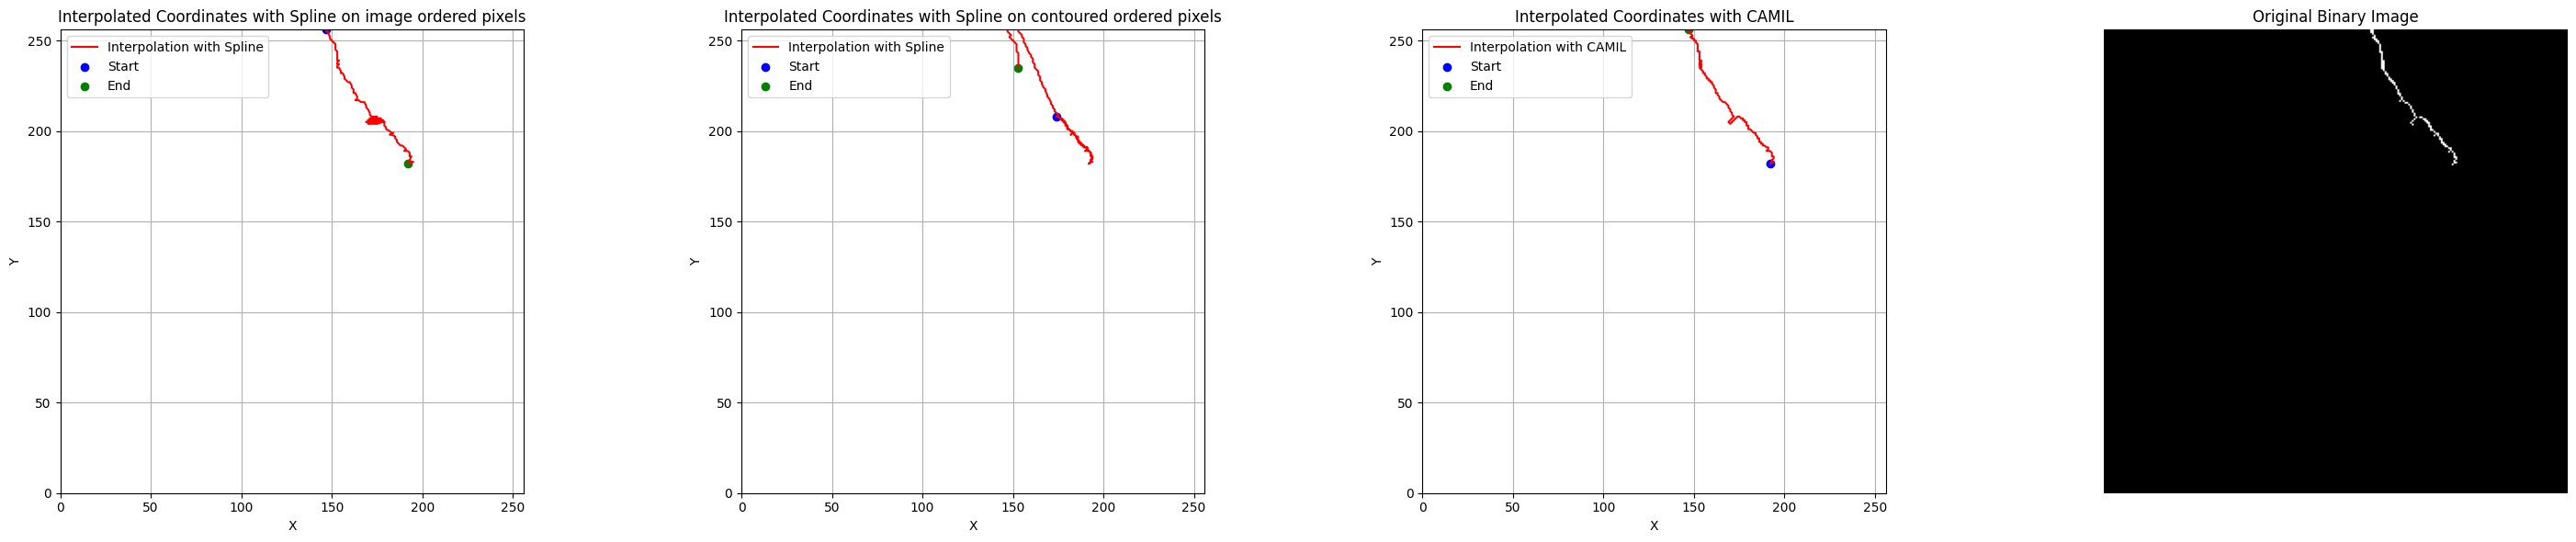

curves: 2
curves: 2


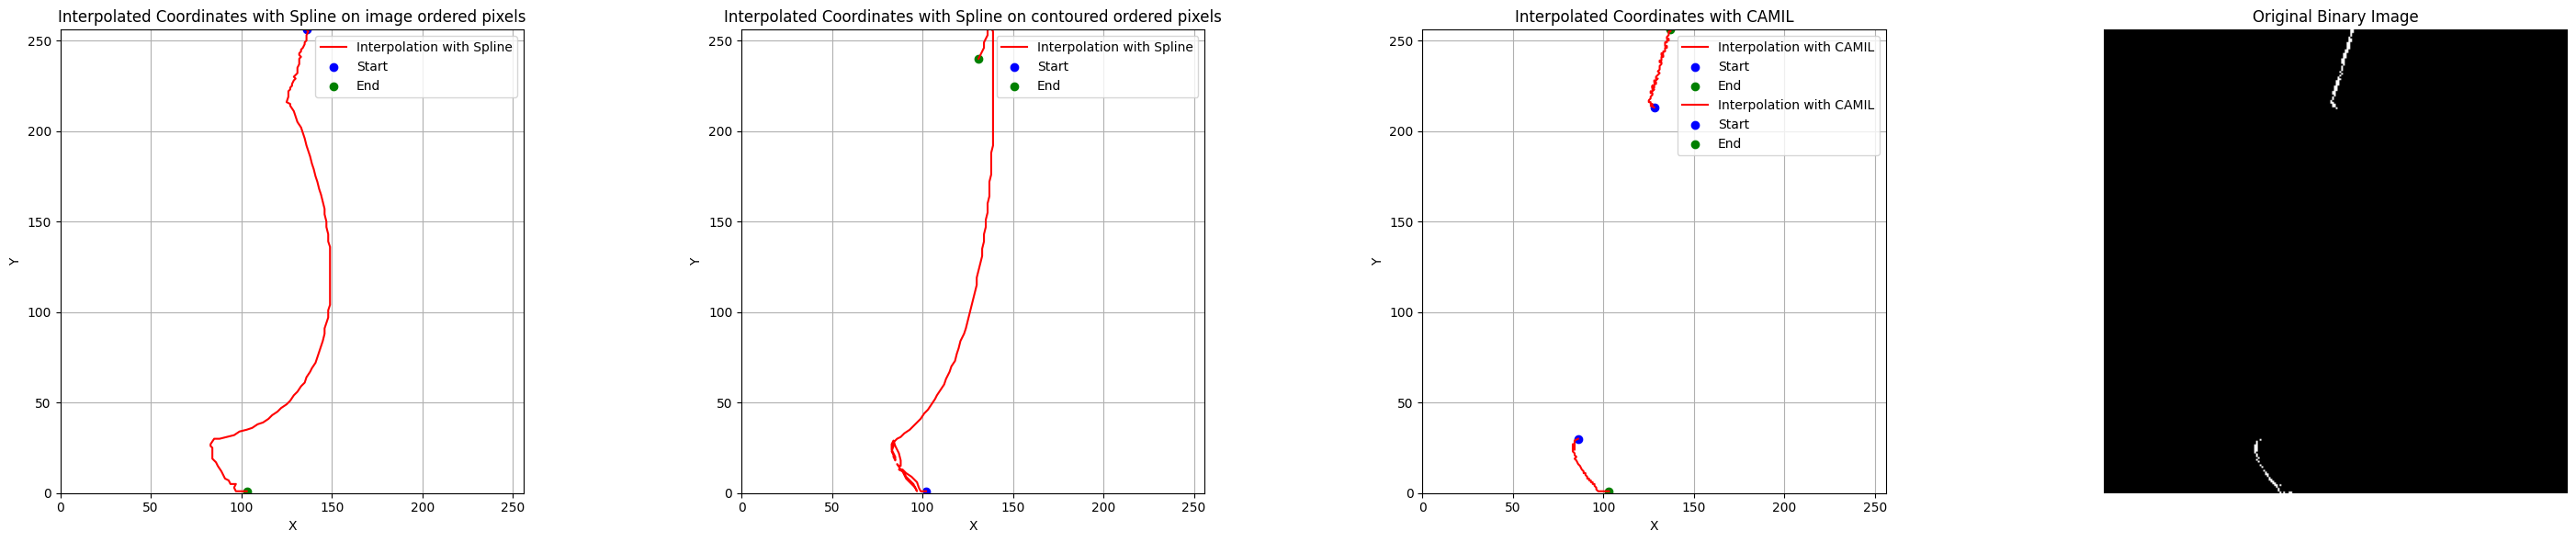

curves: 1


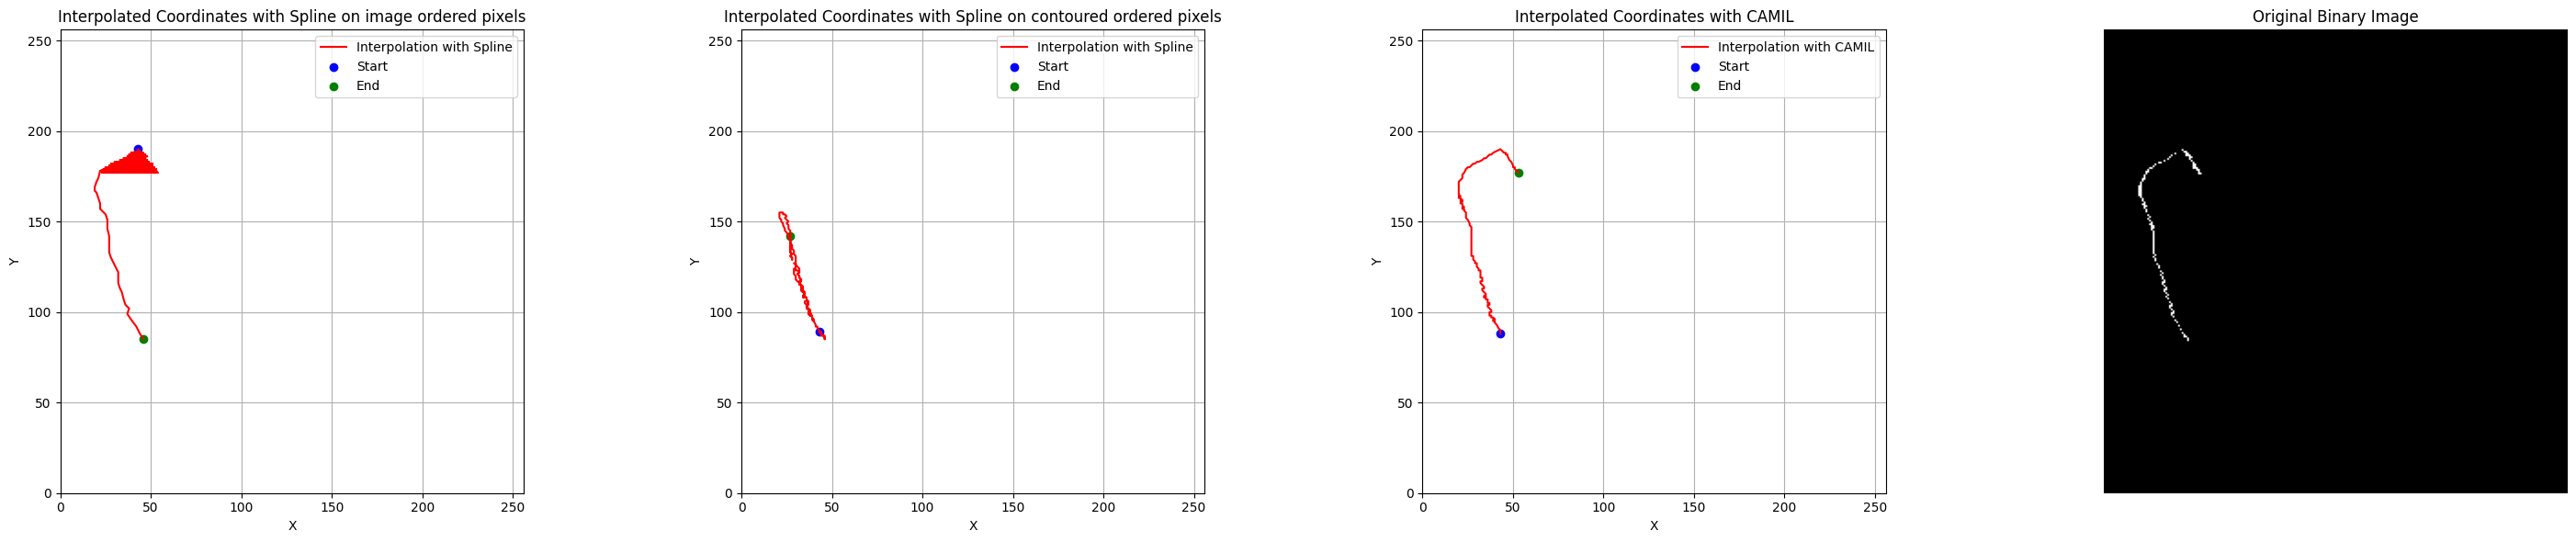

curves: 1


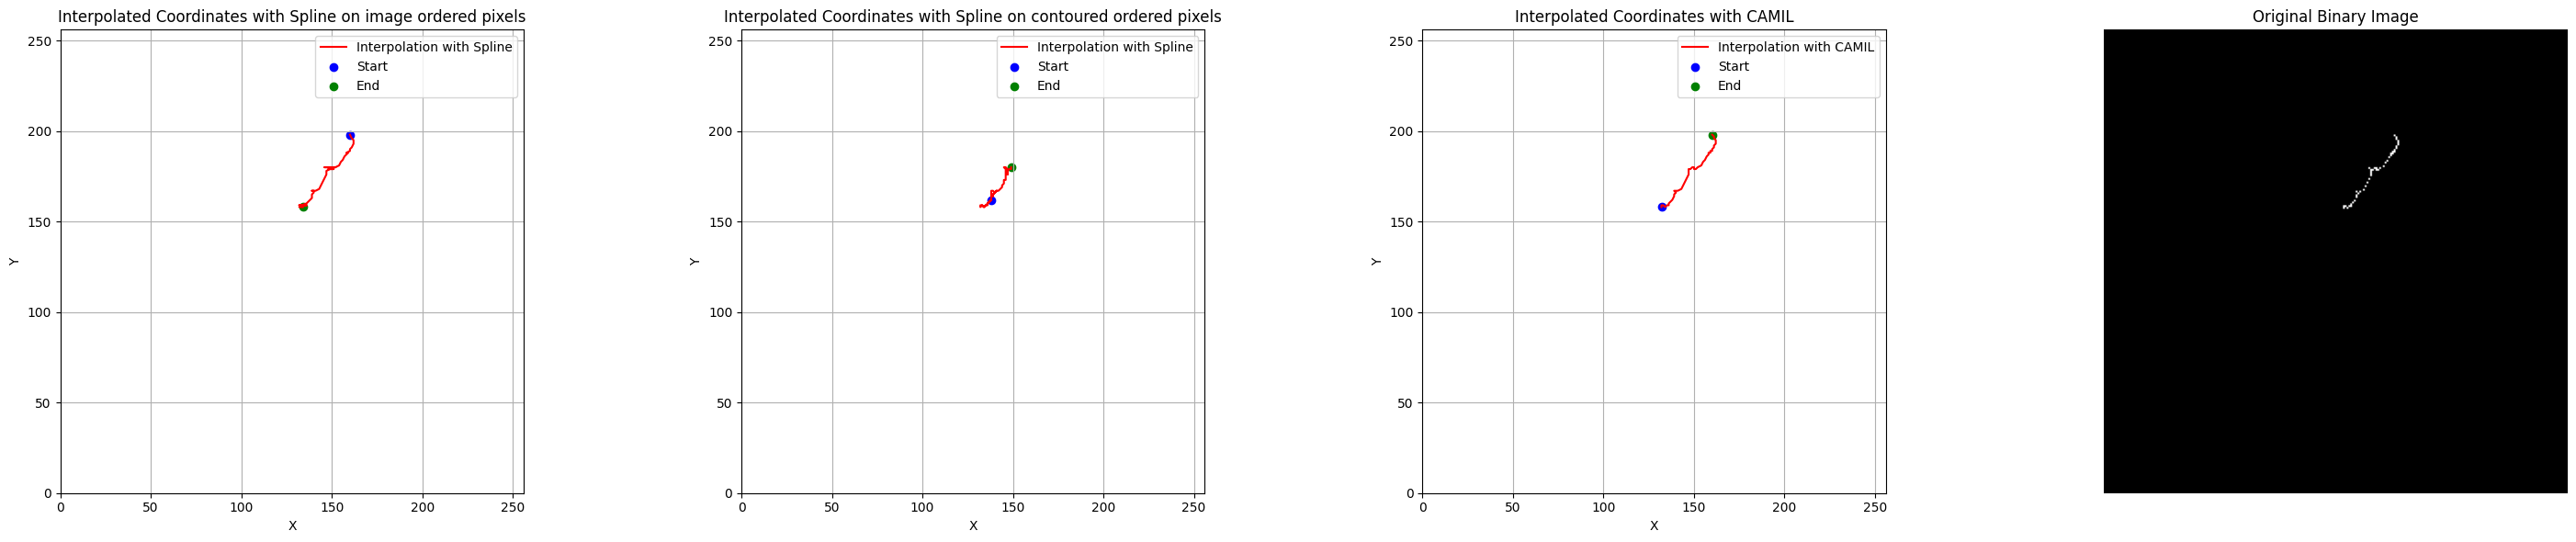

curves: 1


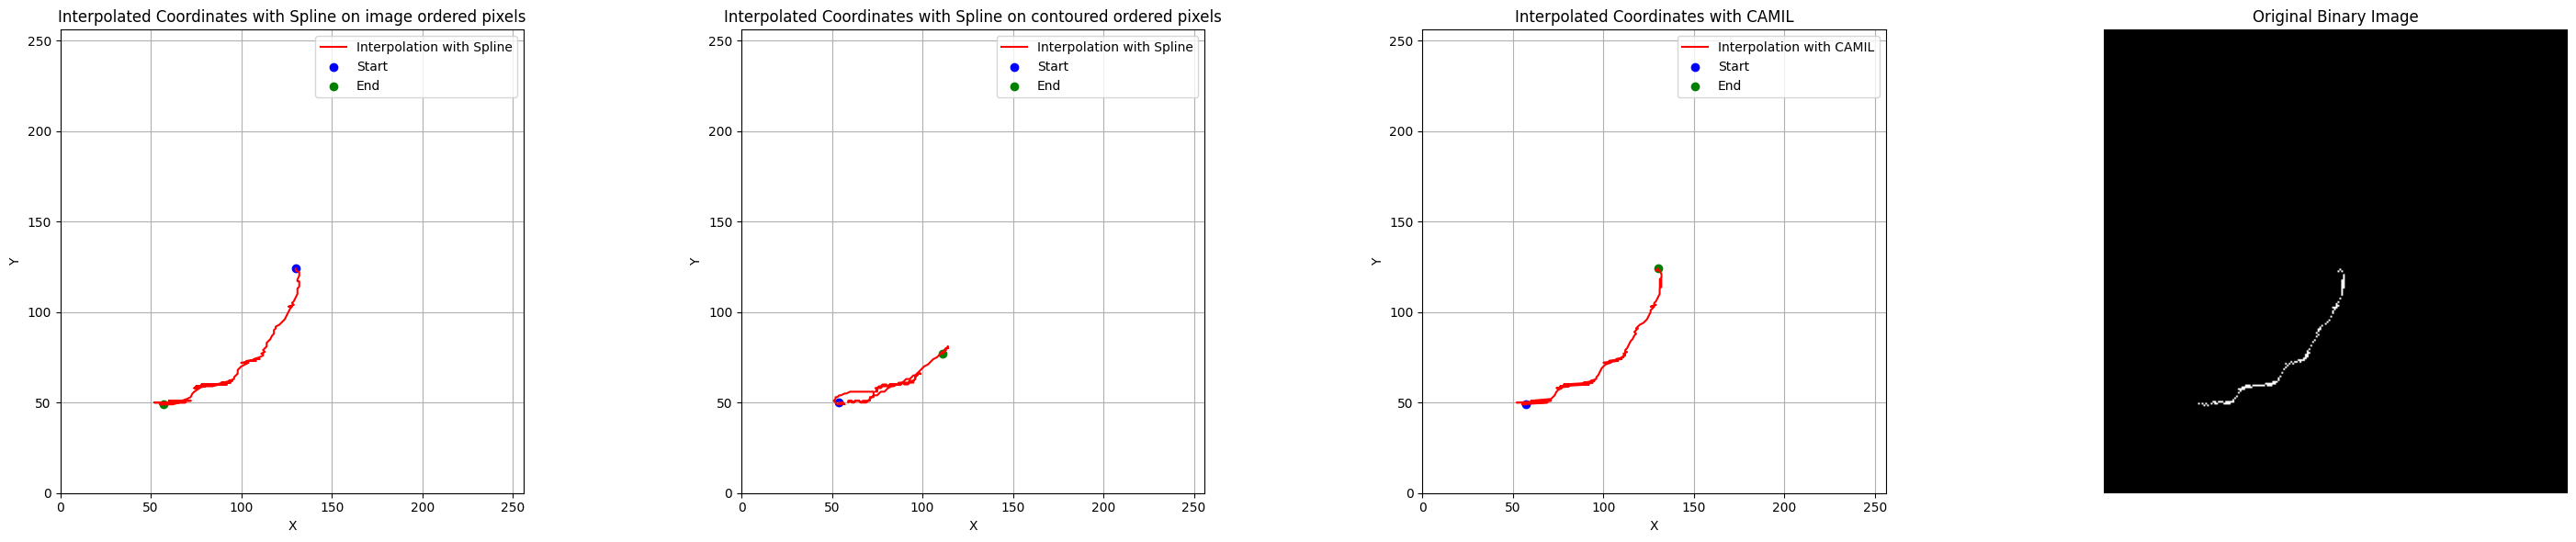

curves: 1


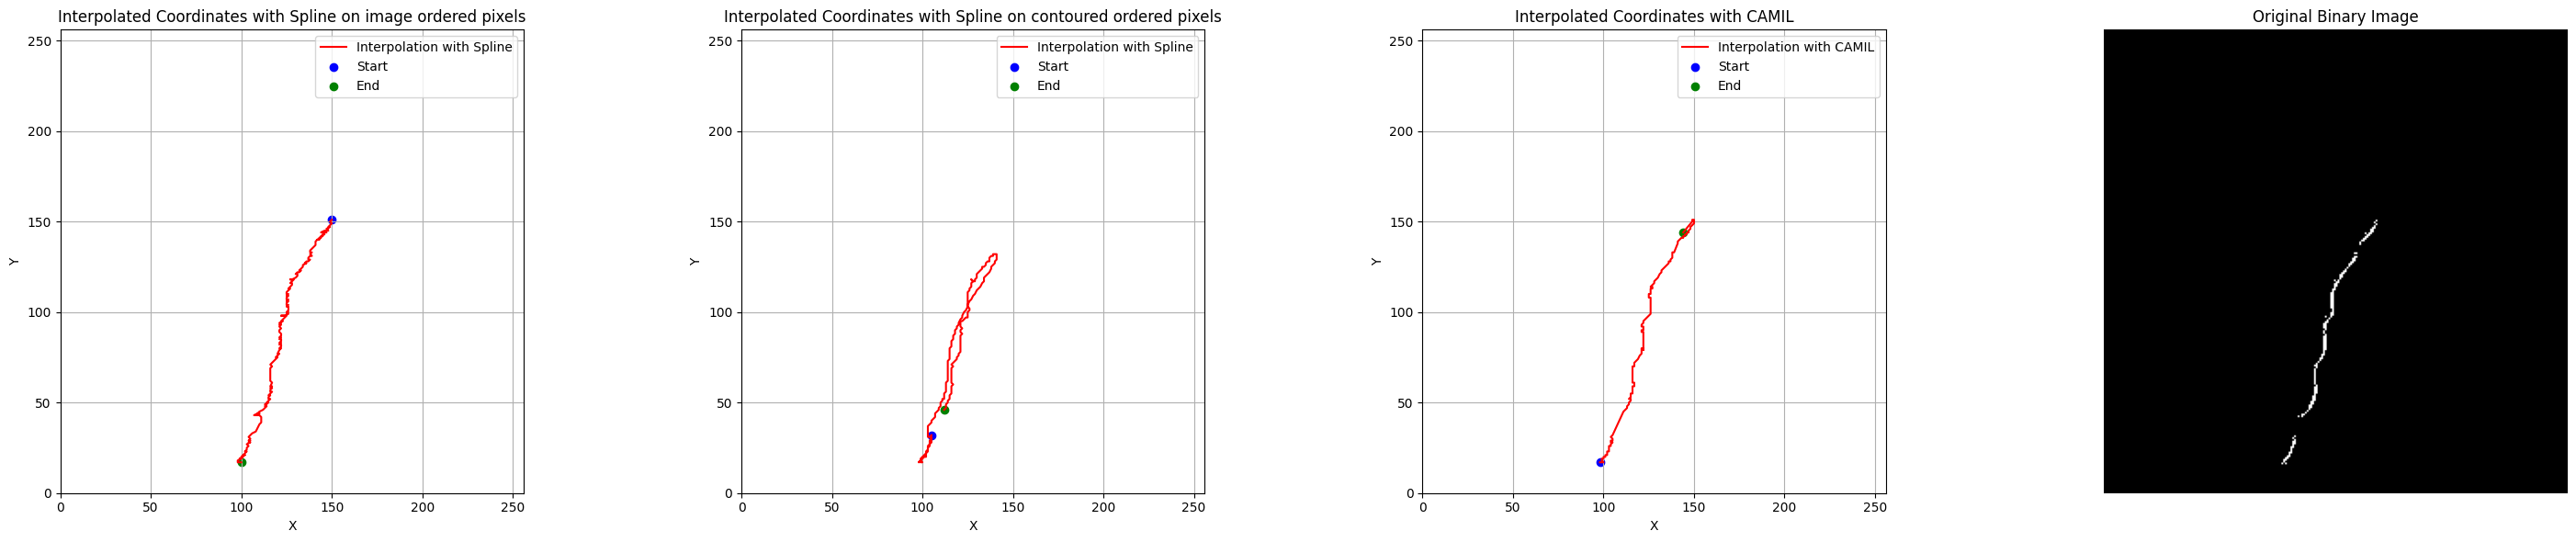

curves: 1


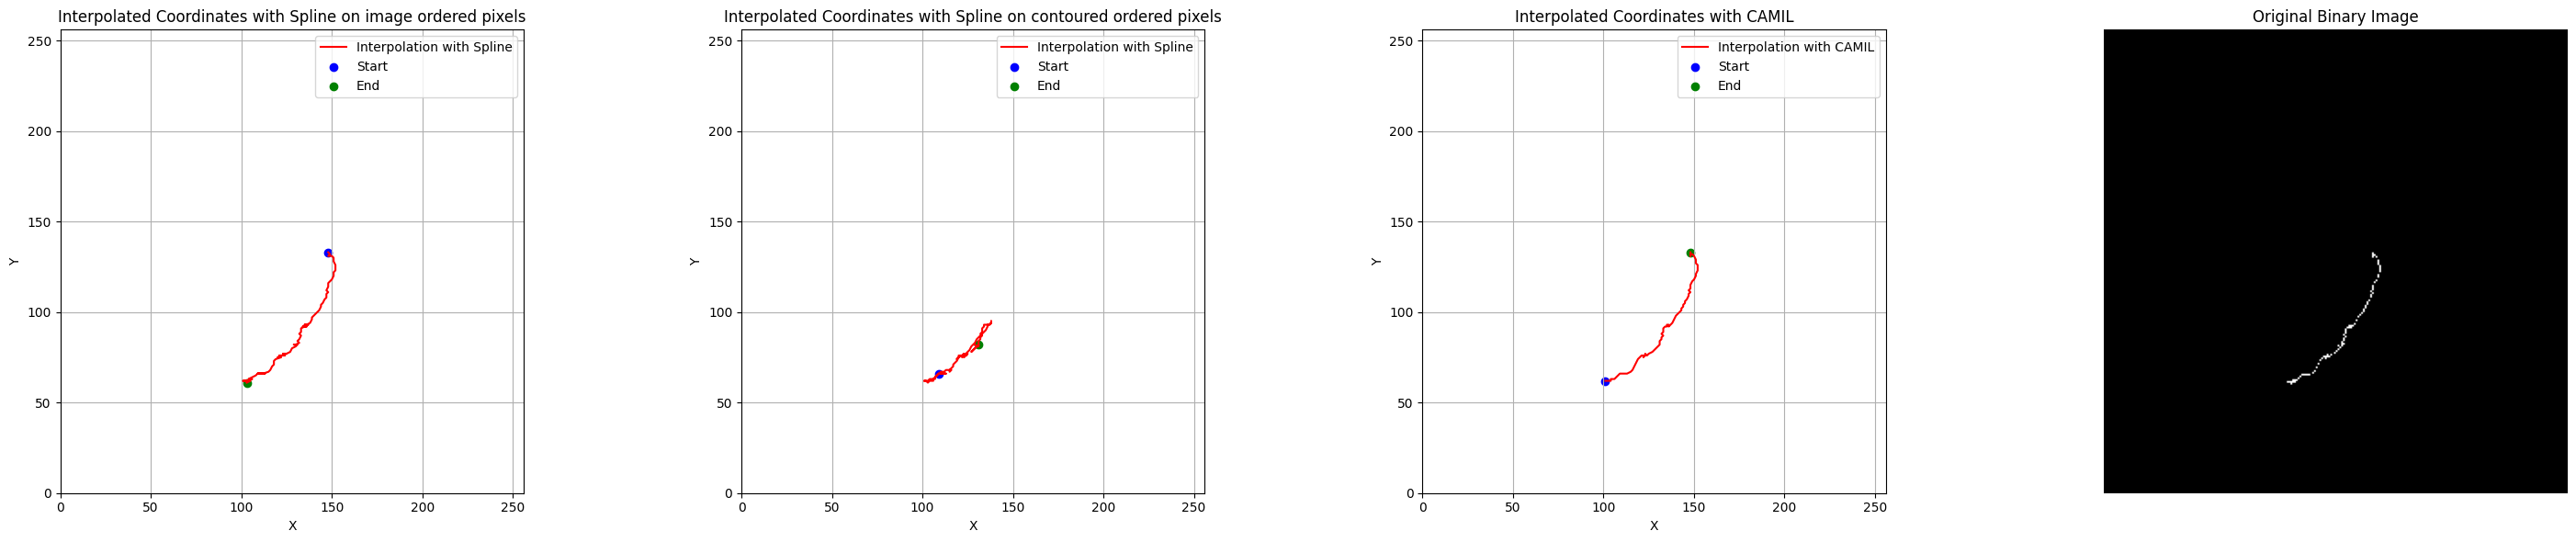

curves: 1


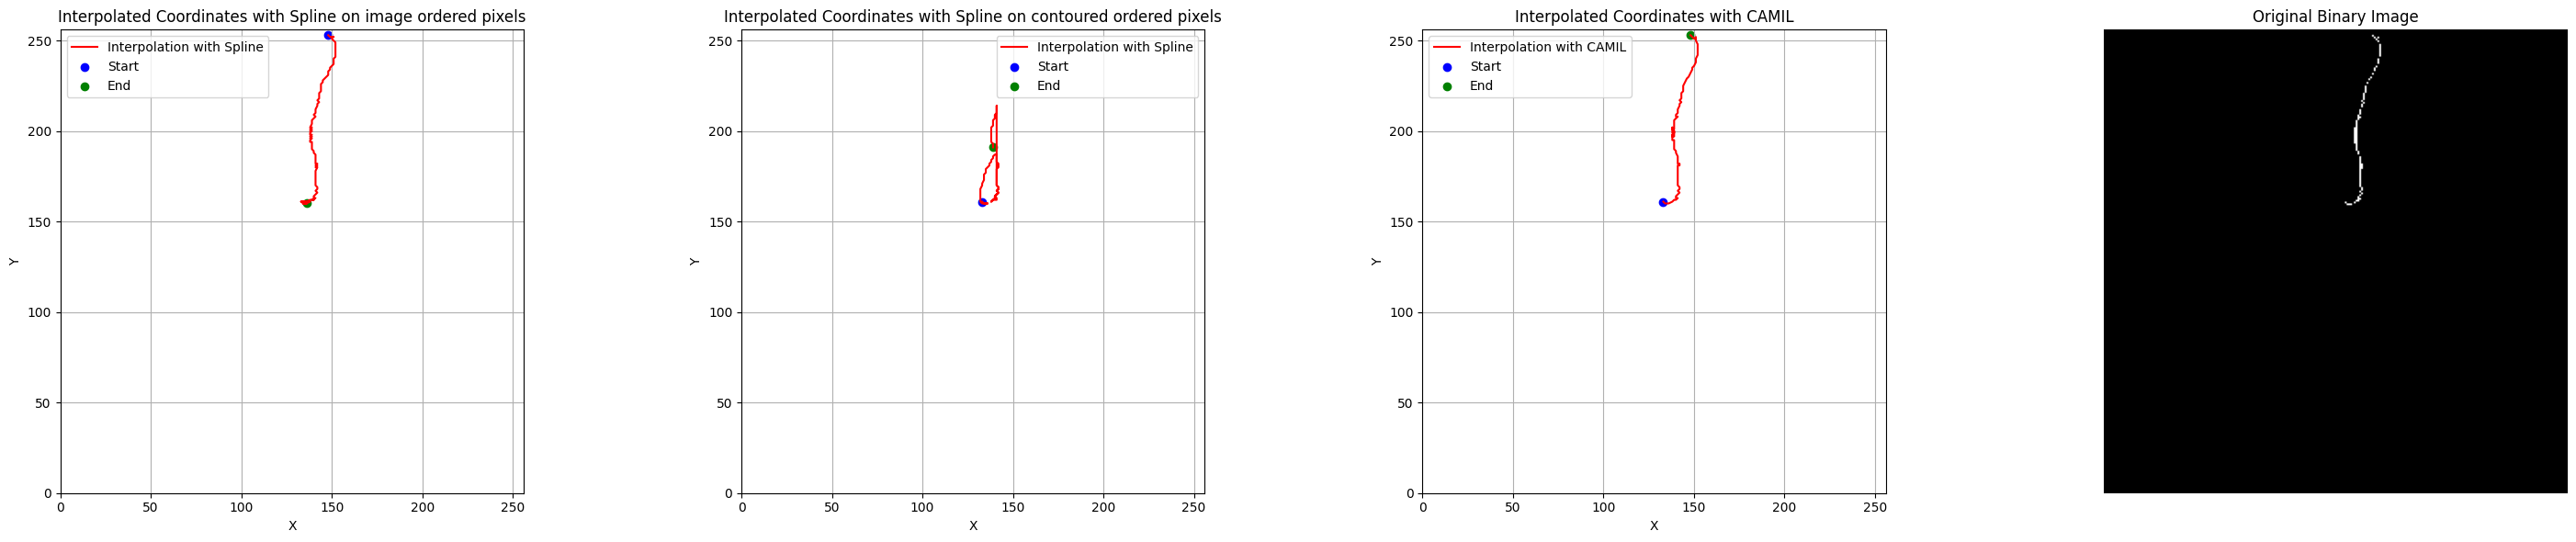

curves: 1


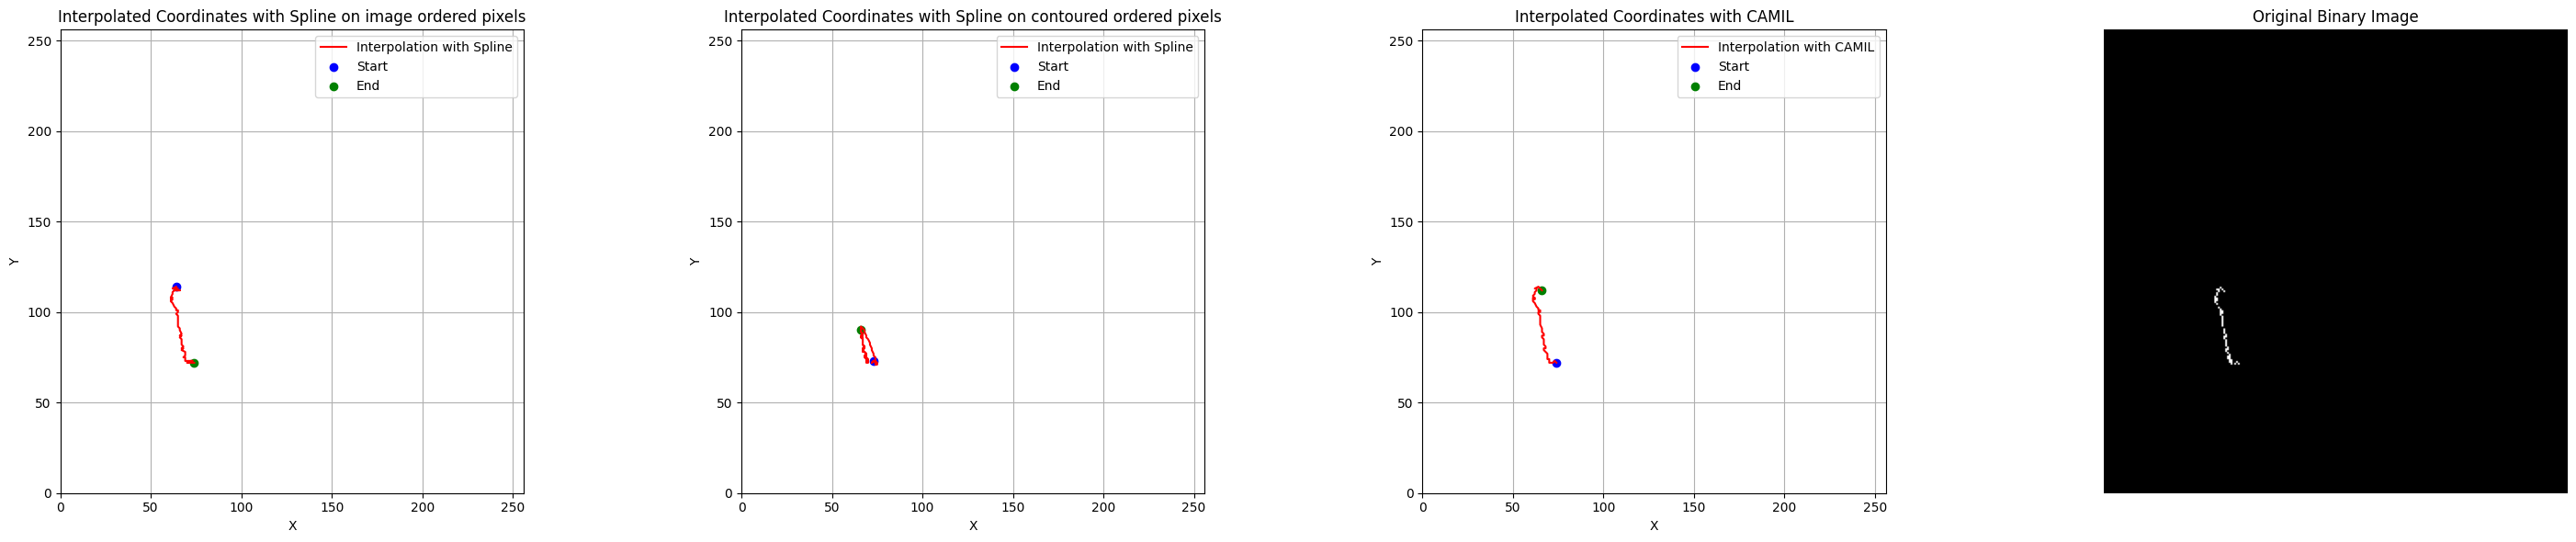

curves: 1


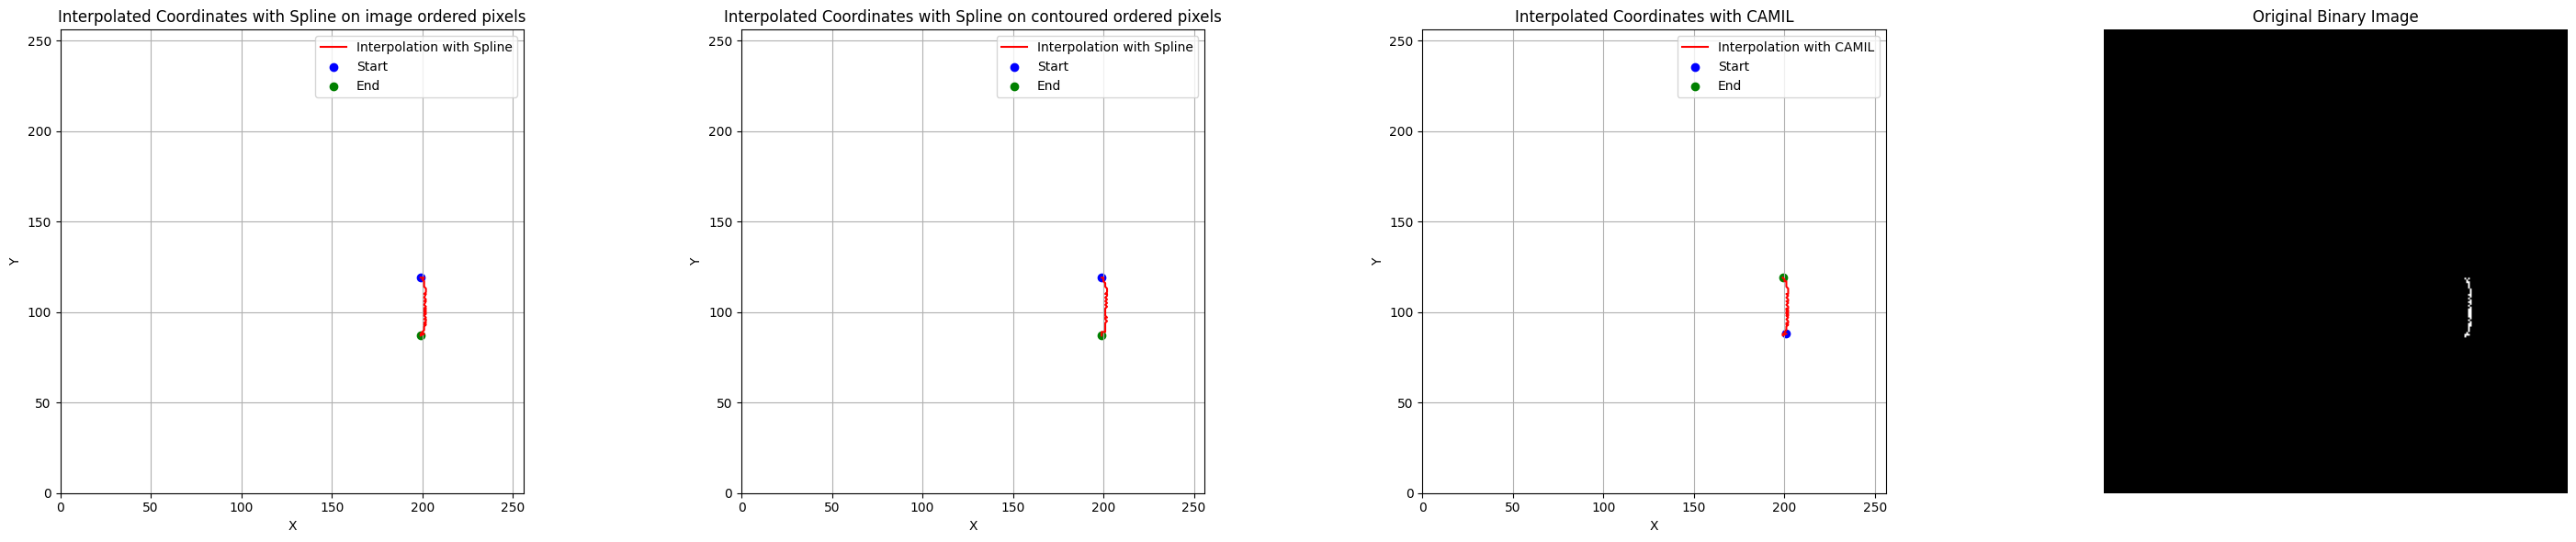

curves: 1


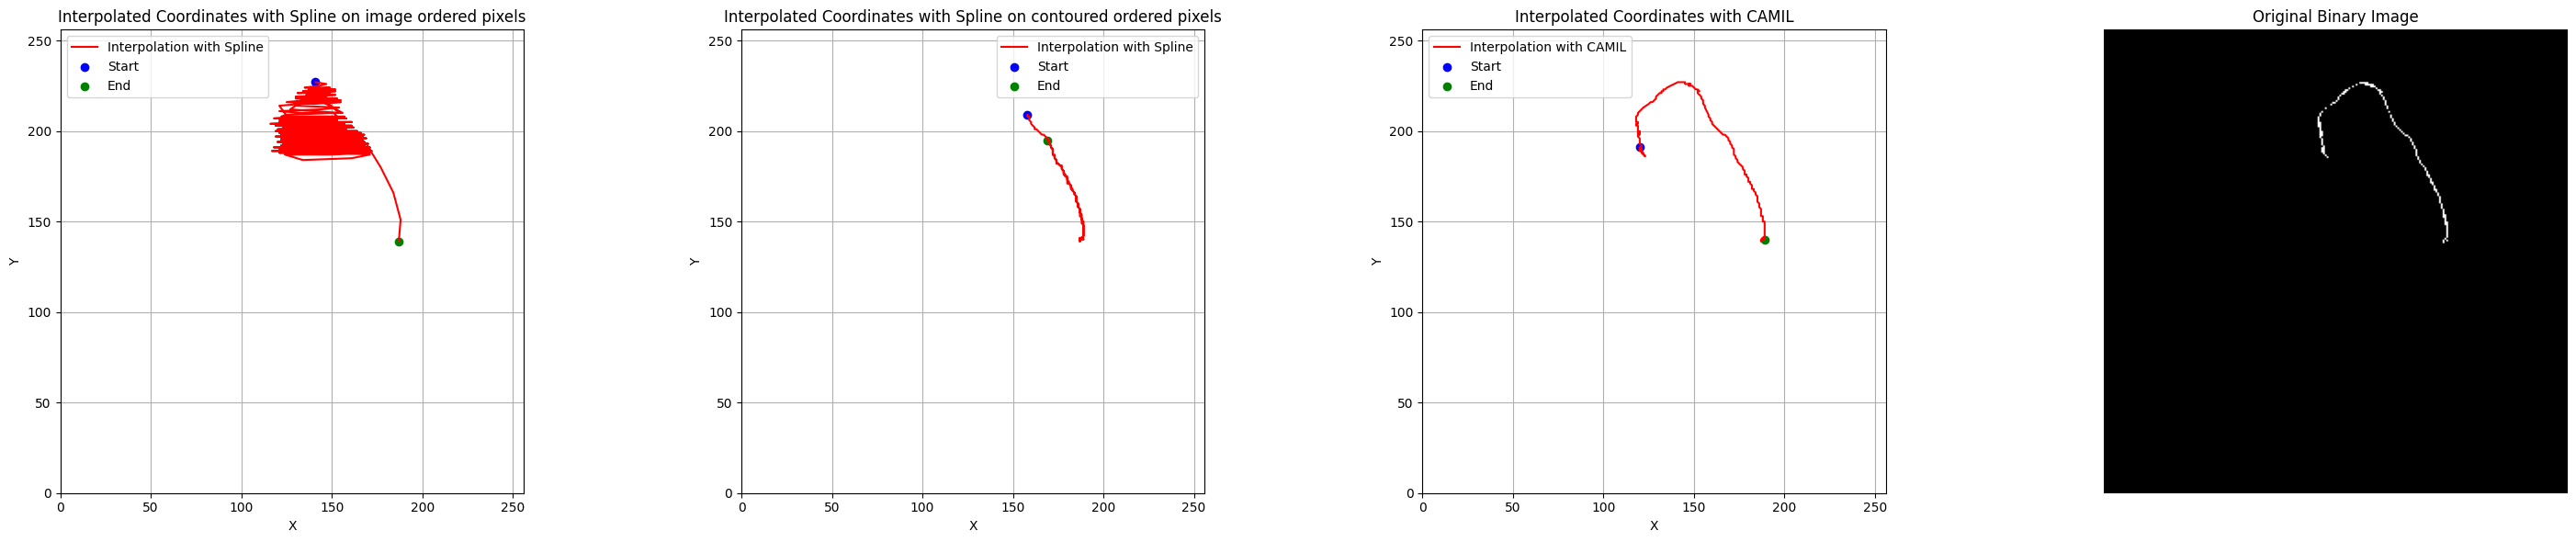

curves: 1


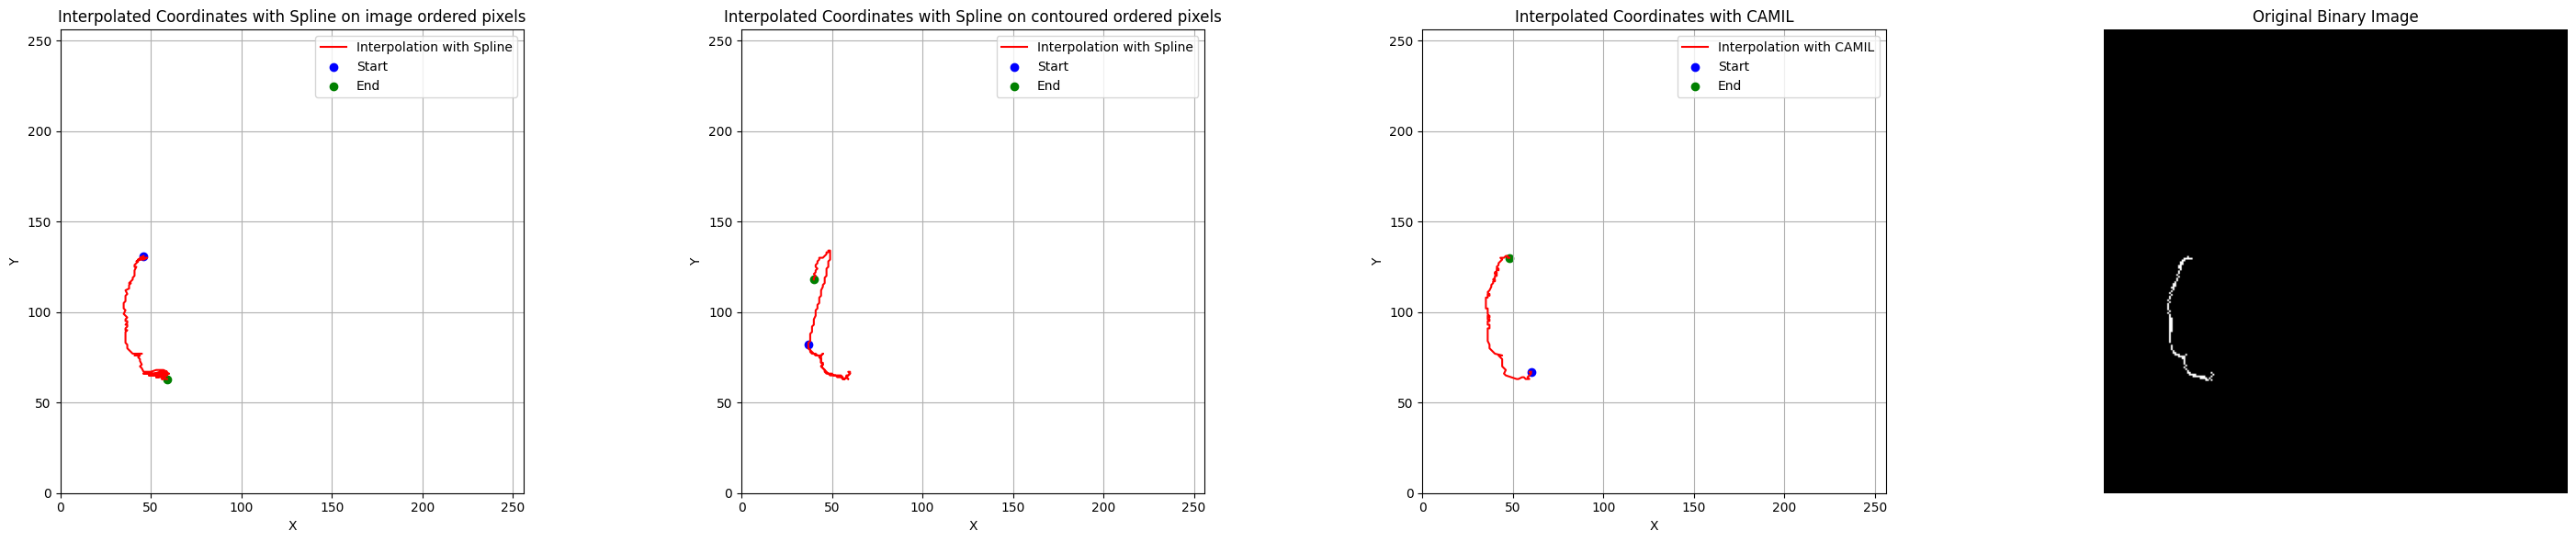

curves: 1


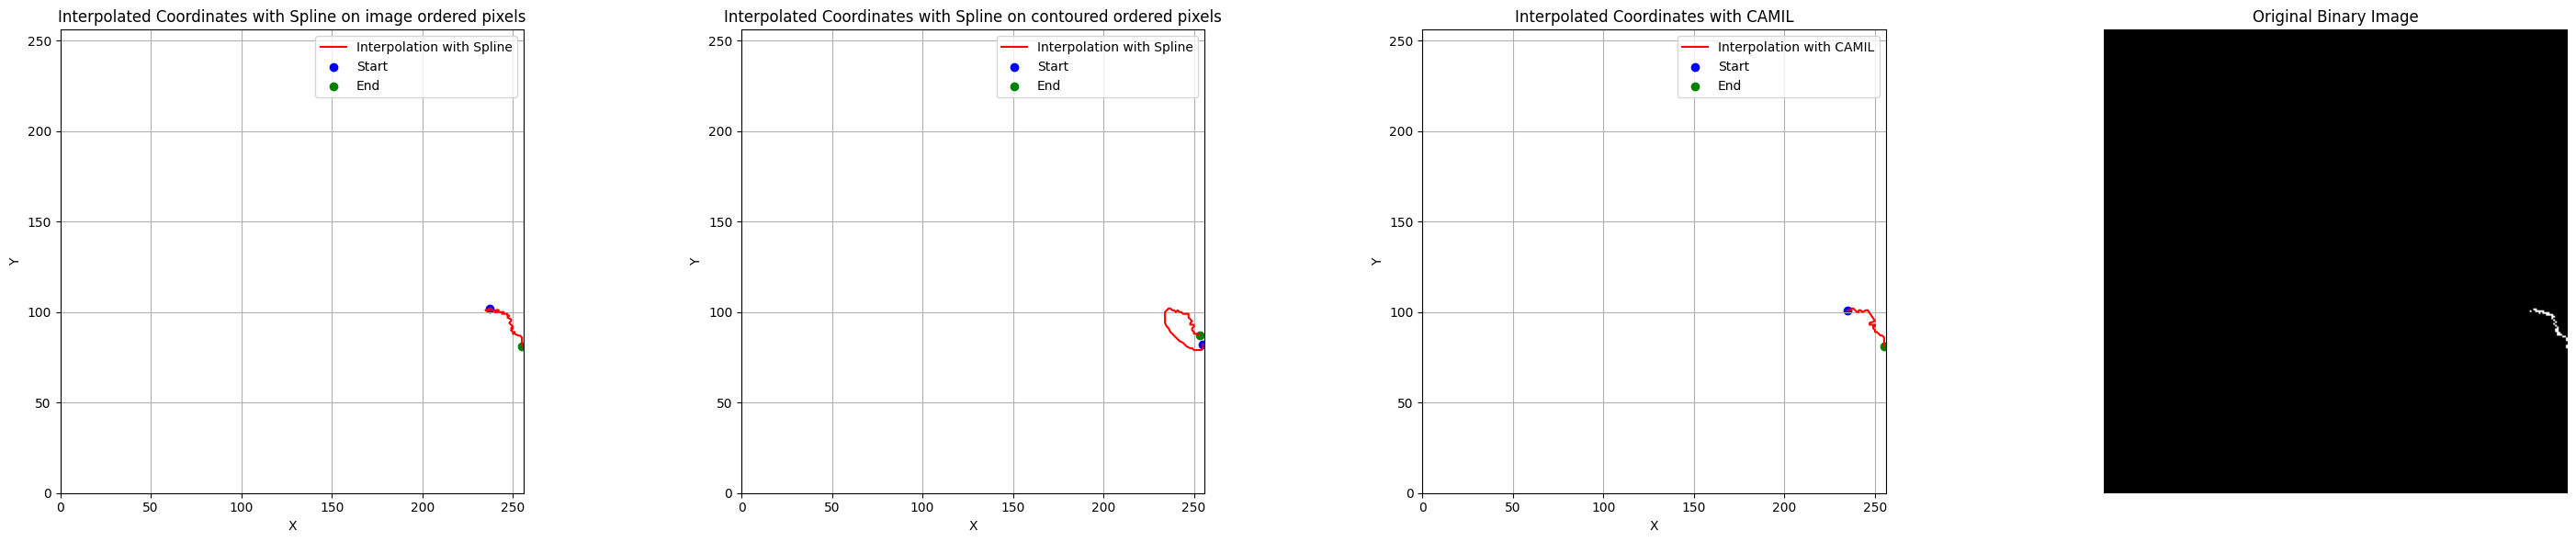

curves: 1


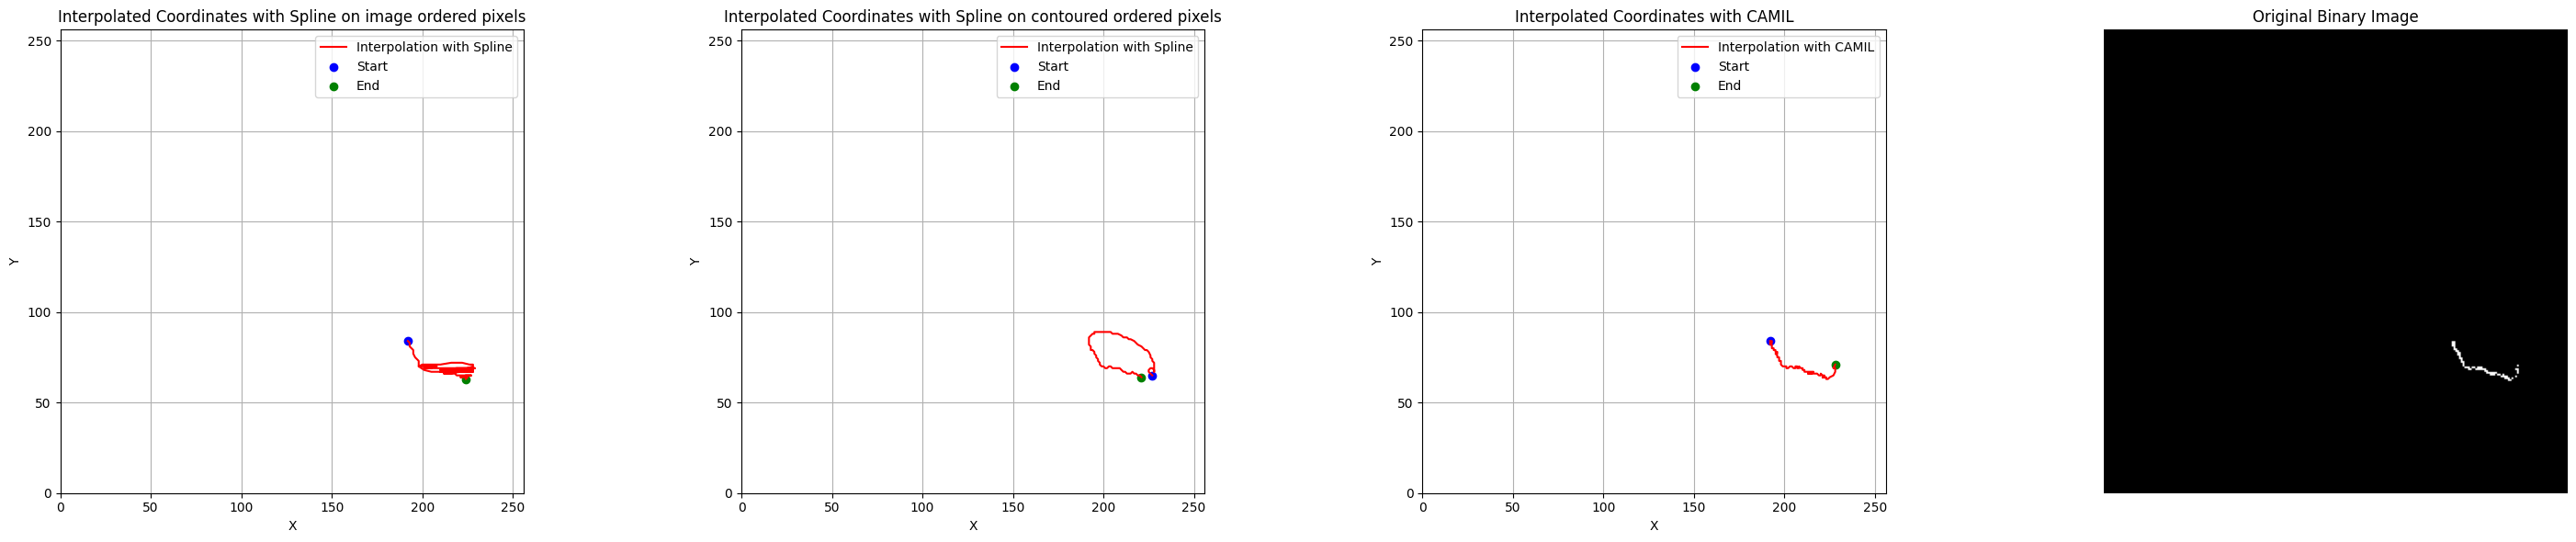

curves: 1


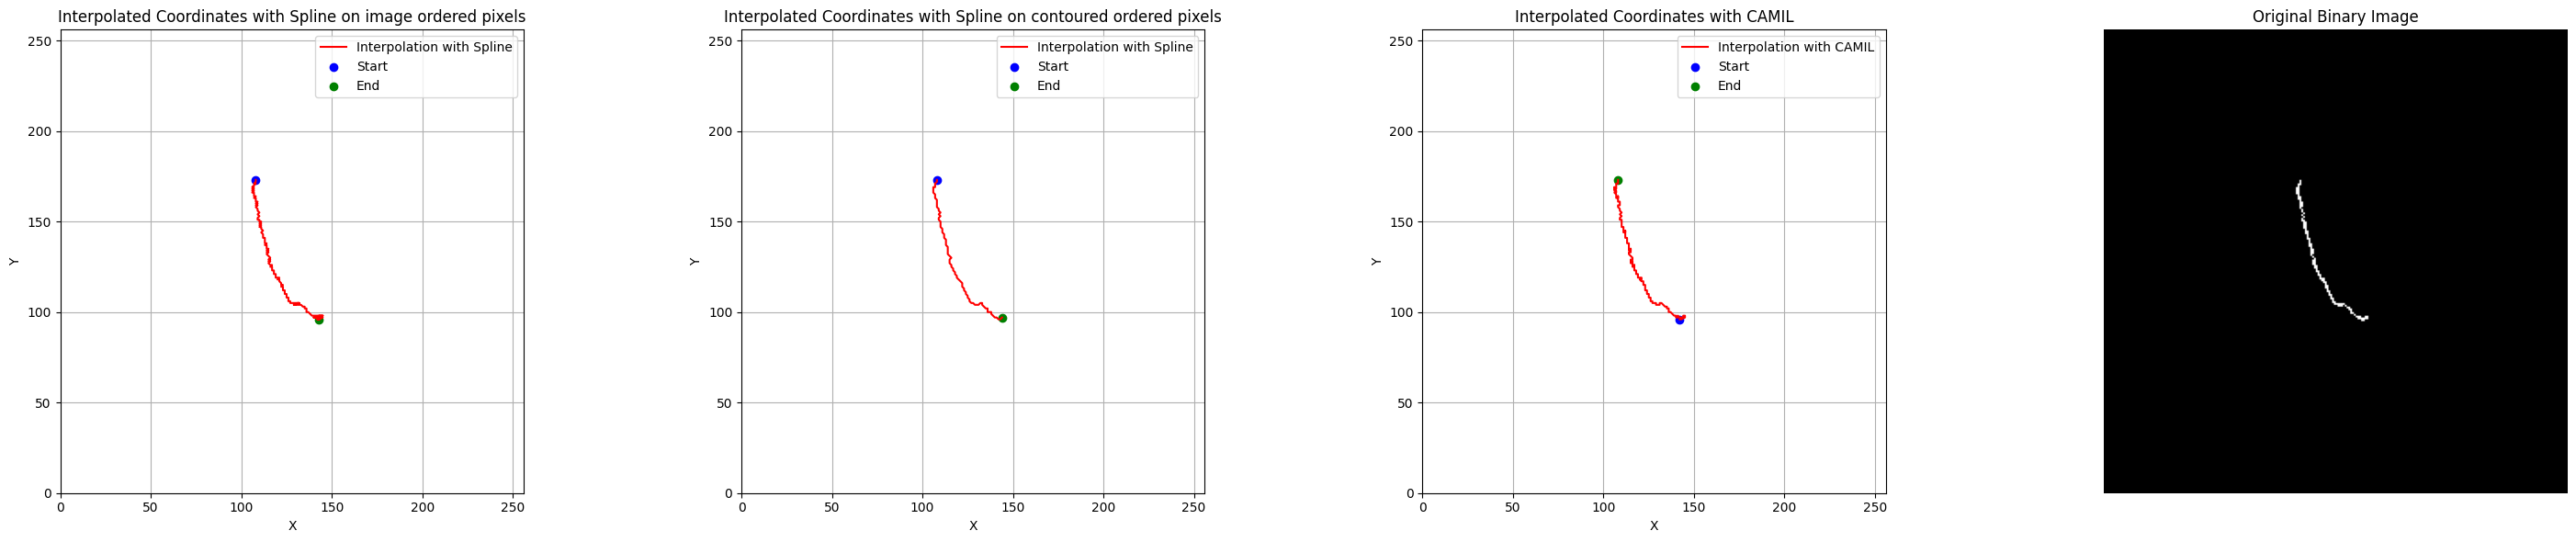

curves: 1


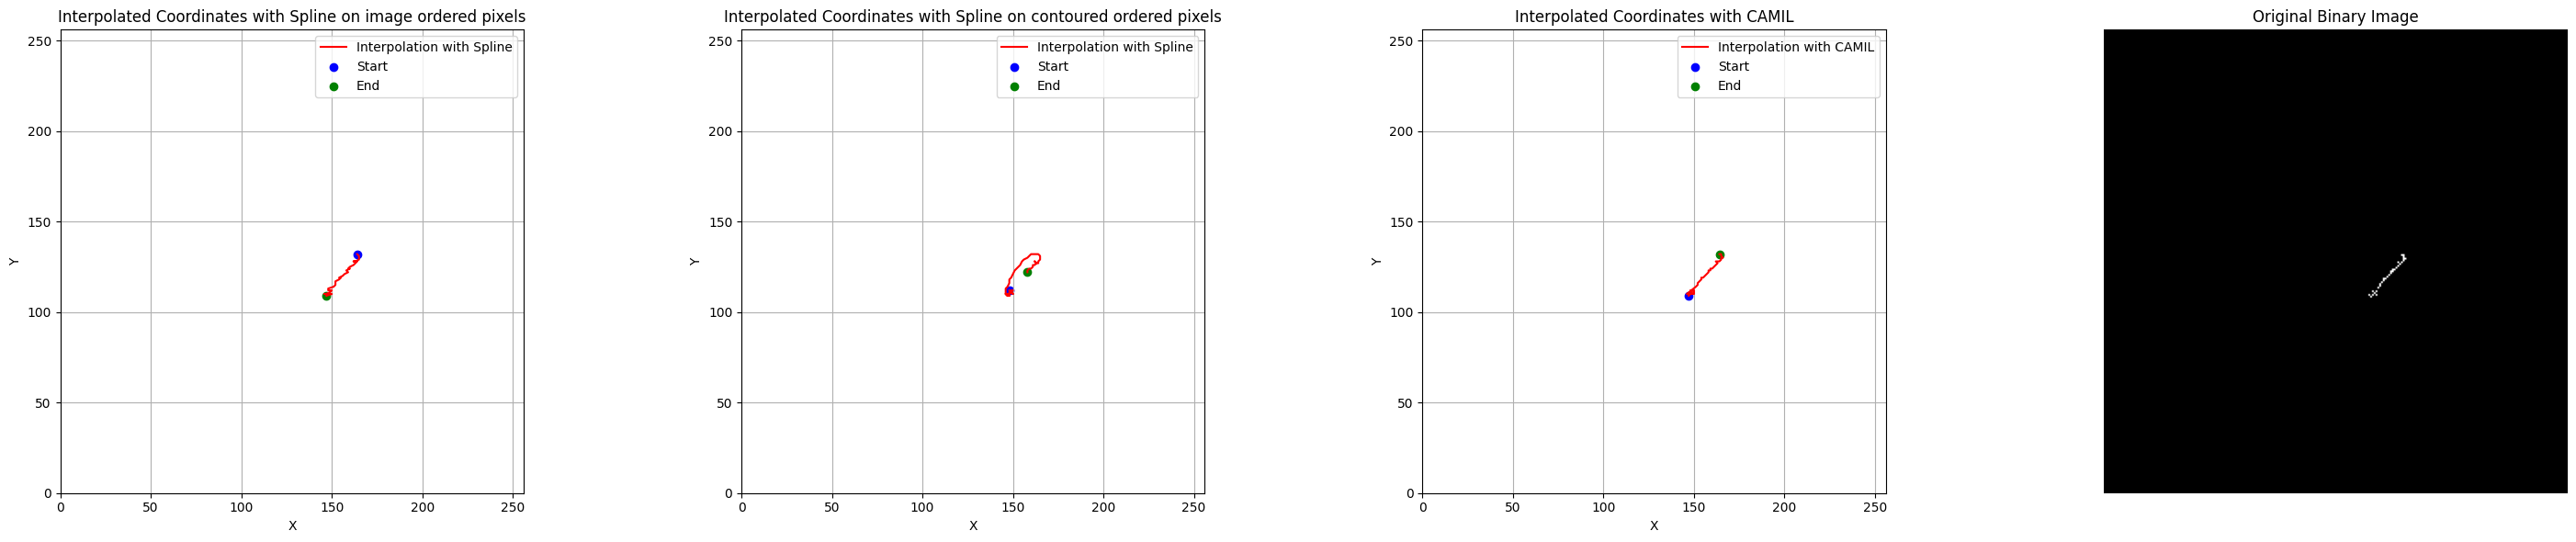

curves: 1


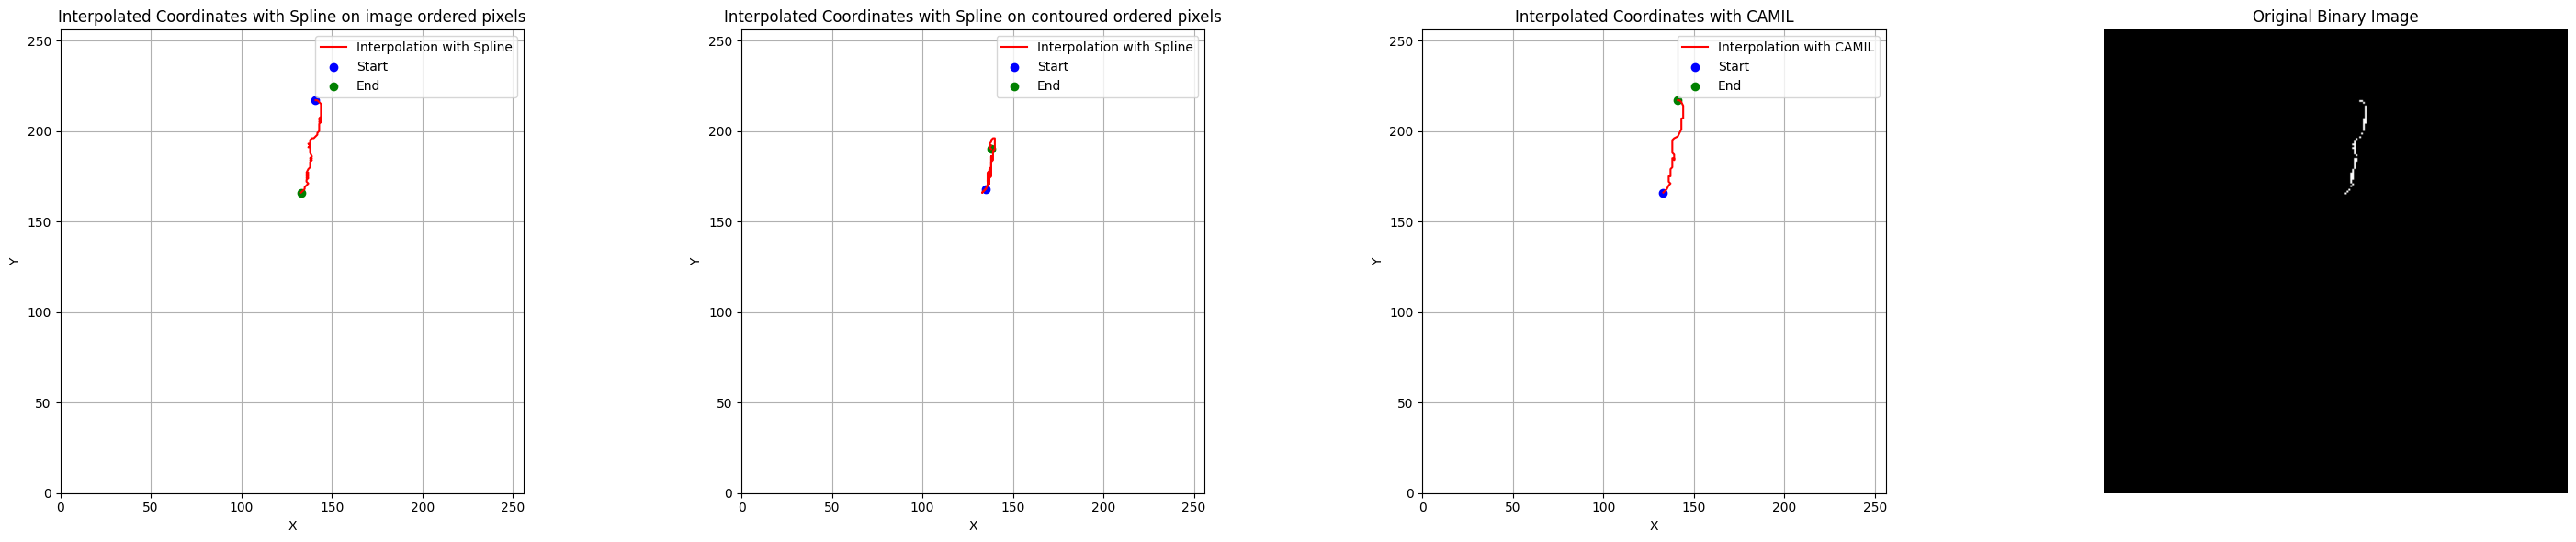

curves: 2
curves: 2


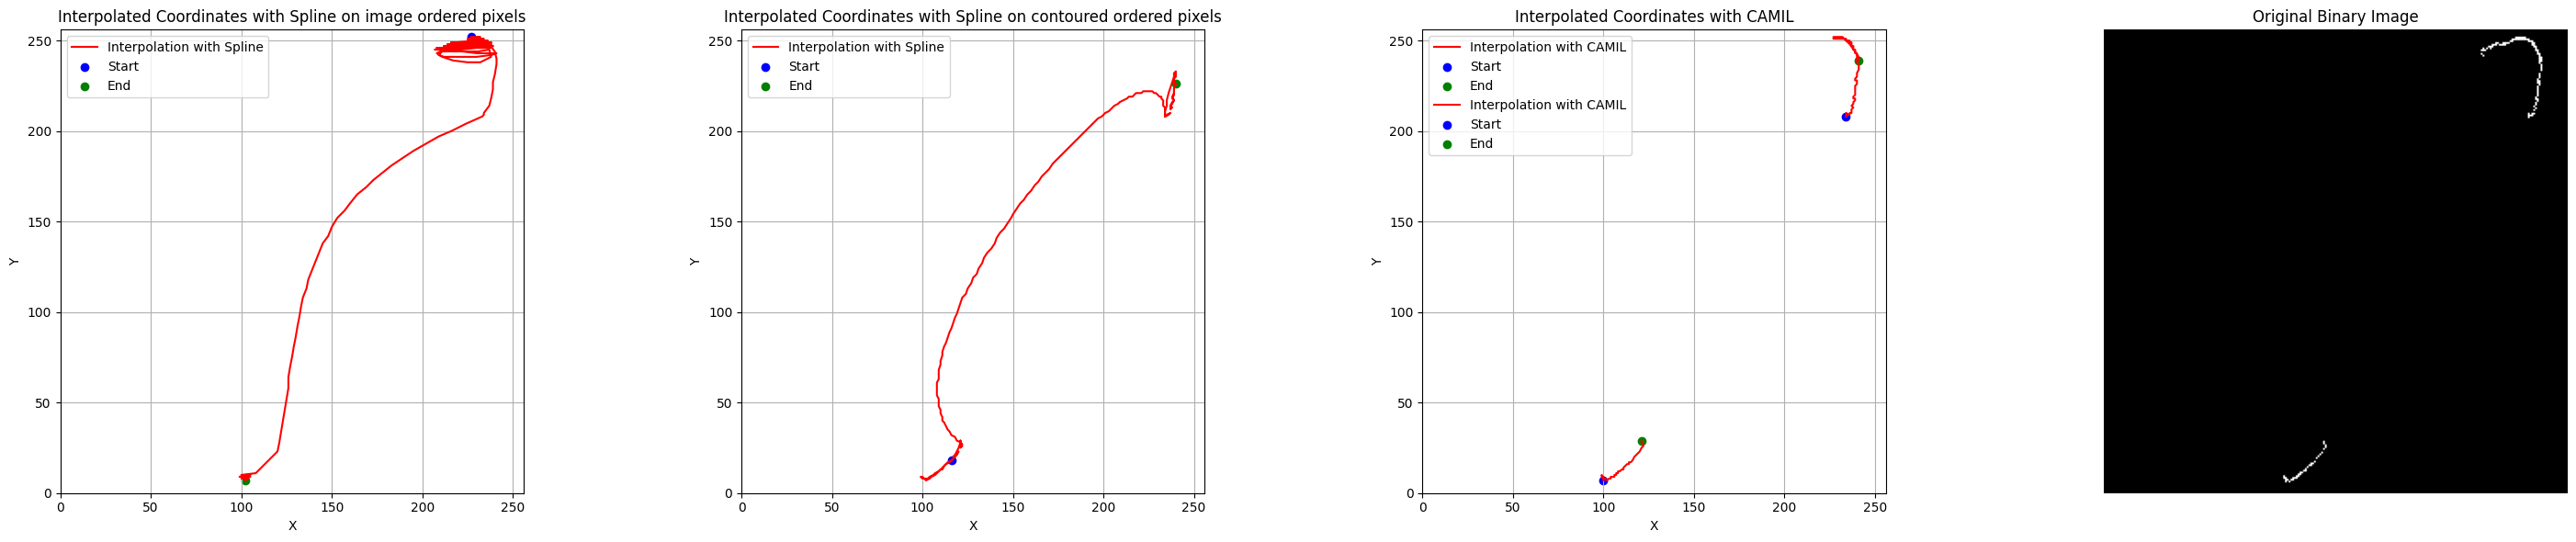

curves: 1


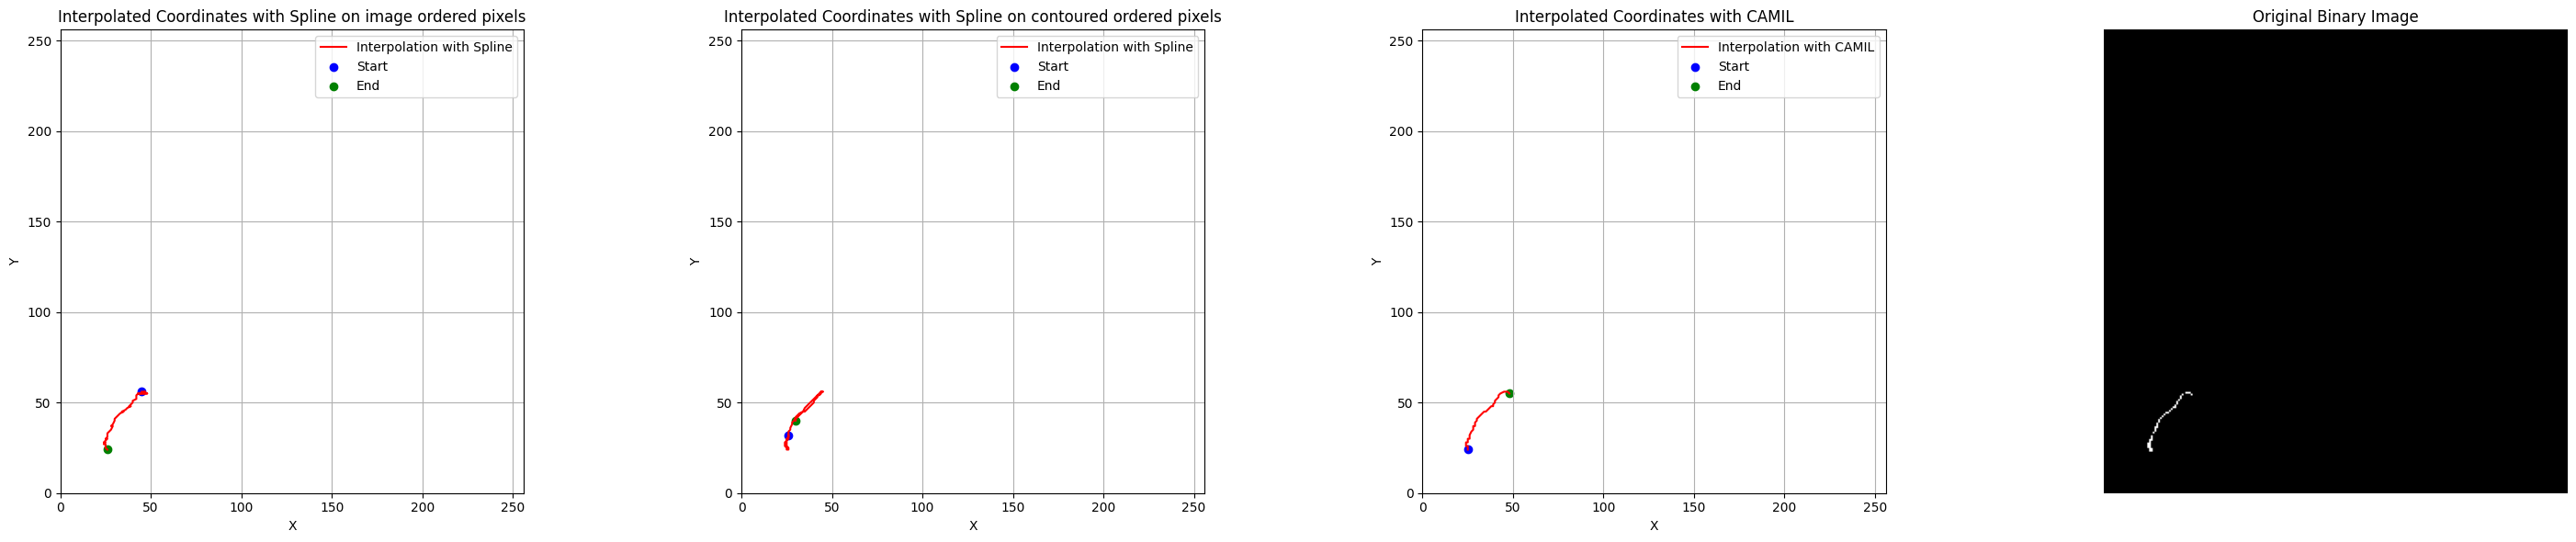

curves: 2
curves: 2


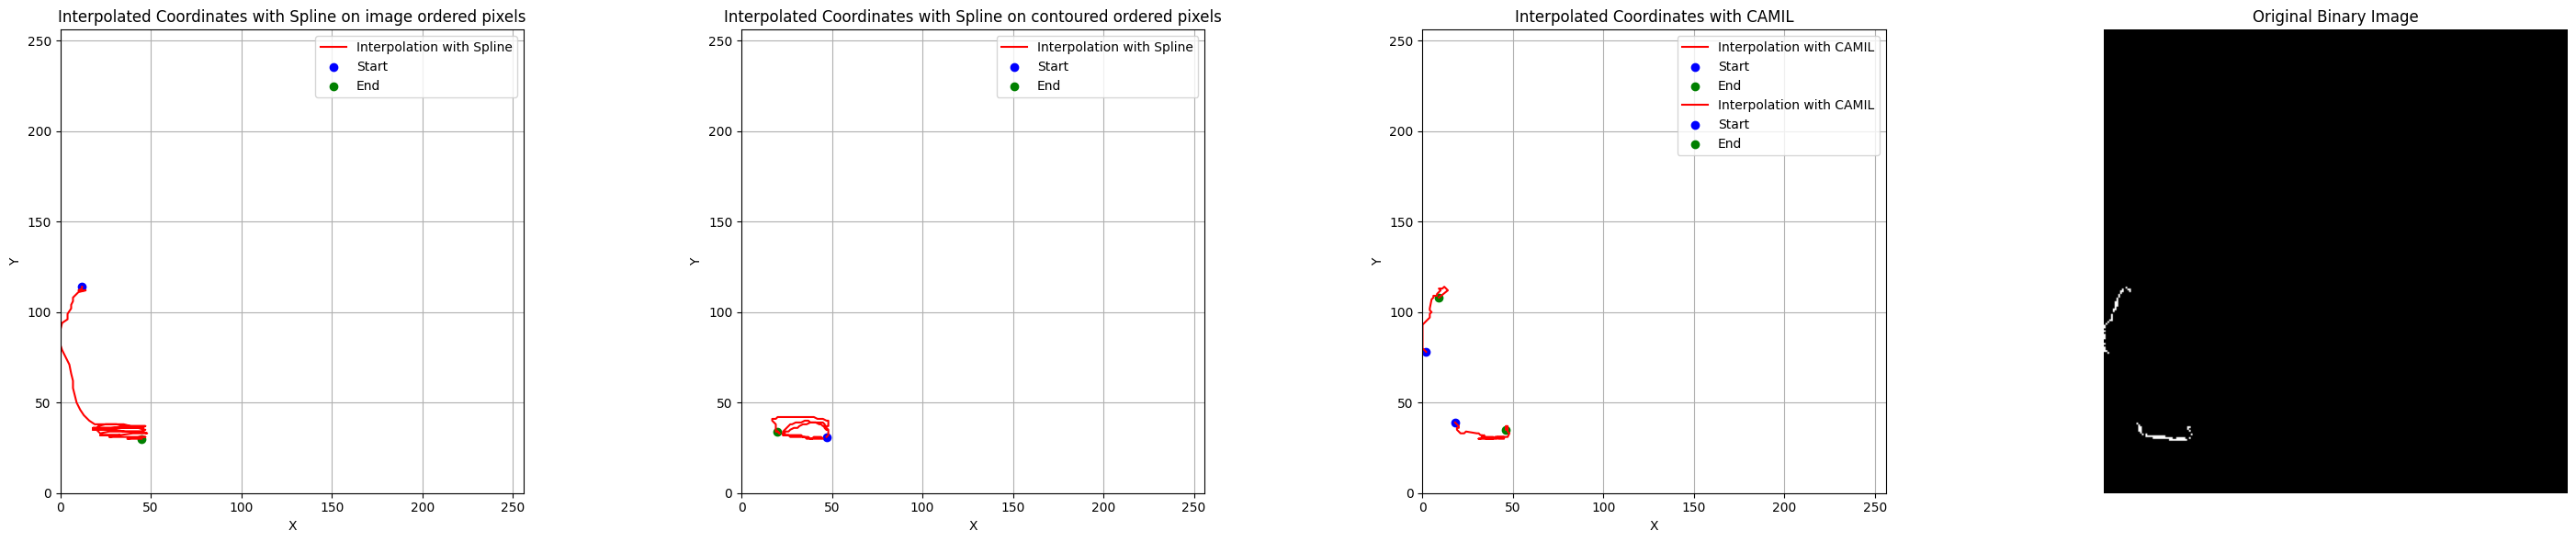

curves: 1


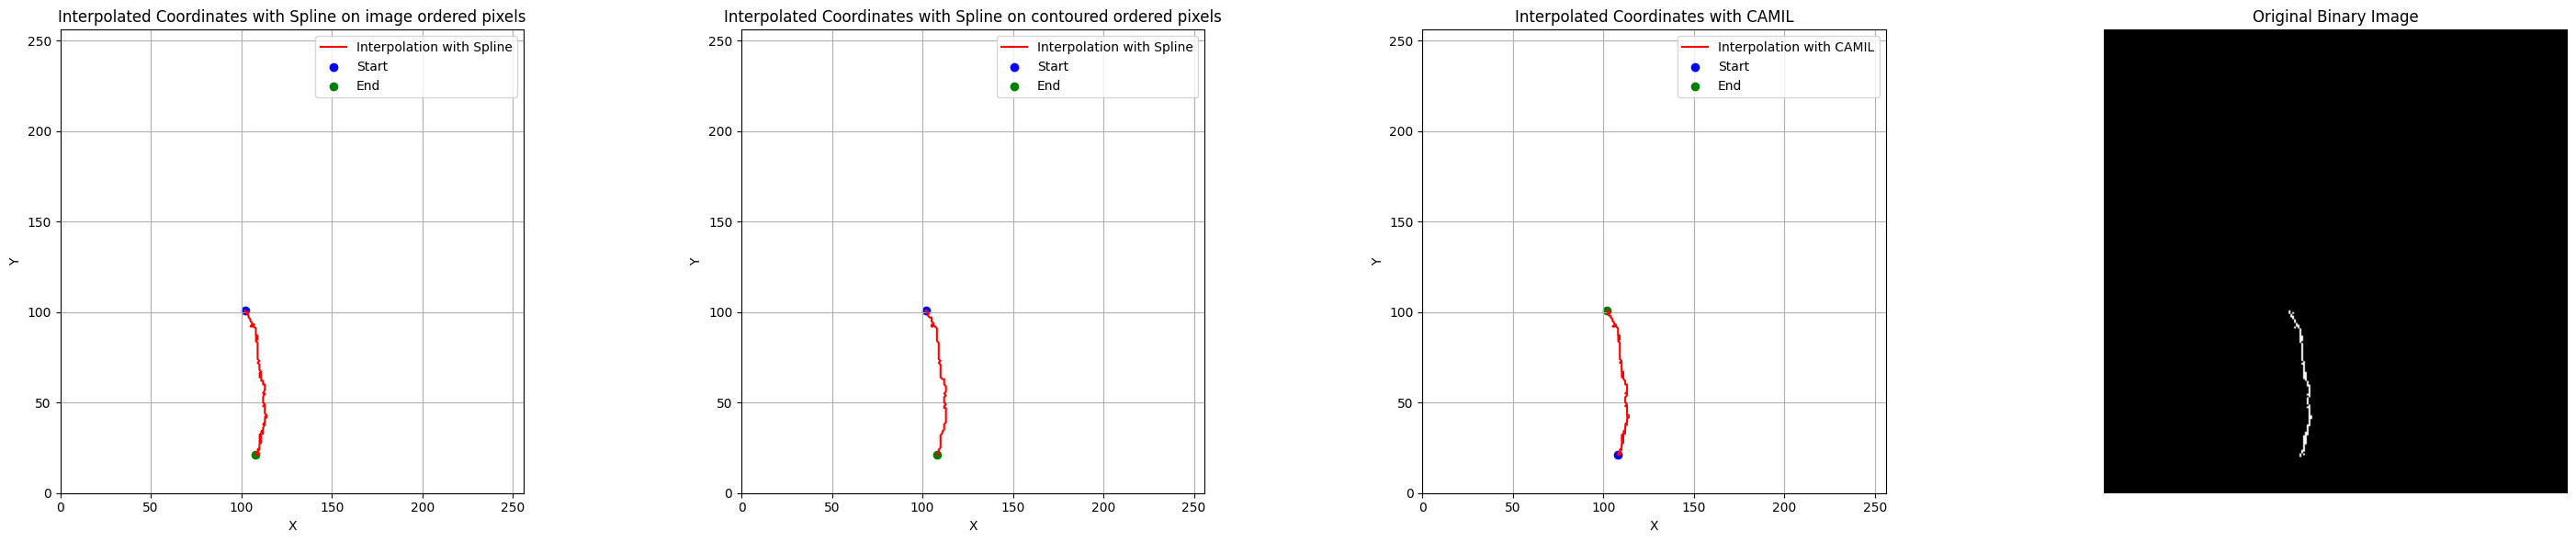

curves: 2
curves: 2


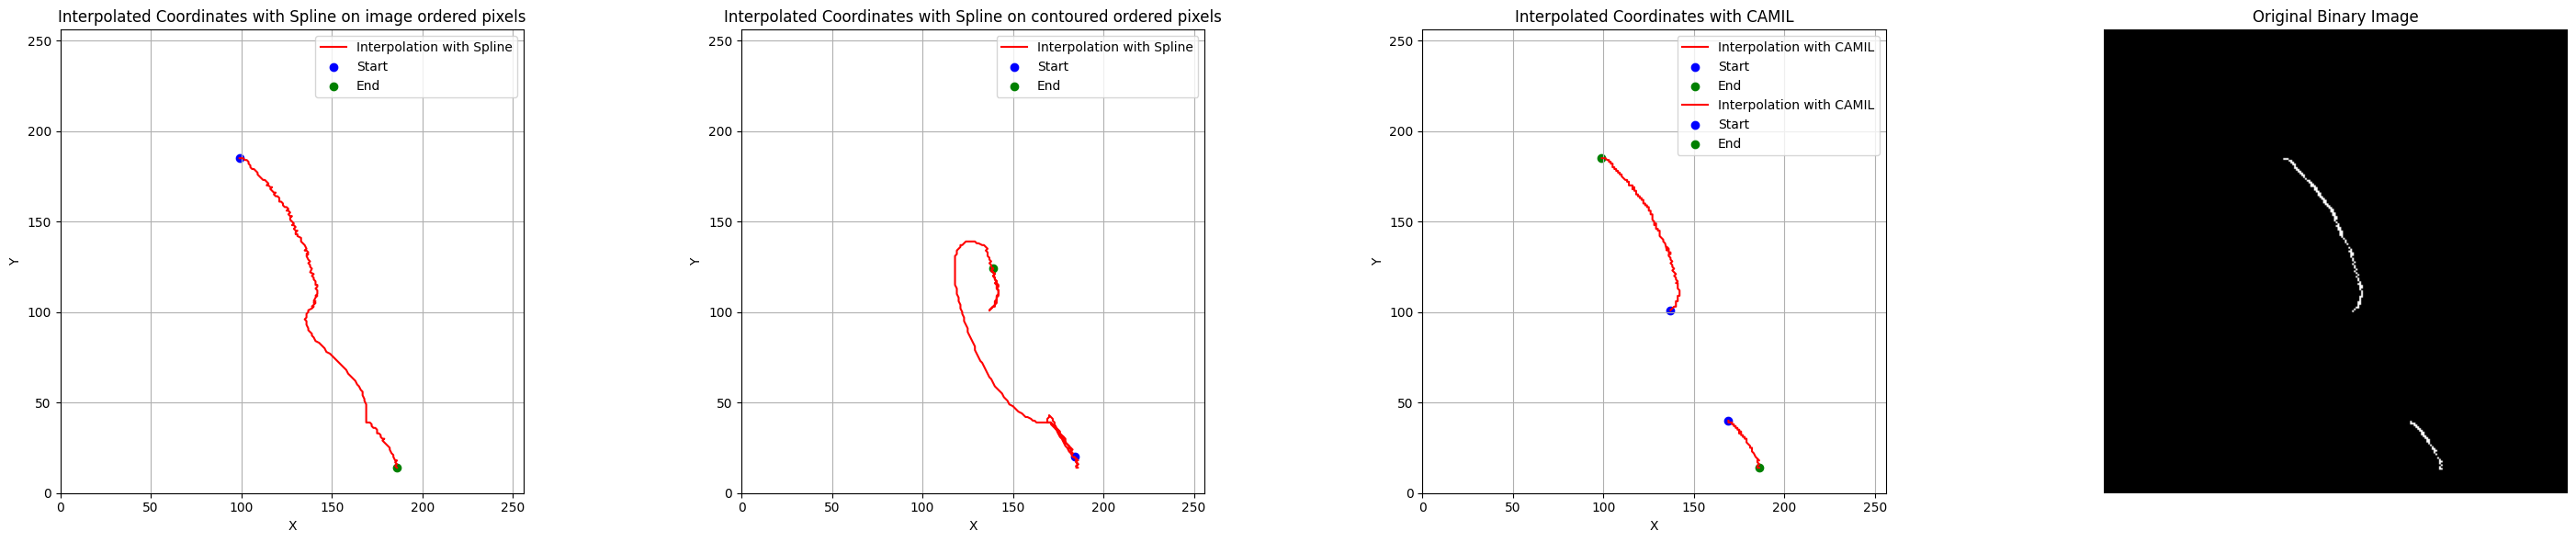

curves: 2
curves: 2


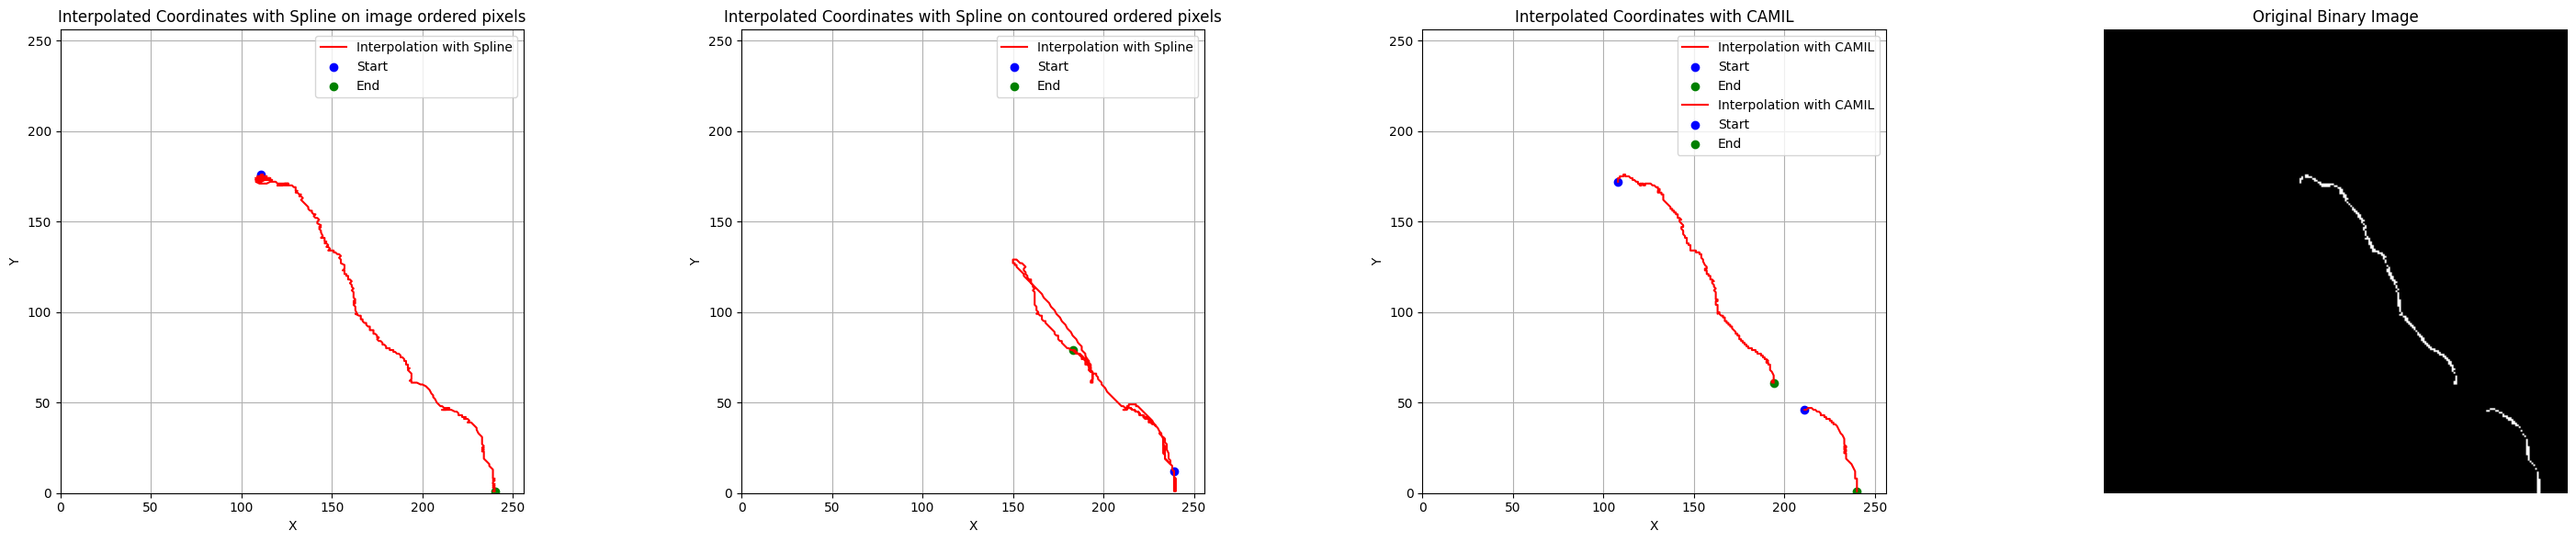

curves: 1


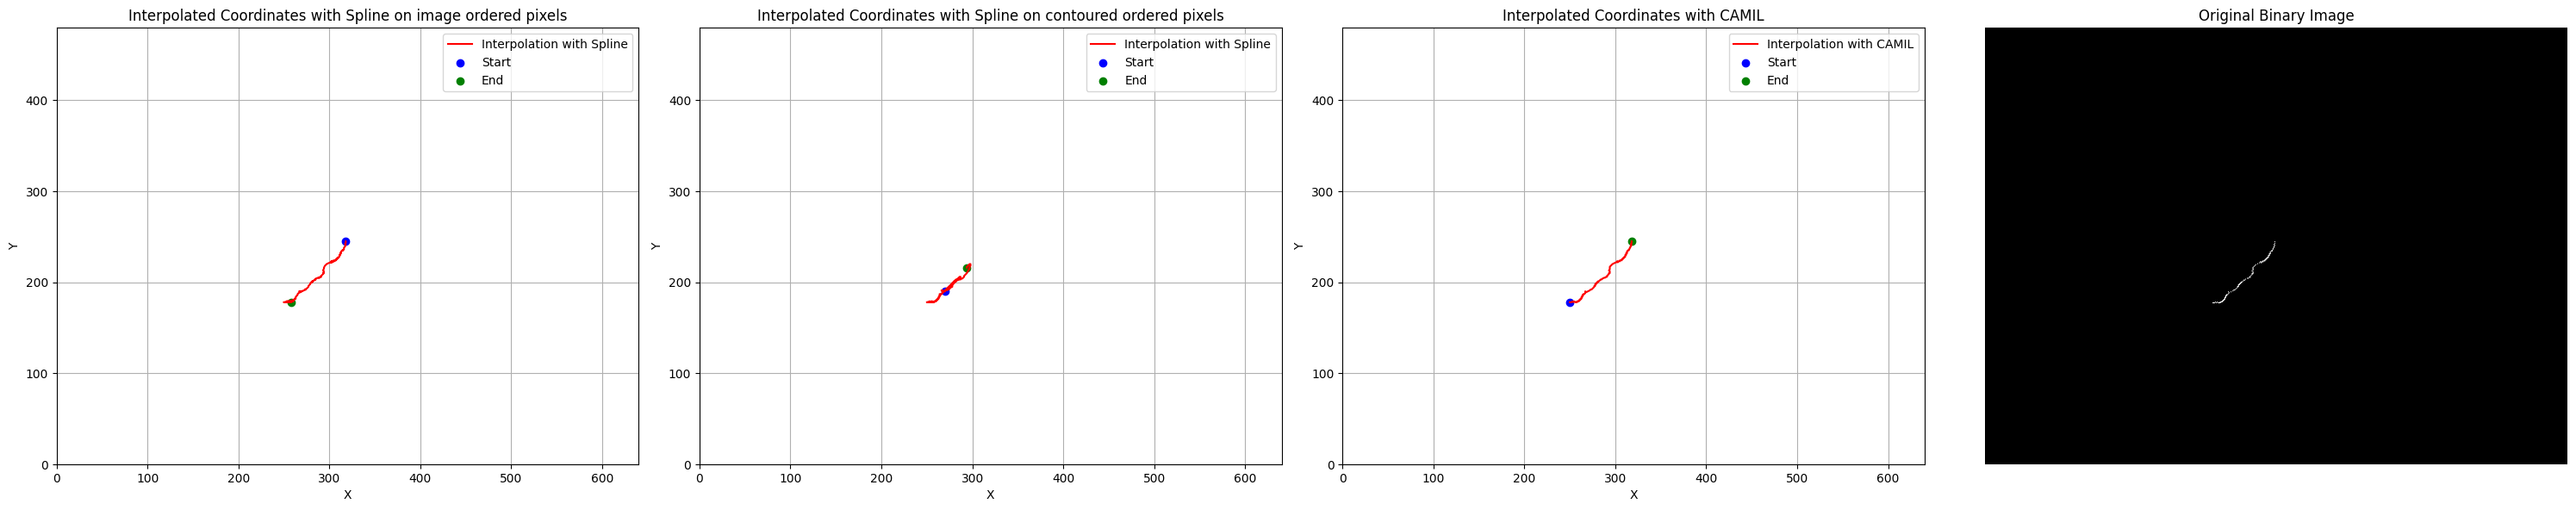

In [ ]:
# Plot the ordered paths with matplotlib
plot_camil_cont = False
for i, image in enumerate(images):
    spline_coords, spline_coords_cont = interpolate_curve(image)
    width, height, camil_coords = CAMIL.Map_image(image)
    if plot_camil_cont:
        camil_coords_cont, _ = CAMIL.map_contour(CAMIL.skeletonize(CAMIL.convert_to_binary(image.copy())))
    else:
        camil_coords_cont = None

    plot_interp(image, width, height, spline_coords, spline_coords_cont, camil_coords, camil_coords_cont, plot_camil_cont=plot_camil_cont)

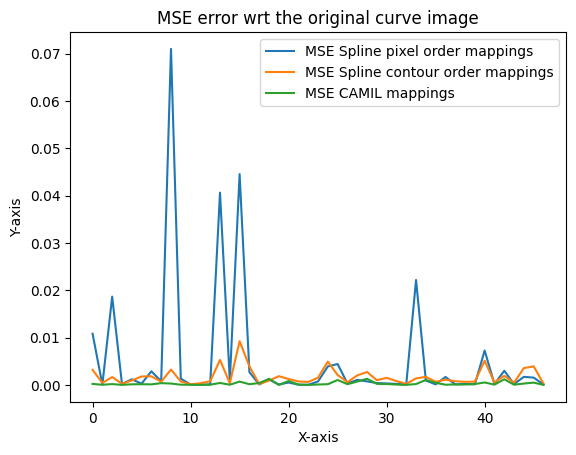

In [ ]:
mse_pixel = []
mse_cont = []
mse_camil = []
for i, image in enumerate(images):
    spline_coords, spline_coords_cont = interpolate_curve(image)
    width, height, camil_coords = CAMIL.Map_image(image)
    pixel_mse, cont_mse, camil_mse = compute_accuracy(image, spline_coords, spline_coords_cont, camil_coords)
    mse_pixel.append(pixel_mse)
    mse_cont.append(cont_mse)
    mse_camil.append(camil_mse)
plot_mse(mse_pixel, mse_cont, mse_camil)

